In [37]:
#!/usr/bin/env python3
from __future__ import division

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import os
import json
import math
import re
import random

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
from matplotlib import cm
from matplotlib.patches import Rectangle
from textwrap import wrap

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import KernelDensity

from scipy.stats import pearsonr
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.ResidueDepth import get_surface
from Bio.PDB.ResidueDepth import residue_depth
from Bio.PDB.DSSP import DSSP


import umap
import pymol

#=============================================================================

def clustering(
    df_gene: pd.DataFrame,
    gene: str,
    sample_list: list,
    sample_control: list,
    n_clusters: int,
    clustering_method: str,
    clustering_metric: str,
    output_folder: str = None,
) -> pd.DataFrame:
    """
    Perform hierarchical clustering on screen data, plot a heatmap with dendrograms, and display UMAP, PCA,
    and TSNE visualizations. Save the results if an output folder is provided.

    Parameters:
        df_gene (pd.DataFrame): DataFrame containing gene data with at least columns for expression.
        gene (str): Gene name.
        sample_list (list): List of sample column names to include in the clustering.
        sample_control (list): List of control sample column names.
        n_clusters (int): Number of clusters to generate.
        clustering_method (str): Linkage method (e.g., 'average') for clustering.
        clustering_metric (str): Distance metric (e.g., 'euclidean') for clustering.
        output_folder (str, optional): Directory path to save outputs (table and figures).

    Returns:
        pd.DataFrame: Updated DataFrame with added 'Cluster' and 'Correlation' columns.
        
    Note:
        This function expects that a global dictionary 'corr_dic' exists to provide correlation values
        for each sgID.
    """
    # Create output folder if provided
    if output_folder is not None and not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Subtract control samples from the screen data
    df_x = df_gene.loc[:, sample_list]
    if sample_control!='':
        df_x = df_x.subtract(df_x[sample_control], axis=0)

    # Perform hierarchical clustering
    cluster_model = AgglomerativeClustering(
        n_clusters=n_clusters, linkage=clustering_method, affinity=clustering_metric
    )
    cluster_model.fit(df_x)
    df_gene["Cluster"] = cluster_model.labels_

    # Set up the heatmap figure
    plt.figure(figsize=(8, 6), dpi=300)
    plt.rcParams["font.size"] = 28
    plt.rcParams["font.family"] = "Helvetica"

    # Generate colors for clusters
    cluster_labels = cluster_model.labels_
    color_options = ["red", "blue", "green", "orange", "purple",
                     "yellow", "cyan", "pink", "teal", "brown"]
    top_colors = color_options[: len(set(cluster_labels))]
    top_colors_dict = dict(zip(set(cluster_labels), top_colors))
    top_colors_list = [top_colors_dict[label] for label in cluster_labels]

    # Create the clustermap
    g = sns.clustermap(
        df_x.T,
        metric=clustering_metric,
        method=clustering_method,
        cmap="coolwarm",
        dendrogram_ratio=(0.1, 0.1),
        vmin=-1,
        vmax=1,
        row_cluster=False,
        col_cluster=True,
        cbar_pos=(0.02, 0.35, 0.03, 0.2),
        figsize=(20, 10),
        xticklabels=False,
        col_colors=top_colors_list,
    )

    cbar = g.ax_cbar
    cbar.set_title("LFC", pad=10)
    
    # Annotate mutation categories based on sgID naming
    mutation_categories = []
    for idx in g.dendrogram_col.reordered_ind:
        sgid = str(df_x.index[idx])
        if "nonsense" in sgid or "splice" in sgid:
            mutation_categories.append("Nonsense &Splicing")
        else:
            mutation_categories.append("Missense")
    
    bottom_colors_dict = {"Nonsense &Splicing": "purple", "Missense": "grey"}
    bottom_colors_list = [bottom_colors_dict[cat] for cat in mutation_categories]
    
    title_font = {"size": 40, "weight": "bold"}
    g.ax_heatmap.set_title(gene, fontdict=title_font, pad=100)
    
    # Add a bottom annotation bar for mutation categories
    ax = g.ax_heatmap
    for idx, color in enumerate(bottom_colors_list):
        ax.add_patch(
            Rectangle(
                (idx, 6.2),  # x, y
                1,
                0.2,
                facecolor=color,
                transform=ax.transData,
                clip_on=False,
            )
        )
    
    # Create legends for clusters and mutation categories
    for label, color in top_colors_dict.items():
        g.ax_col_dendrogram.bar(0, 0, color=color, label=f"Cluster {label+1}", linewidth=0)
    for label, color in bottom_colors_dict.items():
        ax.bar(0, 0, color=color, label="\n".join(wrap(label, width=9)), linewidth=0)
    
    g.ax_col_dendrogram.legend(
        loc="center", title="Clusters", bbox_to_anchor=(-0.1, 0), fontsize=25
    )
    ax.legend(
        loc="center", title="Muation Category", bbox_to_anchor=(-0.12, 0.02), fontsize=25
    )
    
    # Add correlation annotation bars using the global 'corr_dic'
    norm = Normalize(vmin=-1, vmax=1)
    cmap_obj = cm.get_cmap("bwr")
    
    df_lof = df_gene[(df_gene['Function']=='nonsense')|(df_gene['Function'].str.contains('splice')==True)]
    df_lof_data = df_lof.loc[:,sample_ls]
    df_lof_data.reset_index(drop=True, inplace=True)
    df_gene_data = df_gene.loc[:,sample_ls]
    
    corr_vals = []
    
    if df_lof.shape[0] > 0:
        for ix1 in g.dendrogram_col.reordered_ind:
            #print(df_gene_data.iloc[ix1,:])
            ls1 = list(df_gene_data.iloc[ix1,:])
            corr_ls = []
            for ix2 in df_lof_data.index:
                ls2 = list(df_lof_data.iloc[ix2,:])
                #print(ls1,ls2)
                r = pearsonr(ls1,ls2)[0]
                corr_ls.append(r)
            corr_vals.append(np.mean(corr_ls))
                
    else:
        corr_vals = ['NA'] * df_gene.shape[0]
            
    for i, cval in enumerate(corr_vals):
        rect_color = cmap_obj(norm(cval))
        ax.add_patch(
            Rectangle(
                (i, 6.7),  # x, y
                1,
                0.5,
                facecolor=rect_color,
                transform=ax.transData,
                clip_on=False,
            )
        )
        anno = "NA" if cval == 0 else ""
        ax.text(
            i + 0.5,
            6.7 + 0.25,
            anno,
            ha="center",
            va="center",
            color="black",
            fontsize=20,
            fontweight="bold",
            transform=ax.transData,
        )
    
    sm = cm.ScalarMappable(norm=norm, cmap=cmap_obj)
    sm.set_array([])
    cbar_ax = g.fig.add_axes([-0.02, -0.12, 0.1, 0.05])
    cbar2 = plt.colorbar(sm, cax=cbar_ax, orientation="horizontal")
    cbar2.set_label("Correlation", fontsize=25)
    cbar2.ax.tick_params(labelsize=26)
    
    df_gene["Correlation"] = corr_vals
    
    if output_folder is not None:
        clustermap_path = os.path.join(os.getcwd(),output_folder, f"{gene}_ClusterMap.png")
        g.fig.savefig(clustermap_path, dpi=300, facecolor="white", bbox_inches="tight")
        print(f"Clustermap figure saved to: {clustermap_path}")
    
    plt.show()
    
    # Dimensionality reduction
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_x)
    
    # UMAP
    reducer = umap.UMAP(random_state=47, n_neighbors=6, min_dist=0.3, metric="euclidean")
    embedding = reducer.fit_transform(scaled_data)
    
    # PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_data)
    
    # TSNE (highlighting potential outliers with 'nonsense' or 'splice' in index)
    lof_idx = [
        ix
        for ix in range(df_x.shape[0])
        if "splice" in str(df_x.index[ix]) or "nonsense" in str(df_x.index[ix])
    ]
    tsne = TSNE(n_components=2, random_state=47, perplexity=5)
    tsne_result = tsne.fit_transform(scaled_data)
    
    # Plot UMAP, PCA, and TSNE results
    plt.figure(figsize=(12, 4), dpi=300)
    sns.set_style("ticks")
    plt.rcParams["font.size"] = 16
    plt.rcParams["font.family"] = "Helvetica"
    
    plt.subplot(1, 3, 1)
    plt.scatter(embedding[:, 0], embedding[:, 1], c=top_colors_list, s=80)
    
    plt.scatter(
        embedding[lof_idx, 0],
        embedding[lof_idx, 1],
        c="purple",
        s=85,
        label="Nonsense&Splicing",
    )
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    
    plt.subplot(1, 3, 2)
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=top_colors_list, s=80)
    plt.scatter(
        pca_result[lof_idx, 0],
        pca_result[lof_idx, 1],
        c="purple",
        s=85,
        label="Nonsense&Splicing",
    )
    plt.xlabel("PCA Dimension 1")
    plt.ylabel("PCA Dimension 2")
    
    plt.subplot(1, 3, 3)
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=top_colors_list, s=80)
    plt.scatter(
        tsne_result[lof_idx, 0],
        tsne_result[lof_idx, 1],
        c="purple",
        s=85,
        label="Nonsense&Splicing",
    )
    plt.xlabel("TSNE Dimension 1")
    plt.ylabel("TSNE Dimension 2")
    
    plt.tight_layout()
    
    if output_folder is not None:
        dr_path = os.path.join(os.getcwd(),output_folder, f"{gene}_DimReduction.png")
        plt.savefig(dr_path, dpi=300, facecolor="white", bbox_inches="tight")
        print(f"Dimensionality reduction plot saved to: {dr_path}")
    
    plt.show()
    
    return df_gene

In [57]:
from collections import Counter
import re


df_be = pd.read_csv('../Tcell_Nature_dataset/Tcell_screen_Nature.csv')
df_be = df.dropna(subset=['Mutation'])
df_be.reset_index(drop=True,inplace=True)

mut_ls = []; aa_ls = []

for s in df_be['Mutation']:
    ls = s.split(',')
    counter = Counter(ls)
    most_common = counter.most_common(1)[0]
    mut = most_common[0]
        
    if 'splice' in mut:
        mut = 'splice'; aa = 'NA'
        print(mut,aa)
        mut_ls.append(mut)
        aa_ls.append(aa)
            
    elif '*' in mut:
        mut = 'nonsense'; aa = 'NA'
        print(mut,aa)
        mut_ls.append(mut)
        aa_ls.append(aa)
    
    else:
        match = re.search(r'\d+', mut)
        if match:
            aa = match.group()
            aa_ls.append(int(aa))
        else:
            aa = 'NA'
            aa_ls.append(aa)
        print(mut,aa)
        mut_ls.append(mut)
        
df_be['Mutation_unique'] = mut_ls
df_be['AA'] = aa_ls

df_be['lfc_max'] = [max([abs(df_be['CD25'][i]),abs(df_be['IFNG'][i]),abs(df_be['PD1'][i]),abs(df_be['TNFa'][i])]) \
                            for i in range(df_be.shape[0])]

df_neg = df_be[df_be['Gene']=='NT']

m = df_neg['lfc_max'].mean()
s = df_neg['lfc_max'].std()

df_be['Zscore'] = (df_be['lfc_max']-m)/s

C415R 415
L691P 691
Y346H 346
C422R 422
L691P 691
K185E 185
I273T 273
K185K 185
Y582C 582
Y518C 518
C422R 422
D1207G 1207
L257P 257
H295R 295
L390P 390
C43R 43
L270P 270
Y176C 176
C415R 415
Y348H 348
K252E 252
F387S 387
E580G 580
C349R 349
M207T 207
splice NA
C200R 200
None NA
L14P 14
C106R 106
splice NA
E48G 48
H295R 295
C205R 205
L871P 871
T198A 198
splice NA
C349R 349
L161P 161
C43R 43
L572P 572
L871P 871
L277P 277
L265P 265
L390P 390
Y28H 28
I340T 340
S245P 245
Y176H 176
L199P 199
W236R 236
L871P 871
L158P 158
None NA
I177T 177
V338V 338
I177T 177
None NA
L272P 272
splice NA
W311R 311
None NA
V181A 181
L272P 272
M173T 173
L51P 51
I168T 168
G666G 666
K252E 252
splice NA
K209E 209
splice NA
splice NA
splice NA
None NA
F250S 250
Y687H 687
splice NA
H584R 584
splice NA
E322G 322
None NA
Y286H 286
L36P 36
C201R 201
splice NA
F133L 133
D83G 83
splice NA
W623R 623
C531R 531
Y753H 753
Y315H 315
splice NA
S333P 333
Y315H 315
L546S 546
R485G 485
Y700C 700
splice NA
L49P 49
W27R 27
Y508H 508


Y71H 71
S207P 207
M0V 0
nonsense NA
L50P 50
nonsense NA
L429P 429
L212P 212
None NA
F489S 489
M0T 0
None NA
C241R 241
L2070S 2070
Y427C 427
Y105H 105
L887P 887
splice NA
G437G 437
C578R 578
splice NA
L96P 96
None NA
S99G 99
I107T 107
Y479H 479
None NA
S642G 642
M142T 142
K58E 58
L834P 834
T197A 197
H372R 372
None NA
None NA
S26G 26
C686R 686
splice NA
S117G 117
T117A 117
R1315R 1315
None NA
E126G 126
C90R 90
I1166V 1166
M0T 0
L568P 568
K428E 428
T570A 570
K766E 766
None NA
S519P 519
I72T 72
F712L 712
K436E 436
K38E 38
F348S 348
Q199R 199
nonsense NA
L96P 96
None NA
Q38Q 38
R960R 960
splice NA
L955P 955
N285D 285
None NA
R436G 436
K432R 432
W432R 432
L358P 358
D1D 1
None NA
S585P 585
None NA
M76T 76
F186S 186
F648S 648
splice NA
V760A 760
E870G 870
K807E 807
L282P 282
H20R 20
D293G 293
None NA
Y467H 467
E368G 368
None NA
Y1449C 1449
R313G 313
I1891T 1891
S417P 417
M84T 84
M868T 868
K272E 272
L34P 34
L705P 705
L440P 440
L639P 639
E278G 278
splice NA
Y288H 288
F290S 290
M773T 773
splice N

K41E 41
splice NA
I297V 297
K204E 204
splice NA
L772P 772
L37P 37
L555P 555
F206S 206
E1018G 1018
L154P 154
E167E 167
None NA
S294P 294
None NA
S283P 283
A142A 142
S43P 43
R19R 19
None NA
F164S 164
E317G 317
V379A 379
None NA
Q603R 603
I17T 17
V5A 5
splice NA
L76S 76
None NA
F60S 60
M49V 49
D468G 468
S102G 102
None NA
C339R 339
W333R 333
E214G 214
L2406P 2406
C98R 98
L63S 63
L584S 584
M820V 820
S85G 85
K539E 539
M46V 46
L91P 91
W173R 173
E25G 25
None NA
S215G 215
None NA
Y563H 563
None NA
I2152T 2152
D348G 348
P11P 11
D701G 701
V667A 667
H372R 372
I68V 68
I402M 402
W53R 53
S87P 87
None NA
None NA
None NA
Y413C 413
splice NA
None NA
R57R 57
None NA
L737P 737
F217S 217
Y671H 671
L475P 475
A247A 247
L251P 251
K439E 439
D52G 52
T319A 319
I623T 623
splice NA
R54G 54
S980P 980
E342G 342
Y39H 39
None NA
W46R 46
None NA
P191P 191
A10A 10
S246P 246
T161A 161
K1086E 1086
S171P 171
Q115R 115
Q102R 102
V362A 362
splice NA
T509A 509
F867F 867
K54E 54
None NA
splice NA
F118L 118
None NA
I73V 73
F149

Y750H 750
S321S 321
F1033S 1033
None NA
K399E 399
None NA
None NA
None NA
I498T 498
F410S 410
Y47C 47
A212A 212
S493P 493
L614S 614
L588P 588
E98G 98
None NA
L145S 145
E728G 728
None NA
Y424C 424
V832A 832
L81S 81
None NA
I735T 735
None NA
None NA
L232S 232
K664E 664
D84G 84
E237G 237
S312P 312
L274P 274
F690S 690
M0V 0
Y28C 28
L150P 150
splice NA
Q12R 12
L113P 113
None NA
E361G 361
None NA
L16P 16
None NA
F596S 596
S118S 118
splice NA
None NA
L25P 25
T30T 30
Q1125R 1125
None NA
S234P 234
T323A 323
E712E 712
L792P 792
L1024P 1024
None NA
P139P 139
None NA
V506A 506
Q247R 247
M210T 210
V344A 344
C479R 479
E267G 267
None NA
Y347H 347
V406A 406
D122G 122
None NA
H181R 181
M416V 416
H516R 516
K1296R 1296
E280G 280
L177P 177
T442T 442
K235R 235
M409T 409
None NA
Q707R 707
None NA
C792R 792
V87A 87
T382A 382
Y200H 200
None NA
F149S 149
K743R 743
splice NA
None NA
splice NA
None NA
V546A 546
R672G 672
G697G 697
M196V 196
E563G 563
I943T 943
N223D 223
S147P 147
S43P 43
C326R 326
C254R 254
None

L424L 424
L1438L 1438
K141R 141
T801A 801
None NA
N543N 543
splice NA
L600P 600
None NA
E221G 221
I93T 93
Y542H 542
Q347R 347
L567P 567
G435G 435
L212P 212
None NA
S496P 496
Q65R 65
D1154G 1154
None NA
E116G 116
Q134R 134
None NA
H431R 431
D160G 160
None NA
splice NA
M0T 0
S93G 93
None NA
F1404S 1404
P362P 362
L508P 508
D1637D 1637
S23S 23
T948T 948
K454E 454
nonsense NA
P289P 289
None NA
A235A 235
None NA
splice NA
D242G 242
Q412R 412
E279G 279
D283G 283
None NA
None NA
splice NA
None NA
E6G 6
I345V 345
R532R 532
L441P 441
None NA
None NA
T516A 516
I286V 286
M123V 123
L364P 364
S640G 640
None NA
S118G 118
L25P 25
None NA
S326P 326
None NA
L770P 770
None NA
None NA
G744G 744
C1039R 1039
H140R 140
M105T 105
Q695R 695
L1182L 1182
T1883A 1883
F169S 169
None NA
Y558H 558
D21G 21
F203S 203
K194E 194
L175P 175
R47G 47
V115A 115
D130G 130
splice NA
P293P 293
W532R 532
F214S 214
L368S 368
M81T 81
None NA
A151A 151
None NA
M0V 0
splice NA
L273P 273
L507S 507
splice NA
K329E 329
Q323R 323
T279T 

Y439H 439
I37V 37
None NA
H111R 111
V152A 152
N347D 347
None NA
None NA
F6S 6
Q172R 172
None NA
None NA
Q465R 465
None NA
P993P 993
L169P 169
L176P 176
C673R 673
S34P 34
W3R 3
splice NA
S1032S 1032
Y485C 485
None NA
K279E 279
K985E 985
L28P 28
D238G 238
L309L 309
None NA
V17A 17
I250V 250
None NA
V75A 75
I230T 230
None NA
None NA
L315P 315
E406G 406
I228T 228
S85P 85
K182E 182
V508A 508
C177R 177
D285G 285
None NA
G176G 176
D191D 191
E97E 97
V488A 488
V222A 222
None NA
I51T 51
None NA
S150G 150
None NA
None NA
M177V 177
S493P 493
None NA
I256T 256
I184V 184
L9P 9
None NA
L693P 693
None NA
None NA
G96G 96
V124A 124
I317V 317
None NA
None NA
S498P 498
None NA
E99G 99
L546S 546
M475T 475
V965A 965
I166T 166
T400T 400
M339T 339
V136A 136
P260P 260
S177G 177
Y78C 78
None NA
S328G 328
None NA
None NA
S332G 332
None NA
P360P 360
L2266P 2266
I144T 144
S2453S 2453
M1073T 1073
K107E 107
splice NA
None NA
None NA
None NA
splice NA
G298G 298
K171E 171
Q2R 2
None NA
None NA
E141G 141
None NA
P1411P

None NA
None NA
P410P 410
None NA
F318S 318
I306V 306
E234G 234
V684A 684
D137G 137
None NA
P1188P 1188
None NA
None NA
N116N 116
None NA
None NA
A601A 601
P240P 240
H8R 8
D462G 462
splice NA
F666S 666
L102P 102
None NA
H243R 243
Y528H 528
L571P 571
F103S 103
M198V 198
None NA
H278H 278
P133P 133
R65R 65
L372S 372
T639T 639
None NA
E447G 447
L176P 176
K333E 333
V1281A 1281
T286A 286
None NA
None NA
S31S 31
S330P 330
None NA
None NA
E152G 152
P408P 408
P15P 15
None NA
L180P 180
L281P 281
L5S 5
Y849C 849
None NA
Q989R 989
R454G 454
None NA
Y898C 898
E320G 320
C415R 415
E15G 15
None NA
K139R 139
Y186H 186
None NA
None NA
S8P 8
L904P 904
C178R 178
T424A 424
D343D 343
None NA
V31A 31
K1144R 1144
Q27R 27
E155G 155
S60P 60
M203T 203
D282G 282
None NA
None NA
None NA
T81A 81
None NA
V347A 347
splice NA
P696P 696
None NA
None NA
I186V 186
N243S 243
V494A 494
R30G 30
None NA
L326P 326
None NA
I385T 385
M614T 614
T86A 86
L13P 13
K220R 220
Y238C 238
V325A 325
V89A 89
splice NA
R594G 594
E18G 18
S9

P340P 340
None NA
Y498H 498
None NA
K49R 49
Y976H 976
Y821H 821
None NA
None NA
L610P 610
H349R 349
None NA
None NA
N95S 95
Y89Y 89
None NA
P217P 217
N149D 149
S37P 37
None NA
P1215P 1215
Q633R 633
D172G 172
M365T 365
D62D 62
N302N 302
S70S 70
None NA
L59P 59
S28G 28
C328R 328
None NA
None NA
E158G 158
Y720H 720
K18E 18
S842S 842
None NA
I345T 345
V428A 428
E534G 534
None NA
Q764R 764
G429G 429
C213R 213
Y141C 141
E207G 207
V1048A 1048
T712T 712
D480G 480
L530P 530
splice NA
None NA
R252G 252
None NA
L175P 175
L174P 174
V96A 96
None NA
None NA
L163L 163
F489S 489
C749R 749
R345R 345
P251P 251
K124E 124
N308D 308
W577R 577
V688A 688
T228A 228
T326T 326
K143E 143
C264R 264
R200G 200
L1008S 1008
None NA
H1597R 1597
Y79H 79
splice NA
None NA
T169A 169
L58P 58
C219R 219
L18P 18
V14A 14
None NA
E48G 48
K247R 247
I16V 16
F510S 510
A440A 440
None NA
None NA
None NA
C9R 9
S103P 103
None NA
S711S 711
L17P 17
Y165H 165
None NA
None NA
H694R 694
I304V 304
Q447R 447
Q404R 404
None NA
P708P 708
D341

N251N 251
None NA
None NA
Y384C 384
None NA
L461P 461
None NA
N130S 130
None NA
None NA
D594G 594
splice NA
P643P 643
A321A 321
None NA
None NA
splice NA
S334G 334
V273A 273
Y63H 63
S196G 196
S1006P 1006
D71G 71
splice NA
None NA
L335S 335
Q332R 332
None NA
I364V 364
D820G 820
None NA
G489G 489
V220V 220
T81T 81
I704V 704
None NA
None NA
S336G 336
E236G 236
Y25H 25
None NA
D98D 98
S306G 306
None NA
G654G 654
E16G 16
W903R 903
None NA
Y264C 264
None NA
L362S 362
None NA
I438V 438
D35G 35
Y829Y 829
None NA
D24G 24
L182P 182
V412A 412
E181E 181
C146R 146
S333S 333
D249G 249
None NA
N821D 821
None NA
Y852C 852
G475G 475
None NA
None NA
L413P 413
F292L 292
W112R 112
None NA
L487P 487
I659V 659
H231H 231
D208D 208
P407P 407
V451A 451
S456S 456
I141T 141
None NA
E70G 70
A411A 411
D282G 282
None NA
None NA
None NA
None NA
S773P 773
S65G 65
M430T 430
S987P 987
D94G 94
V355A 355
H194R 194
None NA
M1037T 1037
K95E 95
E177G 177
None NA
None NA
L131P 131
Q69R 69
A115A 115
Y495H 495
K235E 235
T194T 

L13P 13
None NA
I809V 809
R292R 292
L758P 758
V147A 147
M0V 0
R146R 146
splice NA
E1120G 1120
T481A 481
R281G 281
V90A 90
Q1147R 1147
E554G 554
E44G 44
W629R 629
I664T 664
S224P 224
E986G 986
I78V 78
E353G 353
None NA
E200G 200
T856T 856
I117T 117
V727A 727
None NA
M168V 168
I165V 165
F229L 229
None NA
L430P 430
A190A 190
M172V 172
L643P 643
None NA
V11A 11
None NA
K310E 310
None NA
Q539R 539
Q424R 424
splice NA
None NA
L26P 26
None NA
None NA
None NA
P34P 34
E529G 529
None NA
None NA
S90P 90
Y572H 572
None NA
E701G 701
None NA
F323S 323
L183P 183
P112P 112
None NA
L566P 566
T978A 978
D238G 238
None NA
None NA
None NA
P391P 391
None NA
None NA
None NA
I633T 633
E82G 82
T578A 578
K165E 165
None NA
K584R 584
F54S 54
C538R 538
D94G 94
D131G 131
Q573R 573
None NA
None NA
S468P 468
T108A 108
K405E 405
L100L 100
P1091P 1091
L290P 290
D1181G 1181
None NA
S784P 784
L21S 21
T566A 566
S587G 587
None NA
E141G 141
I305V 305
S234G 234
L162P 162
None NA
H223R 223
L791P 791
None NA
None NA
N185D 185


V84A 84
I386T 386
None NA
None NA
None NA
L320L 320
None NA
R20G 20
splice NA
I220T 220
G145G 145
T78A 78
E1032G 1032
L252P 252
V32V 32
S511S 511
L185P 185
K166E 166
L572L 572
None NA
None NA
Y148C 148
Q50R 50
F194S 194
N68S 68
Y775H 775
S370P 370
V478A 478
None NA
None NA
F635S 635
I263T 263
I43T 43
N509N 509
S280S 280
K95E 95
None NA
None NA
M251T 251
I537V 537
K308E 308
None NA
K232R 232
None NA
None NA
T725A 725
E181E 181
I888T 888
L408P 408
None NA
K128E 128
H587R 587
Y1082H 1082
S587G 587
E1350G 1350
E436G 436
S7S 7
P557P 557
V1192A 1192
E934G 934
Y1082H 1082
A74A 74
L411P 411
Q23Q 23
L149P 149
None NA
Y419C 419
D91D 91
T551A 551
None NA
S1007S 1007
R253G 253
V138A 138
A136A 136
Y100H 100
N338D 338
L126P 126
None NA
E549G 549
F223S 223
None NA
E53G 53
R199G 199
None NA
None NA
None NA
D758G 758
None NA
L864P 864
F372S 372
None NA
V21A 21
I354V 354
M0T 0
L108P 108
T161A 161
N390D 390
P404P 404
I1125T 1125
S224S 224
P712P 712
T221T 221
None NA
P1086P 1086
D231G 231
None NA
D314G 31

Q454R 454
None NA
I218T 218
A328A 328
Y720C 720
None NA
Y137C 137
None NA
None NA
N612D 612
None NA
S285S 285
D377G 377
None NA
I308V 308
S708P 708
R226G 226
None NA
L454P 454
R54R 54
None NA
V1123A 1123
R265G 265
S159P 159
S798S 798
G485G 485
H315R 315
L206L 206
None NA
P318P 318
L255S 255
E242G 242
N129N 129
Y366H 366
R301R 301
K289E 289
None NA
L109L 109
M220T 220
V284A 284
I81V 81
None NA
None NA
None NA
S289G 289
None NA
None NA
None NA
L651P 651
None NA
H99R 99
None NA
None NA
V169V 169
None NA
E65G 65
T208A 208
None NA
None NA
V542A 542
V251A 251
I365T 365
V433A 433
L341L 341
N636S 636
E253G 253
E795G 795
S165P 165
None NA
G510G 510
R64R 64
D552G 552
K117E 117
None NA
None NA
Q110R 110
K356E 356
L39P 39
None NA
None NA
None NA
F600S 600
A251A 251
T95T 95
None NA
V124A 124
D738G 738
Y445C 445
None NA
L221P 221
None NA
T662A 662
S366S 366
S575G 575
P377P 377
L284P 284
Q655R 655
None NA
R209G 209
S457G 457
splice NA
None NA
K56E 56
T348A 348
T381T 381
Y1280H 1280
H172R 172
None NA


C750R 750
D636G 636
Y71H 71
P111P 111
None NA
L135P 135
D95G 95
None NA
Q358Q 358
L416P 416
L507P 507
None NA
None NA
None NA
None NA
None NA
None NA
V154A 154
Y98H 98
I457V 457
None NA
None NA
None NA
None NA
C477R 477
L675P 675
None NA
A271A 271
I300V 300
None NA
G472G 472
Y624H 624
None NA
None NA
A1320A 1320
None NA
L664P 664
L65L 65
Y484H 484
S374G 374
D1097D 1097
L515S 515
None NA
V1203A 1203
D1077G 1077
None NA
splice NA
N255N 255
None NA
D78D 78
T279T 279
None NA
None NA
R339G 339
None NA
E65G 65
None NA
K119E 119
M617V 617
E47G 47
None NA
S88P 88
K746E 746
E1124G 1124
K36R 36
splice NA
T444A 444
L67S 67
I588T 588
F843S 843
None NA
D137D 137
D628D 628
None NA
None NA
I392T 392
V733A 733
P171P 171
None NA
None NA
D430G 430
C750C 750
None NA
None NA
None NA
K165R 165
I188V 188
P359P 359
None NA
R162G 162
V102A 102
E314G 314
None NA
E100G 100
R535R 535
None NA
M106T 106
S41G 41
P176P 176
V259A 259
D313G 313
N683S 683
None NA
Y51C 51
None NA
L227P 227
D989G 989
E266G 266
I240V 240


K400R 400
None NA
None NA
None NA
P310P 310
Q658R 658
S380P 380
M174V 174
None NA
I13T 13
S456P 456
Y67C 67
S287P 287
L254P 254
None NA
Q827R 827
None NA
None NA
Y810H 810
P15P 15
None NA
None NA
A563A 563
None NA
I254V 254
L755P 755
splice NA
S136G 136
N1259D 1259
L146P 146
Q345R 345
None NA
G655G 655
None NA
Y463H 463
S1218G 1218
K620E 620
L802P 802
V316A 316
F367S 367
None NA
splice NA
None NA
None NA
K940K 940
None NA
Y55H 55
L718P 718
M369T 369
G428G 428
S147S 147
I266V 266
N315S 315
I81V 81
D1899G 1899
None NA
D638G 638
Y330Y 330
K44R 44
T653A 653
M57T 57
R601G 601
R161G 161
L581P 581
None NA
E227G 227
L313P 313
F253S 253
None NA
S54P 54
None NA
I714T 714
S574P 574
K668E 668
M243V 243
E258G 258
S131P 131
T56A 56
A350A 350
None NA
P432P 432
L514L 514
None NA
A786A 786
None NA
S32P 32
K574R 574
S454P 454
C323R 323
Y384H 384
None NA
S1145P 1145
K551E 551
S416P 416
None NA
None NA
L687L 687
D137G 137
N51D 51
L76P 76
splice NA
None NA
N249D 249
D382G 382
splice NA
V891A 891
None NA
S7

None NA
E134G 134
S384S 384
L779S 779
None NA
None NA
None NA
T557A 557
S160P 160
None NA
C331R 331
E57G 57
S287S 287
L1443P 1443
V1235A 1235
L261L 261
L208P 208
L503P 503
S216S 216
P95P 95
H31R 31
L856P 856
F56S 56
None NA
N2172D 2172
None NA
None NA
None NA
L364P 364
L260P 260
L113P 113
N730N 730
R160R 160
None NA
L453S 453
V441A 441
L348P 348
None NA
L348P 348
V286A 286
None NA
T177T 177
T48A 48
None NA
None NA
None NA
F202S 202
V80A 80
None NA
None NA
None NA
None NA
None NA
T141A 141
None NA
G359G 359
I1305T 1305
C379R 379
N325D 325
F29L 29
C325C 325
K162E 162
None NA
S29P 29
V116A 116
None NA
V175A 175
None NA
S70S 70
T231A 231
L46P 46
K382E 382
None NA
G93G 93
L1081P 1081
N105D 105
None NA
D759G 759
D312G 312
E97G 97
V96A 96
A274A 274
S392P 392
A660A 660
N530D 530
None NA
None NA
K226E 226
L427P 427
M150T 150
S528P 528
F257S 257
None NA
D121G 121
S800S 800
Y337H 337
None NA
None NA
P435P 435
Q879R 879
E27G 27
None NA
None NA
C243R 243
M497V 497
None NA
None NA
N16D 16
V669A 669


A24A 24
K303R 303
Q215R 215
None NA
K594R 594
G8G 8
V459A 459
None NA
T94A 94
E170G 170
H811R 811
E592G 592
T538A 538
M237V 237
T56A 56
Q60R 60
I709T 709
I237V 237
V210A 210
E180G 180
W293R 293
D779D 779
D1057G 1057
L450P 450
I583V 583
L16P 16
F630S 630
None NA
Y154C 154
M920T 920
None NA
None NA
K574E 574
L412P 412
S345P 345
L78L 78
Y155C 155
None NA
D602G 602
None NA
L261P 261
V151A 151
None NA
I266V 266
splice NA
None NA
None NA
Y455H 455
None NA
S173S 173
I566V 566
N536S 536
C347R 347
C74R 74
H59R 59
G661G 661
E40G 40
None NA
None NA
H225H 225
L1305P 1305
E845G 845
L537P 537
E104G 104
D668D 668
M315V 315
S92P 92
None NA
E249G 249
P83P 83
K168E 168
Y18H 18
N679D 679
F406S 406
D231G 231
M0T 0
L2016P 2016
Y44H 44
I1002V 1002
I238V 238
L159L 159
M115V 115
I245T 245
S89P 89
Y230H 230
Y253H 253
S93S 93
L404P 404
None NA
None NA
D634G 634
R380G 380
N122S 122
None NA
F415S 415
None NA
M968T 968
L265P 265
D369D 369
L991P 991
D50D 50
L355S 355
L44P 44
Q192R 192
None NA
D235G 235
None NA
F26S

S1076P 1076
None NA
S754G 754
S29P 29
F574S 574
H455R 455
Q374R 374
L427P 427
F265S 265
None NA
L1148P 1148
F165S 165
None NA
None NA
None NA
C242R 242
S879P 879
P602P 602
E114G 114
V347A 347
F185L 185
None NA
None NA
H531R 531
G1677G 1677
F344S 344
I297V 297
None NA
N348D 348
L605L 605
S69P 69
G342G 342
P132P 132
D156G 156
None NA
E98G 98
E566E 566
None NA
I164V 164
G138G 138
C226R 226
I1V 1
S61P 61
S517G 517
K508E 508
E187E 187
D536G 536
None NA
None NA
V166A 166
S298P 298
Y348C 348
L105L 105
K1247E 1247
None NA
S587P 587
None NA
C30R 30
E306G 306
T115A 115
K23R 23
V480A 480
C154R 154
L157P 157
I1301T 1301
E288G 288
L329S 329
F423L 423
F244S 244
None NA
I12T 12
C193R 193
D758D 758
C268R 268
V137A 137
E277G 277
P1229P 1229
Y1226H 1226
V450V 450
S33P 33
nonsense NA
P640P 640
K15E 15
splice NA
P148P 148
Q538R 538
T31A 31
K516R 516
splice NA
None NA
None NA
Q221R 221
None NA
None NA
S971P 971
None NA
None NA
None NA
None NA
None NA
N526S 526
None NA
N14D 14
None NA
L414P 414
None NA
A531

None NA
I770T 770
V898A 898
S882P 882
Y222C 222
None NA
V26A 26
K427E 427
None NA
None NA
R872R 872
S26P 26
Y161H 161
N496D 496
None NA
splice NA
None NA
S323P 323
None NA
None NA
H260R 260
Y937H 937
None NA
None NA
V437A 437
Y273Y 273
Y31H 31
I20T 20
L764P 764
None NA
None NA
S213G 213
None NA
F267S 267
Q236R 236
S443P 443
D17G 17
None NA
K943E 943
V120A 120
F470S 470
L527P 527
L35P 35
None NA
None NA
Q102R 102
S540P 540
L974S 974
None NA
D218G 218
None NA
D608D 608
None NA
A553A 553
S409S 409
I56T 56
T587A 587
Q265Q 265
D203G 203
None NA
None NA
None NA
splice NA
N349D 349
None NA
T111A 111
N422N 422
V414A 414
splice NA
N773S 773
None NA
Q29R 29
M50V 50
D231G 231
None NA
None NA
D26G 26
S70P 70
H1940R 1940
E732G 732
nonsense NA
None NA
S315P 315
E264G 264
None NA
I72T 72
G358G 358
D40G 40
None NA
S272S 272
None NA
None NA
splice NA
splice NA
P497P 497
None NA
F408S 408
K531R 531
P114P 114
S390P 390
K166E 166
L499P 499
Q159R 159
None NA
L231P 231
T518A 518
L7P 7
splice NA
Q178R 178
N2

L781L 781
I215V 215
K117E 117
P141P 141
L975S 975
D22G 22
E26G 26
G484G 484
None NA
None NA
K1051E 1051
L110P 110
None NA
None NA
D12G 12
I460V 460
None NA
H146R 146
M446V 446
L20P 20
T179A 179
K676E 676
R242R 242
K446E 446
E613G 613
None NA
K306E 306
N106D 106
S187P 187
splice NA
C75R 75
None NA
Q503R 503
D384G 384
None NA
S511P 511
K461E 461
T23A 23
F246F 246
F218L 218
I3V 3
None NA
Q485R 485
Y484C 484
Y384C 384
D320D 320
splice NA
None NA
K399R 399
Q599R 599
S310G 310
K767E 767
A417A 417
I223V 223
P128P 128
None NA
K347R 347
None NA
S336P 336
L56P 56
S11P 11
L14P 14
L62P 62
None NA
V49A 49
T95A 95
S512P 512
None NA
I165V 165
M31T 31
H469H 469
Y102C 102
V797A 797
V309A 309
L521P 521
C964R 964
T556T 556
D42D 42
None NA
S265P 265
D7G 7
H179R 179
M1040V 1040
None NA
None NA
splice NA
I829V 829
T554A 554
L493P 493
None NA
P258P 258
E268G 268
C1019R 1019
L314P 314
None NA
None NA
None NA
M7T 7
None NA
V85A 85
P993P 993
None NA
None NA
None NA
None NA
N310D 310
P246P 246
None NA
Q217R 217


F319S 319
L268P 268
V56A 56
None NA
S687P 687
F449L 449
W866R 866
Q172R 172
None NA
None NA
I89T 89
splice NA
E444G 444
D193G 193
R197G 197
None NA
W98R 98
Q252R 252
None NA
N714N 714
K123E 123
S858S 858
H462H 462
P50P 50
C83R 83
S292S 292
S572S 572
V1147A 1147
None NA
E128E 128
E181G 181
K1197R 1197
None NA
None NA
M11T 11
A406A 406
D46G 46
K694E 694
A280A 280
P426P 426
None NA
None NA
I151T 151
T970T 970
None NA
F900S 900
S974S 974
splice NA
S322S 322
T95T 95
L188P 188
S150P 150
E601G 601
None NA
W363R 363
None NA
T303T 303
None NA
R268R 268
None NA
L190P 190
None NA
R1641R 1641
Y705C 705
Q354R 354
None NA
E1273E 1273
S1211P 1211
None NA
K22E 22
E724G 724
A13A 13
None NA
L867L 867
V749A 749
T198A 198
None NA
S517S 517
S68G 68
Q424R 424
None NA
None NA
F29S 29
E334G 334
splice NA
nonsense NA
L49P 49
E301G 301
I175T 175
G351G 351
S372G 372
K271E 271
None NA
T480A 480
T25A 25
N553N 553
S152P 152
None NA
E394G 394
E589G 589
I569T 569
S408S 408
Q330R 330
R61R 61
splice NA
I526T 526
V405A 

None NA
Q321R 321
None NA
D264G 264
splice NA
S280P 280
T248A 248
None NA
T323A 323
C297R 297
D399G 399
S375P 375
V719A 719
None NA
K430K 430
I590T 590
R197G 197
L90P 90
S226S 226
C158R 158
None NA
N739S 739
C712R 712
T180A 180
L404P 404
S66G 66
D58D 58
S609P 609
None NA
splice NA
Q1003R 1003
S272P 272
None NA
None NA
Y323C 323
None NA
splice NA
I3V 3
H225R 225
None NA
None NA
None NA
None NA
None NA
C11R 11
E11G 11
C233R 233
None NA
T100A 100
None NA
S144S 144
None NA
E832G 832
Q43R 43
M102T 102
R367G 367
Q1453R 1453
Y476H 476
I204V 204
E303G 303
K294E 294
S623P 623
None NA
I315T 315
T106A 106
None NA
T326T 326
L248L 248
E373G 373
Q346R 346
P78P 78
I78V 78
None NA
splice NA
K453E 453
H406H 406
L717S 717
None NA
I777T 777
L574P 574
V683A 683
E251G 251
None NA
G182G 182
None NA
L197P 197
None NA
None NA
F652S 652
G175G 175
I112T 112
None NA
Y460H 460
N1037S 1037
Y1178H 1178
L103P 103
N154N 154
None NA
Y107H 107
I624T 624
Q78R 78
Q284R 284
Q312R 312
None NA
None NA
None NA
S368P 368
None

S426S 426
None NA
M0V 0
None NA
Y225H 225
None NA
None NA
None NA
S171G 171
Y256C 256
None NA
M161V 161
Q29R 29
S7G 7
None NA
None NA
Y213H 213
None NA
S12G 12
T303A 303
D354D 354
Y222H 222
None NA
A382A 382
None NA
T659T 659
Y778Y 778
None NA
I246M 246
I13V 13
None NA
L488P 488
S106S 106
I281T 281
E71G 71
None NA
Q290R 290
Y19C 19
E336E 336
E195G 195
None NA
R1271R 1271
S587P 587
I139V 139
E191G 191
P778P 778
None NA
V42A 42
K389E 389
I100T 100
M769T 769
S219P 219
D512G 512
T385A 385
Y378H 378
None NA
L477S 477
C83R 83
C33C 33
E105G 105
D418G 418
E785G 785
A389A 389
None NA
R199G 199
E298G 298
I338T 338
None NA
None NA
E337G 337
K690E 690
None NA
R1034G 1034
I221T 221
K646R 646
None NA
E99G 99
None NA
L186P 186
None NA
splice NA
M0V 0
M846T 846
None NA
S376P 376
A17A 17
None NA
E292G 292
L616S 616
I1145T 1145
None NA
L883P 883
I610T 610
Y1145H 1145
C1873R 1873
None NA
splice NA
None NA
F398S 398
None NA
L26L 26
None NA
N374N 374
None NA
None NA
None NA
L630P 630
D832G 832
N106D 106
S1

T611T 611
M432T 432
L303P 303
None NA
L46P 46
Q107R 107
T1058T 1058
I372T 372
None NA
None NA
P475P 475
None NA
None NA
T155A 155
None NA
G537G 537
T281A 281
Q319R 319
E463G 463
S524P 524
None NA
None NA
E432G 432
None NA
Y448H 448
S322S 322
None NA
None NA
D268D 268
None NA
L642L 642
splice NA
None NA
S431S 431
H1914R 1914
C131R 131
None NA
P30P 30
None NA
K206E 206
I44V 44
A52A 52
D218G 218
None NA
L95P 95
None NA
None NA
P69P 69
nonsense NA
None NA
S204P 204
A717A 717
P299P 299
K275E 275
None NA
V228A 228
None NA
I616T 616
P155P 155
None NA
None NA
I710T 710
F626S 626
L185P 185
None NA
Q931R 931
T355T 355
None NA
E335G 335
K1095E 1095
Y387H 387
A19A 19
None NA
D593D 593
H246R 246
M65T 65
None NA
splice NA
None NA
D246G 246
D811D 811
None NA
None NA
S735S 735
None NA
None NA
None NA
None NA
I70T 70
E374G 374
N299D 299
L12P 12
I635V 635
I278V 278
None NA
S463P 463
S515G 515
L112P 112
V129A 129
Q211R 211
S7G 7
M472V 472
K876E 876
M384V 384
None NA
M0V 0
None NA
V255A 255
None NA
None N

V90V 90
M485T 485
None NA
E225E 225
N200D 200
None NA
H557H 557
M465V 465
K161R 161
S521P 521
N267D 267
G339G 339
V213A 213
None NA
N1421D 1421
None NA
V97A 97
K258R 258
L397L 397
splice NA
L120P 120
S130P 130
L185P 185
M0T 0
G388G 388
R646R 646
K93E 93
F141S 141
S116P 116
S1800S 1800
None NA
None NA
E918G 918
None NA
M80V 80
M225T 225
Q612R 612
G377G 377
S84S 84
S132P 132
A15A 15
L197P 197
Q144R 144
L35L 35
Y351H 351
None NA
None NA
L47S 47
E1727G 1727
C289R 289
P141P 141
E123G 123
E181G 181
None NA
E435G 435
D80G 80
None NA
None NA
L215P 215
L25P 25
V361A 361
A424A 424
R101G 101
None NA
D94G 94
M34T 34
None NA
Q437R 437
None NA
L132P 132
S43G 43
S15S 15
S47P 47
G205G 205
I230V 230
F687S 687
T902A 902
L34L 34
P324P 324
T107A 107
None NA
None NA
K731E 731
A295A 295
F329S 329
D245G 245
I209V 209
Q73R 73
E1123E 1123
P360P 360
None NA
G228G 228
L440P 440
Y184H 184
P497P 497
None NA
S189G 189
None NA
None NA
P343P 343
K484E 484
L383P 383
V179A 179
V502A 502
None NA
N222D 222
T84A 84
None N

None NA
S859G 859
Q378R 378
L459P 459
None NA
None NA
Y507H 507
P273P 273
K302E 302
P592P 592
L164L 164
V4A 4
None NA
I124V 124
None NA
L748P 748
S879P 879
I299V 299
P204P 204
T324A 324
E701G 701
S40P 40
None NA
None NA
N93D 93
N317D 317
H352R 352
E173G 173
G26G 26
L590P 590
S393P 393
None NA
H243H 243
H218H 218
I736T 736
S13S 13
Q669R 669
None NA
H244H 244
D46G 46
R66G 66
W1756R 1756
S1235S 1235
D646G 646
P224P 224
D88D 88
Q144R 144
E215G 215
None NA
None NA
None NA
T170A 170
None NA
F364S 364
Y27C 27
Q526R 526
N618N 618
T314T 314
V144A 144
F649S 649
None NA
None NA
None NA
A86A 86
None NA
None NA
S151S 151
None NA
E95G 95
Q1536R 1536
None NA
None NA
K590R 590
Y39H 39
None NA
L333P 333
K39E 39
S130S 130
I512T 512
Y260H 260
D560G 560
E423G 423
N549N 549
C327R 327
V135A 135
None NA
G294G 294
P469P 469
E741G 741
E1261G 1261
G332G 332
None NA
D1350G 1350
Q377R 377
S138G 138
Y348H 348
C365R 365
N557D 557
F533S 533
Y640H 640
E42G 42
S110S 110
I308T 308
None NA
N556D 556
D138G 138
E23G 23
Q3

N85D 85
S636P 636
N101D 101
S24G 24
I168V 168
L370P 370
None NA
T801A 801
T61A 61
None NA
None NA
None NA
S407G 407
K250R 250
A439A 439
T40A 40
None NA
S224P 224
K507E 507
None NA
splice NA
R1025R 1025
S850P 850
T764A 764
V67A 67
L472P 472
E122G 122
None NA
P412P 412
L86P 86
P468P 468
None NA
D15G 15
None NA
None NA
R224G 224
None NA
None NA
None NA
L635P 635
T485A 485
None NA
None NA
G95G 95
T83A 83
E460G 460
K56E 56
F1311L 1311
K1639R 1639
H105R 105
S169P 169
P32P 32
H465R 465
I570T 570
None NA
T417A 417
Q1255R 1255
None NA
F85S 85
nonsense NA
I379T 379
None NA
N486S 486
S116G 116
K1253R 1253
None NA
D461G 461
K184R 184
None NA
M726V 726
T478A 478
None NA
H150H 150
T470A 470
L886P 886
None NA
K35R 35
splice NA
None NA
None NA
L896P 896
None NA
None NA
P403P 403
None NA
L354P 354
C285R 285
None NA
T1192T 1192
E829G 829
V166A 166
G339G 339
None NA
D143G 143
None NA
P553P 553
C25R 25
None NA
A187A 187
E214G 214
None NA
Q519R 519
L299P 299
None NA
N479N 479
L473P 473
nonsense NA
splice N

None NA
None NA
L742P 742
None NA
S449G 449
S123P 123
S446P 446
K76R 76
M0V 0
E578G 578
I422T 422
None NA
C335R 335
None NA
L274P 274
S30P 30
M290T 290
None NA
P579P 579
Q466R 466
E713G 713
E467G 467
E803G 803
None NA
T346A 346
None NA
None NA
None NA
Y256H 256
K214E 214
V571A 571
I151T 151
R192G 192
None NA
None NA
Y41H 41
None NA
L214P 214
K412E 412
V713A 713
None NA
E610G 610
Y117C 117
S2233P 2233
I232V 232
I370T 370
F196S 196
S183P 183
S105P 105
I335T 335
nonsense NA
None NA
Q305R 305
E173G 173
Q284R 284
F630S 630
None NA
E679G 679
splice NA
None NA
D486D 486
M1386T 1386
None NA
S157G 157
None NA
C210R 210
F72S 72
Y245C 245
None NA
D25G 25
M281T 281
None NA
None NA
T992A 992
None NA
E236G 236
D761G 761
E125G 125
K139E 139
None NA
None NA
L863L 863
R270R 270
E569G 569
I250V 250
C83R 83
F77S 77
None NA
V190A 190
S935S 935
H1079H 1079
D51D 51
S1140P 1140
D61D 61
M0V 0
I297T 297
None NA
L1131P 1131
None NA
None NA
None NA
G325G 325
L228P 228
None NA
L211P 211
I232V 232
None NA
M290T 29

D71G 71
N441D 441
D296G 296
None NA
None NA
R150G 150
L1228P 1228
None NA
Q453R 453
I614T 614
E566G 566
T396A 396
S705P 705
None NA
I800V 800
None NA
None NA
None NA
None NA
V708A 708
None NA
None NA
E546G 546
None NA
Y490H 490
T252T 252
None NA
N18D 18
I552T 552
Q67R 67
C873R 873
T353A 353
None NA
None NA
T304A 304
N679D 679
None NA
splice NA
C347R 347
L458P 458
N37S 37
None NA
W142R 142
F122L 122
S147S 147
Y1102C 1102
V24A 24
L91P 91
S250P 250
D309G 309
H750R 750
None NA
I674V 674
F149S 149
None NA
L640P 640
D43G 43
S1154P 1154
D74G 74
M74T 74
None NA
K118E 118
R771G 771
None NA
I1025T 1025
F681S 681
S857P 857
D412G 412
V332A 332
S405G 405
Q354Q 354
S131P 131
None NA
S1012P 1012
None NA
S373G 373
None NA
S1168P 1168
T25A 25
H372R 372
Y227H 227
S2313G 2313
D66G 66
S853P 853
D19G 19
None NA
R245G 245
W318R 318
A1011A 1011
None NA
M414T 414
None NA
E665G 665
G31G 31
A327A 327
S426P 426
None NA
Y378H 378
S119P 119
T682A 682
None NA
S79P 79
None NA
None NA
P35P 35
A337A 337
L984P 984
None

D197G 197
M571V 571
Y188H 188
K242R 242
L522P 522
C131R 131
A485A 485
N572D 572
None NA
None NA
L183P 183
Q326R 326
L165P 165
E916G 916
Y373H 373
None NA
S566P 566
None NA
F265S 265
splice NA
D482G 482
V187A 187
K2044E 2044
L21P 21
None NA
G4G 4
None NA
S316P 316
D407D 407
E334G 334
Y519C 519
K169E 169
None NA
None NA
T966A 966
None NA
splice NA
L435P 435
None NA
None NA
R253G 253
C1146R 1146
Y676H 676
E331G 331
S474P 474
N206D 206
None NA
R457G 457
S627G 627
L155P 155
I512T 512
splice NA
None NA
S1684P 1684
None NA
Q1419R 1419
A472A 472
None NA
N236S 236
None NA
Y661H 661
S158S 158
None NA
G48G 48
P263P 263
None NA
Q842R 842
L727P 727
F520L 520
T351A 351
E188G 188
S2196P 2196
None NA
E448G 448
P447P 447
T39A 39
Y232H 232
None NA
L752L 752
V441A 441
Y103H 103
M94V 94
None NA
S2P 2
S206G 206
L53S 53
Y5H 5
E199G 199
Q484R 484
P478P 478
L215S 215
None NA
S1043G 1043
None NA
Y416C 416
splice NA
V90A 90
None NA
None NA
S186P 186
None NA
L396P 396
G556G 556
K885E 885
S100P 100
P267P 267
K749

None NA
S24P 24
None NA
S774G 774
None NA
L521P 521
None NA
K24R 24
K10K 10
L156P 156
S191G 191
None NA
None NA
None NA
S307P 307
E824G 824
T383A 383
None NA
G650G 650
S87S 87
None NA
I288V 288
Y310H 310
E143G 143
None NA
None NA
None NA
H205R 205
E774G 774
None NA
G283G 283
None NA
None NA
None NA
None NA
Y46H 46
V60V 60
E151E 151
S316S 316
None NA
None NA
S950P 950
None NA
S535P 535
Q289R 289
None NA
None NA
L250S 250
splice NA
None NA
I422T 422
I728T 728
F374S 374
H533R 533
L682L 682
None NA
None NA
K762E 762
K39E 39
splice NA
L209P 209
S1339P 1339
None NA
None NA
W533R 533
P682P 682
I414V 414
I448V 448
None NA
P225P 225
Y414H 414
R224G 224
A669A 669
T705A 705
G4G 4
H569R 569
Q471R 471
S353P 353
R671G 671
None NA
R319R 319
None NA
P726P 726
None NA
None NA
L385P 385
H258R 258
None NA
D296G 296
E27G 27
None NA
splice NA
G256G 256
F595S 595
None NA
P17P 17
None NA
V419A 419
None NA
N501D 501
None NA
None NA
S387P 387
I440T 440
C31R 31
V571V 571
I67V 67
T518A 518
None NA
E805G 805
L113

I579T 579
None NA
P99P 99
None NA
None NA
None NA
N136D 136
I97V 97
V89A 89
I770M 770
C316R 316
N511N 511
M544T 544
N571D 571
None NA
None NA
G345G 345
None NA
None NA
None NA
S323S 323
N620S 620
None NA
None NA
splice NA
None NA
None NA
None NA
None NA
S944P 944
S281P 281
P979P 979
None NA
None NA
L382P 382
I19V 19
Y271H 271
E6G 6
K781R 781
None NA
F258L 258
None NA
L394L 394
None NA
S543G 543
N243S 243
S56P 56
None NA
Y21H 21
None NA
S314G 314
R254G 254
K484E 484
I140T 140
None NA
I240V 240
F841S 841
S720S 720
S900P 900
A381A 381
Y80H 80
None NA
Q248R 248
None NA
V843A 843
None NA
A536A 536
H7R 7
R236R 236
I247T 247
None NA
None NA
R399R 399
None NA
L50S 50
S27S 27
None NA
M1052T 1052
S219G 219
N452D 452
G421G 421
None NA
None NA
V772A 772
None NA
None NA
L117L 117
D92G 92
None NA
None NA
D128G 128
None NA
None NA
A61A 61
None NA
I196V 196
None NA
None NA
Q367R 367
V216A 216
S1131P 1131
E629G 629
V101A 101
R19R 19
Y529H 529
E1052G 1052
S272G 272
T544A 544
None NA
N27S 27
S380P 380
No

T58A 58
K530E 530
None NA
G170G 170
Y111C 111
None NA
I3T 3
L335P 335
S366P 366
K122E 122
None NA
H207R 207
None NA
None NA
Q239R 239
S376S 376
K378E 378
F458S 458
Q55R 55
E1106G 1106
Q334R 334
None NA
Q340R 340
I595V 595
Y29H 29
None NA
S75P 75
R402G 402
I63V 63
F228S 228
L185P 185
T453T 453
None NA
F126S 126
M258T 258
None NA
I694V 694
None NA
N100D 100
G197G 197
None NA
M338T 338
Q524R 524
C857R 857
None NA
V236A 236
T210A 210
F678S 678
I276V 276
S380S 380
V6A 6
None NA
None NA
None NA
D128G 128
None NA
K477E 477
None NA
N146D 146
None NA
Y1206H 1206
F492L 492
Q259R 259
K123E 123
T285A 285
S490P 490
E485G 485
P1756P 1756
None NA
None NA
None NA
None NA
nonsense NA
None NA
None NA
H345R 345
V298A 298
I243V 243
Y130H 130
L576P 576
None NA
Y314H 314
None NA
None NA
S275P 275
M0V 0
None NA
H290R 290
F197S 197
H266H 266
None NA
K268E 268
Y221H 221
A894A 894
F391L 391
L238P 238
G47G 47
V801A 801
K236R 236
K79R 79
I149M 149
None NA
None NA
V810A 810
E404G 404
L806P 806
None NA
T900A 900
No

None NA
L360S 360
None NA
N107D 107
T271A 271
K555R 555
Y686C 686
None NA
None NA
S47P 47
T617A 617
None NA
Q200R 200
V347A 347
Q203R 203
F90S 90
None NA
S653P 653
M757V 757
C210R 210
None NA
None NA
Q17R 17
L418S 418
None NA
A603A 603
C64R 64
None NA
S262P 262
N526D 526
None NA
F381S 381
I851V 851
T570A 570
None NA
Q63R 63
None NA
G272G 272
None NA
S146S 146
S957S 957
None NA
E68E 68
None NA
Y754C 754
K97K 97
I166V 166
None NA
K293E 293
A660A 660
L128P 128
S701P 701
L390P 390
F1405S 1405
E318G 318
splice NA
I107T 107
F632S 632
None NA
L433P 433
S349G 349
None NA
A422A 422
S54S 54
F977S 977
R414G 414
K236R 236
T386A 386
L398P 398
None NA
D592G 592
Y455C 455
P626P 626
F255F 255
None NA
T170A 170
None NA
None NA
None NA
None NA
C199R 199
D367D 367
None NA
None NA
None NA
splice NA
I2079V 2079
None NA
I413V 413
None NA
None NA
E144G 144
S387G 387
T1002A 1002
K38R 38
C360R 360
None NA
Q404R 404
P114P 114
P333P 333
H97R 97
None NA
K152R 152
E438E 438
Y801H 801
I132T 132
None NA
G126G 126
L1

R906G 906
L92P 92
None NA
E793G 793
A168A 168
R187R 187
P289P 289
L158P 158
E551G 551
None NA
F57L 57
None NA
N113S 113
None NA
None NA
I92V 92
Y31H 31
E122G 122
None NA
E2051G 2051
None NA
A819A 819
F938S 938
None NA
None NA
M2327T 2327
P777P 777
None NA
T344T 344
S296G 296
None NA
L285S 285
D35G 35
H920R 920
E315G 315
Y1427H 1427
Q76R 76
None NA
I94T 94
None NA
None NA
L2P 2
L118P 118
E181G 181
W1224R 1224
N410N 410
None NA
N267N 267
S64G 64
M2165T 2165
None NA
V242V 242
D48G 48
K278E 278
None NA
None NA
W186R 186
S439P 439
Y401H 401
E202G 202
Q110R 110
V358V 358
T181A 181
None NA
L85P 85
D212D 212
P494P 494
L4P 4
M196V 196
I965T 965
None NA
Y840H 840
V452A 452
F427S 427
N21D 21
S55S 55
None NA
I680T 680
None NA
D41G 41
Y370H 370
L127P 127
A120A 120
Y448Y 448
F429F 429
None NA
Y243C 243
G33G 33
None NA
L841L 841
None NA
E225G 225
S99P 99
S246P 246
E51G 51
S89P 89
A493A 493
E867G 867
C116R 116
I177T 177
V491A 491
S194P 194
None NA
T129T 129
I395V 395
E123G 123
None NA
N218D 218
None N

E175G 175
N448D 448
L48P 48
S20P 20
D250G 250
R358R 358
Y45H 45
S64G 64
S252P 252
None NA
P131P 131
E326G 326
L589P 589
I14V 14
None NA
None NA
S120G 120
None NA
None NA
D46D 46
None NA
I9T 9
None NA
E39G 39
None NA
L514L 514
Y165C 165
W231R 231
S315P 315
H1955R 1955
F290S 290
None NA
F55L 55
N201D 201
C435R 435
None NA
None NA
None NA
I158T 158
None NA
E14G 14
I450V 450
None NA
G603G 603
F221S 221
C154R 154
I51I 51
R121R 121
T116A 116
C86R 86
F606S 606
I1614T 1614
T34T 34
E74G 74
R1233G 1233
None NA
None NA
None NA
None NA
None NA
M132T 132
None NA
D533G 533
S207G 207
None NA
None NA
E375E 375
N11N 11
Y668C 668
E952G 952
None NA
F227S 227
D468G 468
S208G 208
None NA
None NA
L346S 346
C151R 151
H370R 370
None NA
L567L 567
L130P 130
N564D 564
None NA
None NA
None NA
None NA
S525P 525
H129R 129
V246A 246
Q511R 511
None NA
I326T 326
None NA
M153V 153
None NA
None NA
None NA
L154P 154
None NA
None NA
S593S 593
F197F 197
A388A 388
I10V 10
None NA
K483R 483
H169R 169
I221T 221
V192A 192
None

E310E 310
K18R 18
C327R 327
H83H 83
S54G 54
Q614R 614
Q101R 101
None NA
D204G 204
S620S 620
V76A 76
R469G 469
I475V 475
None NA
None NA
S115G 115
None NA
E986G 986
None NA
None NA
M431T 431
None NA
F1108S 1108
L519P 519
K390E 390
Y398H 398
V270A 270
S463P 463
None NA
A93A 93
None NA
None NA
S580P 580
None NA
T540T 540
L111P 111
M553V 553
F190S 190
K98E 98
S24S 24
H1242H 1242
F844S 844
F1289S 1289
I287V 287
K307E 307
K156E 156
E229G 229
E503G 503
None NA
T26T 26
K27R 27
M0V 0
F306L 306
F153S 153
D300D 300
V189A 189
None NA
None NA
None NA
None NA
S322S 322
None NA
None NA
P176P 176
None NA
S363G 363
None NA
S108G 108
E89G 89
None NA
None NA
N442D 442
I112V 112
V232A 232
None NA
None NA
None NA
F578S 578
V161A 161
L666P 666
I304V 304
S831G 831
E507G 507
D61G 61
E117G 117
None NA
V40A 40
Y169C 169
M13T 13
I475T 475
None NA
None NA
M596T 596
E73G 73
D470G 470
P816P 816
Y113C 113
T367T 367
None NA
Y221H 221
I450M 450
L322P 322
None NA
None NA
D61G 61
L458S 458
Y377H 377
D302D 302
L383S 383


None NA
None NA
L220P 220
S382P 382
H608R 608
None NA
splice NA
E184G 184
None NA
L85P 85
None NA
H443H 443
T437A 437
F4S 4
Q293R 293
None NA
None NA
K232E 232
A409A 409
None NA
G48G 48
None NA
M291T 291
L267P 267
None NA
None NA
E136E 136
D7G 7
T78A 78
None NA
F287S 287
P276P 276
N136S 136
L254L 254
P259P 259
None NA
L103P 103
None NA
None NA
F214S 214
V1194A 1194
splice NA
R244G 244
None NA
A85A 85
None NA
None NA
None NA
D257G 257
D16D 16
A104A 104
S521G 521
S453P 453
None NA
N569N 569
None NA
D711D 711
M0V 0
A228A 228
None NA
M454T 454
None NA
None NA
L717L 717
N316N 316
None NA
S331P 331
N236S 236
L658S 658
None NA
S571P 571
F876S 876
None NA
Y23C 23
P531P 531
None NA
E59G 59
M24V 24
None NA
None NA
C396R 396
None NA
None NA
C471R 471
None NA
L321S 321
Q847R 847
S186P 186
None NA
H268R 268
Y1204H 1204
L252P 252
None NA
N32D 32
splice NA
K485E 485
V50A 50
L1056P 1056
S198P 198
None NA
None NA
L374L 374
None NA
A675A 675
None NA
K231E 231
T453A 453
Y19H 19
M307T 307
K51E 51
Q587R 58

S993P 993
None NA
V1225V 1225
D484G 484
C1069R 1069
N344D 344
G59G 59
None NA
E453G 453
N36S 36
L4P 4
V253A 253
M222T 222
S570P 570
splice NA
I363V 363
L181P 181
None NA
T1010A 1010
M214V 214
None NA
None NA
None NA
None NA
L54L 54
Y224H 224
E368G 368
E401G 401
S1P 1
L970P 970
None NA
N237N 237
G126G 126
Y184H 184
Y141H 141
N237D 237
A433A 433
F270S 270
F1085S 1085
V1073A 1073
L316P 316
None NA
S15P 15
L268P 268
None NA
Y585C 585
None NA
None NA
E161G 161
E506G 506
None NA
Q37R 37
L1080S 1080
T163T 163
L106P 106
F78S 78
M461T 461
E630G 630
T657A 657
None NA
M877T 877
None NA
D241G 241
None NA
W56R 56
None NA
V162A 162
C515R 515
S147P 147
S732G 732
None NA
V218A 218
E355G 355
P1303P 1303
C422C 422
None NA
E164G 164
Q22Q 22
None NA
S85P 85
K315R 315
None NA
None NA
S144P 144
N101D 101
E386G 386
D570D 570
C726R 726
D510G 510
None NA
None NA
I37M 37
S642P 642
None NA
S316P 316
None NA
E336G 336
None NA
Q723R 723
S353P 353
S680S 680
L244P 244
None NA
M312T 312
K1201E 1201
E21G 21
H172R 172


L276P 276
S526S 526
None NA
A285A 285
L2P 2
None NA
E296G 296
V764A 764
F204S 204
R104R 104
None NA
None NA
T109A 109
None NA
H372H 372
L527P 527
S612G 612
None NA
None NA
None NA
N116N 116
L262P 262
N267D 267
K898E 898
S375P 375
I135T 135
None NA
Y285H 285
None NA
D32G 32
H337H 337
Y397C 397
V135A 135
I290M 290
None NA
None NA
C319R 319
None NA
None NA
None NA
S681P 681
None NA
T332A 332
S790P 790
M598V 598
None NA
L588P 588
splice NA
F90S 90
P132P 132
None NA
M94T 94
D45G 45
None NA
None NA
None NA
None NA
None NA
L422P 422
L493S 493
L420P 420
Y975C 975
V19A 19
S27G 27
None NA
N40D 40
S148S 148
None NA
None NA
Q891R 891
M0V 0
None NA
Y69H 69
F98L 98
D282G 282
splice NA
None NA
T267A 267
I144V 144
L198P 198
V91A 91
None NA
None NA
Y32H 32
A880A 880
Y394H 394
Y1404H 1404
S73P 73
I106V 106
S593S 593
V174A 174
M286V 286
K972R 972
None NA
None NA
P412P 412
E447E 447
D168G 168
None NA
R364G 364
H355R 355
None NA
None NA
None NA
D303G 303
V312A 312
None NA
M174V 174
L21S 21
D115G 115
V129A 

None NA
S708P 708
V5A 5
D499D 499
None NA
splice NA
S832S 832
Q492R 492
None NA
Y1058H 1058
splice NA
None NA
None NA
None NA
S216P 216
Y943H 943
None NA
V779A 779
F789S 789
None NA
K376E 376
None NA
None NA
V258A 258
None NA
Q55R 55
D424D 424
N244N 244
None NA
splice NA
None NA
None NA
L1010L 1010
None NA
G275G 275
R275G 275
Y92H 92
None NA
N263N 263
K957E 957
None NA
I284T 284
None NA
K374E 374
None NA
S166S 166
K85E 85
L697P 697
splice NA
S484P 484
None NA
S68S 68
None NA
S309P 309
None NA
C41R 41
splice NA
F107S 107
Y197C 197
L94P 94
None NA
M0T 0
None NA
None NA
None NA
A1657A 1657
None NA
K302E 302
I1189T 1189
K774E 774
None NA
None NA
H862R 862
S124S 124
S26P 26
None NA
G749G 749
L641L 641
Q275R 275
None NA
N524D 524
N954D 954
K638E 638
None NA
None NA
None NA
W5R 5
None NA
L161L 161
Y214H 214
V515A 515
S907P 907
S220P 220
F576L 576
None NA
M682T 682
T160T 160
E318G 318
E875G 875
None NA
Q401R 401
I198V 198
Y647H 647
None NA
R463R 463
None NA
D195G 195
P575P 575
S743P 743
I1033T

C85R 85
F830S 830
None NA
None NA
K69R 69
Y36C 36
None NA
None NA
E374G 374
P155P 155
S536P 536
N144N 144
L93P 93
None NA
V10A 10
S5P 5
None NA
None NA
M0T 0
None NA
W113R 113
V387A 387
I183T 183
None NA
E511E 511
T989A 989
None NA
E380G 380
None NA
D1062D 1062
E56G 56
None NA
P327P 327
I584T 584
S325G 325
None NA
Q280R 280
T79A 79
H533R 533
None NA
None NA
None NA
None NA
S25P 25
K485E 485
T473A 473
None NA
N661D 661
F35L 35
L9P 9
Y304H 304
C935R 935
N229D 229
D561G 561
M721V 721
S298G 298
F510S 510
E134G 134
R34R 34
L801P 801
T111T 111
D436D 436
Y145C 145
Q736R 736
None NA
None NA
F365S 365
A319A 319
None NA
L81L 81
N185N 185
W837R 837
None NA
K515R 515
None NA
None NA
V928A 928
Q348R 348
None NA
L905P 905
None NA
Y59H 59
V991A 991
None NA
L73P 73
S16P 16
None NA
L546L 546
None NA
L316P 316
splice NA
L280P 280
V511A 511
E2455G 2455
None NA
Y175C 175
M99T 99
None NA
None NA
L444P 444
T515A 515
D660G 660
Y297H 297
Q302R 302
F415S 415
None NA
None NA
splice NA
G690G 690
None NA
E240G 24

None NA
R147G 147
C410R 410
H273R 273
None NA
Y499H 499
splice NA
I79V 79
None NA
None NA
None NA
None NA
I194V 194
L144L 144
F107S 107
None NA
M0V 0
None NA
P546P 546
Y412H 412
Y470H 470
None NA
T1607T 1607
V911A 911
None NA
None NA
None NA
L133L 133
M8V 8
D330D 330
S469P 469
None NA
L162L 162
E110G 110
splice NA
F256S 256
D284G 284
Q19R 19
None NA
L734L 734
None NA
L245P 245
Y220C 220
L789S 789
W81R 81
T738A 738
S626G 626
W1206R 1206
Y492H 492
None NA
I239T 239
R129R 129
None NA
None NA
H39H 39
F250S 250
D758G 758
None NA
None NA
A168A 168
None NA
P476P 476
S203P 203
I520V 520
None NA
D474G 474
T53A 53
S1009P 1009
A422A 422
None NA
None NA
R146R 146
None NA
None NA
splice NA
T394A 394
G226G 226
D311D 311
L153P 153
V121A 121
F43S 43
L293S 293
None NA
S392S 392
K727R 727
Q94R 94
S30S 30
L56P 56
H321H 321
V332A 332
None NA
None NA
None NA
None NA
L159S 159
D339G 339
F301L 301
None NA
None NA
None NA
V151A 151
H239H 239
None NA
None NA
None NA
S5P 5
I974T 974
M156V 156
S977P 977
K88E 88


S821G 821
None NA
L740P 740
None NA
D147D 147
M119T 119
I379V 379
L23L 23
None NA
S581S 581
S561P 561
None NA
S243S 243
S19P 19
A81A 81
None NA
I336V 336
None NA
D559G 559
S416G 416
None NA
None NA
None NA
A225A 225
None NA
G213G 213
None NA
M34T 34
I39T 39
V172A 172
K175E 175
S331P 331
I423T 423
D241G 241
S72P 72
D14G 14
K279E 279
None NA
None NA
I293T 293
L336P 336
N508D 508
Q456R 456
I4T 4
S322S 322
Q185R 185
P175P 175
P1877P 1877
N1232N 1232
None NA
L159S 159
I48T 48
S567G 567
L398S 398
None NA
None NA
None NA
None NA
Y343H 343
P497P 497
M766T 766
I43T 43
None NA
I225T 225
I113T 113
None NA
None NA
None NA
W455R 455
Q56R 56
None NA
None NA
E154G 154
None NA
E16G 16
V960A 960
Q485R 485
None NA
C803R 803
None NA
H562H 562
S14P 14
Y620C 620
splice NA
E187E 187
I586V 586
None NA
None NA
None NA
Y51H 51
None NA
I1407T 1407
K47R 47
H543R 543
D626G 626
S79P 79
L727P 727
S237G 237
None NA
I620V 620
None NA
E355G 355
S209P 209
T334T 334
Y374H 374
L521P 521
None NA
None NA
D468D 468
None NA


P18P 18
None NA
None NA
D338G 338
splice NA
E152G 152
I416V 416
L270P 270
L391P 391
E215G 215
P258P 258
None NA
E73G 73
M890T 890
None NA
None NA
S312P 312
S473S 473
T911A 911
P264P 264
D52D 52
None NA
V91A 91
F497S 497
None NA
None NA
V772A 772
A239A 239
S351P 351
D302D 302
M148T 148
None NA
S920P 920
None NA
D558D 558
H586R 586
I180V 180
S85P 85
None NA
splice NA
None NA
None NA
L184P 184
None NA
L13L 13
E419G 419
T425A 425
S206P 206
None NA
I475T 475
I12V 12
None NA
L211P 211
V488A 488
W340R 340
None NA
None NA
C498R 498
T62A 62
P729P 729
None NA
S492S 492
Y425C 425
I87V 87
None NA
None NA
P625P 625
L296P 296
splice NA
Q40R 40
splice NA
None NA
None NA
None NA
Q29R 29
L21P 21
V24A 24
L322S 322
M614T 614
P554P 554
L192P 192
Y2253H 2253
V473A 473
None NA
None NA
A1A 1
V443A 443
E250G 250
None NA
T225T 225
None NA
D611G 611
None NA
C782R 782
C387C 387
K4E 4
nonsense NA
G229G 229
F569S 569
L149P 149
S577P 577
C19R 19
None NA
Q200R 200
S629P 629
None NA
None NA
None NA
L323P 323
D129G 12

None NA
S173P 173
H195R 195
Q318R 318
D156G 156
I587V 587
None NA
S22P 22
None NA
K30R 30
V441A 441
W647R 647
S26G 26
None NA
H424R 424
T486T 486
S366G 366
S856P 856
None NA
E225G 225
None NA
E405G 405
None NA
None NA
L347P 347
None NA
G211G 211
L133P 133
I395T 395
P323P 323
K186E 186
C43R 43
R396G 396
L61L 61
R83R 83
I67T 67
D302D 302
S462P 462
None NA
C92R 92
S312P 312
I451V 451
None NA
None NA
S148P 148
Y814H 814
None NA
None NA
None NA
S189P 189
L491P 491
M469V 469
None NA
T841A 841
C4R 4
N37D 37
Y194H 194
None NA
K140K 140
None NA
None NA
N323S 323
None NA
T10A 10
None NA
T135T 135
None NA
Q231R 231
None NA
None NA
F872S 872
A335A 335
None NA
L169L 169
H15H 15
D656G 656
L576P 576
Q632R 632
None NA
V347A 347
Q46R 46
L789P 789
None NA
K402E 402
N469D 469
W52R 52
None NA
M170T 170
R317R 317
T332A 332
I97V 97
None NA
H283R 283
F292L 292
P500P 500
W300R 300
N16D 16
Y484Y 484
M570V 570
E583G 583
F80S 80
S112S 112
Y264H 264
V638A 638
P551P 551
S71G 71
V303A 303
R781R 781
N136D 136
None N

None NA
D1267G 1267
E31E 31
S272S 272
V198A 198
S174P 174
R106G 106
None NA
L460P 460
C111R 111
L282P 282
V872V 872
M1112T 1112
N1102N 1102
None NA
E728G 728
P1061P 1061
Y545C 545
None NA
L833P 833
I431T 431
Y88C 88
L336P 336
S240P 240
None NA
None NA
D30D 30
D402G 402
None NA
T561T 561
I186V 186
None NA
N216S 216
E192G 192
splice NA
S637S 637
M460V 460
S25S 25
None NA
None NA
E389G 389
I225T 225
M373V 373
Y294H 294
Q28Q 28
None NA
T71A 71
I268V 268
L143P 143
None NA
Q168R 168
T78A 78
A319A 319
None NA
None NA
Q230R 230
M49T 49
None NA
V332A 332
S274G 274
None NA
F165S 165
S103P 103
None NA
S335G 335
Q330R 330
N636D 636
None NA
K161E 161
S103P 103
T227A 227
None NA
None NA
L393P 393
V687A 687
I1728T 1728
M460V 460
E21G 21
T57A 57
H499R 499
S294P 294
None NA
None NA
S878S 878
E217G 217
None NA
N264D 264
S435G 435
None NA
F53S 53
None NA
C160R 160
None NA
S33P 33
K508E 508
P637P 637
None NA
E261G 261
V92A 92
None NA
Q152R 152
S340P 340
I326I 326
Q779R 779
M386V 386
K528E 528
V66V 66
S131

S456P 456
None NA
None NA
I829T 829
N1579N 1579
None NA
I502T 502
I739T 739
None NA
D196G 196
T171A 171
None NA
None NA
H411R 411
L21S 21
None NA
I53V 53
None NA
None NA
I84V 84
None NA
S270S 270
N153S 153
None NA
None NA
L64L 64
splice NA
N101D 101
Q915R 915
S624P 624
Y153C 153
P400P 400
None NA
None NA
K220E 220
I529T 529
M431V 431
None NA
None NA
A687A 687
K4E 4
M0T 0
C255R 255
None NA
D475G 475
None NA
None NA
G58G 58
W503R 503
E648E 648
None NA
R218R 218
None NA
D13G 13
K69K 69
P156P 156
A75A 75
S1028G 1028
None NA
C154R 154
E160G 160
None NA
P135P 135
T30A 30
None NA
None NA
Y338Y 338
S407P 407
D367G 367
H242R 242
G97G 97
S354P 354
H178H 178
Q19R 19
Q805Q 805
None NA
None NA
None NA
I666T 666
L465P 465
None NA
None NA
Y460C 460
M619V 619
L233P 233
L735P 735
R148R 148
F280L 280
None NA
D388G 388
splice NA
V821A 821
None NA
L126P 126
S273S 273
Q373R 373
S5P 5
F77S 77
None NA
S162G 162
Y514H 514
G145G 145
splice NA
I611V 611
G160G 160
None NA
None NA
Q55R 55
S328S 328
K245E 245
None

splice NA
None NA
E1066G 1066
N253D 253
D456G 456
None NA
P345P 345
S448S 448
D284G 284
S71P 71
E29G 29
None NA
I468T 468
Q679R 679
Q494R 494
None NA
R712R 712
nonsense NA
None NA
D452D 452
None NA
None NA
L356P 356
K136R 136
Y874H 874
M49T 49
None NA
W460R 460
None NA
A187A 187
N39N 39
C145R 145
L439L 439
P483P 483
F1124F 1124
Y784Y 784
K424R 424
None NA
None NA
E688G 688
None NA
P164P 164
V176A 176
K164E 164
None NA
None NA
None NA
splice NA
None NA
None NA
None NA
None NA
None NA
L203P 203
F683S 683
None NA
None NA
S43P 43
S5G 5
V698A 698
M18V 18
M0V 0
S1160P 1160
H440R 440
N412S 412
None NA
None NA
Q33R 33
L583S 583
P208P 208
None NA
I706T 706
T78A 78
None NA
N222D 222
Q663R 663
H592R 592
Y429C 429
splice NA
L626P 626
I600V 600
None NA
N185D 185
S82G 82
None NA
V497A 497
None NA
None NA
None NA
None NA
None NA
L323P 323
F1417S 1417
R889R 889
P343P 343
E710G 710
S456G 456
None NA
I146V 146
None NA
V111A 111
None NA
H114R 114
P447P 447
D11G 11
None NA
L315L 315
None NA
I37V 37
None N

S262S 262
S1S 1
S167P 167
G222G 222
N49D 49
D288G 288
S332S 332
W334R 334
H657R 657
D221D 221
None NA
V91A 91
None NA
None NA
None NA
Q313R 313
M803T 803
None NA
S903S 903
R579G 579
S47G 47
None NA
Y503C 503
D258G 258
H119R 119
N267S 267
K167E 167
M377V 377
Q134R 134
L36P 36
None NA
M0V 0
T685A 685
I90V 90
R113G 113
S1324P 1324
D100G 100
F598L 598
F58L 58
I17V 17
C179R 179
E471G 471
None NA
P793P 793
T1159A 1159
L182P 182
C746R 746
L248L 248
V500A 500
M354T 354
L146P 146
S1120P 1120
Q401Q 401
Q254R 254
Q52R 52
I244V 244
Y298H 298
None NA
Q6R 6
None NA
V469A 469
K119E 119
K337E 337
None NA
None NA
None NA
E202G 202
C45R 45
Q1598R 1598
S236P 236
None NA
None NA
None NA
None NA
L99P 99
G833G 833
N507D 507
S410P 410
Q265R 265
K47E 47
None NA
V83A 83
None NA
V91A 91
S250P 250
S190S 190
V1017A 1017
L584P 584
None NA
W32R 32
I204T 204
E374G 374
S197P 197
F148S 148
C388R 388
P193P 193
R388G 388
None NA
D681G 681
R193R 193
T383A 383
L310L 310
P302P 302
S473P 473
S282P 282
None NA
L685P 685
Y345

N157D 157
L340P 340
None NA
L670P 670
None NA
M719T 719
M398T 398
H540R 540
S500S 500
T69A 69
L628S 628
S543G 543
None NA
D766G 766
S48P 48
S551P 551
R683R 683
T105A 105
None NA
None NA
Y45H 45
Y48H 48
None NA
None NA
None NA
N163N 163
None NA
I79T 79
Q332R 332
N196D 196
G236G 236
H196R 196
M757T 757
I386V 386
splice NA
H605R 605
T475T 475
T383A 383
Y36C 36
None NA
None NA
None NA
None NA
splice NA
None NA
None NA
None NA
None NA
F145S 145
V712A 712
I121T 121
S311P 311
None NA
L8P 8
V184A 184
E439G 439
C582R 582
Y751H 751
P202P 202
S158G 158
None NA
A11A 11
Q342R 342
K4E 4
None NA
V298V 298
Q300R 300
L414P 414
None NA
I1075V 1075
D522G 522
H212R 212
S303S 303
S52P 52
H372H 372
Q772R 772
D620G 620
S11P 11
F109S 109
R309G 309
None NA
V801V 801
E165G 165
L264S 264
None NA
L778L 778
R297R 297
C393C 393
G1062G 1062
None NA
D621D 621
A773A 773
Q1057Q 1057
F351S 351
G74G 74
E186G 186
S332P 332
None NA
None NA
S766P 766
None NA
V586A 586
None NA
S200S 200
H351R 351
None NA
P636P 636
S227P 227


E806G 806
E269G 269
Y225Y 225
T356T 356
L303L 303
D120G 120
K101E 101
H169R 169
D379D 379
None NA
None NA
G259G 259
None NA
S723S 723
None NA
N447D 447
Y707H 707
None NA
None NA
None NA
C107R 107
S99P 99
D27G 27
V173A 173
None NA
I403T 403
Q521R 521
D1230D 1230
None NA
None NA
S385P 385
K311E 311
L87P 87
T157A 157
None NA
S484G 484
V1073A 1073
T1046A 1046
None NA
S123P 123
D221D 221
V360A 360
W331R 331
None NA
W786R 786
None NA
T88A 88
D481G 481
A246A 246
I103T 103
S201G 201
V347A 347
E582G 582
L353P 353
None NA
I657T 657
Q81R 81
T1554A 1554
None NA
None NA
None NA
E692G 692
D488G 488
None NA
I129V 129
Y143C 143
L344P 344
None NA
None NA
I298T 298
E423G 423
D451G 451
None NA
R56G 56
T437A 437
None NA
None NA
Q72R 72
A482A 482
T1216T 1216
T396A 396
None NA
None NA
L575P 575
C65R 65
N310D 310
None NA
E52G 52
V479A 479
F362L 362
L123P 123
None NA
None NA
I1891V 1891
M50T 50
Q110R 110
H492R 492
nonsense NA
I67V 67
nonsense NA
S78S 78
S21G 21
D392G 392
Y456H 456
Q435R 435
L179P 179
Y290H 29

H410R 410
None NA
L453P 453
E102G 102
A920A 920
None NA
None NA
None NA
None NA
G205G 205
T842A 842
R563G 563
Q1188R 1188
K145E 145
Q1100R 1100
Q161R 161
I448T 448
I586V 586
T355T 355
None NA
None NA
T99A 99
Q55R 55
Q866R 866
T227T 227
F149S 149
Y196C 196
None NA
Y291H 291
G653G 653
T322T 322
R263R 263
P575P 575
Q86R 86
P193P 193
None NA
None NA
None NA
None NA
None NA
None NA
None NA
I437T 437
I93V 93
Q531R 531
None NA
L100L 100
None NA
None NA
S202P 202
None NA
splice NA
E53G 53
E688G 688
S232P 232
C352R 352
S260P 260
None NA
T442T 442
None NA
N453S 453
K197E 197
R459G 459
None NA
M551V 551
None NA
None NA
P1085P 1085
T120T 120
P75P 75
N990D 990
S415P 415
T79A 79
V83A 83
H15H 15
S734P 734
L361P 361
None NA
None NA
V321A 321
None NA
None NA
V433A 433
I72T 72
Q460R 460
None NA
S378S 378
None NA
G893G 893
None NA
S73P 73
V62A 62
None NA
V248A 248
Y424Y 424
L261P 261
P1181P 1181
S417G 417
S275P 275
None NA
E203G 203
K339E 339
None NA
D464G 464
V2110A 2110
Y604H 604
splice NA
F233S 233
No

L598P 598
D735G 735
L221P 221
L2P 2
None NA
None NA
splice NA
None NA
D1149G 1149
I1058T 1058
I52V 52
V283A 283
T361A 361
S789P 789
N447D 447
None NA
L161L 161
None NA
L694P 694
P625P 625
Q346R 346
None NA
T708T 708
W240R 240
H796H 796
D382G 382
N384N 384
E322G 322
E1124E 1124
M0V 0
S958S 958
S606P 606
None NA
Y444C 444
S1088S 1088
None NA
None NA
N435S 435
None NA
A227A 227
N584N 584
F808L 808
S899P 899
S715P 715
S299P 299
D213G 213
M632T 632
None NA
Q286R 286
None NA
N341D 341
None NA
L434P 434
None NA
None NA
I1212V 1212
F1417S 1417
S518S 518
L368P 368
L1943P 1943
None NA
S366S 366
None NA
M348T 348
D122D 122
S116P 116
P383P 383
F1026S 1026
H95R 95
None NA
K742E 742
S370S 370
S404S 404
M862T 862
E642G 642
Y655C 655
Y117H 117
None NA
None NA
M61T 61
None NA
S284S 284
E161E 161
D27G 27
D140G 140
K199E 199
Y219H 219
D676G 676
I241V 241
L148L 148
S569S 569
N149D 149
None NA
L250S 250
None NA
Q449R 449
None NA
None NA
N359N 359
None NA
S65G 65
splice NA
P682P 682
None NA
D558D 558
Y32C 3

H554R 554
L558L 558
I40T 40
None NA
T337A 337
C1337R 1337
E252G 252
Y320C 320
G280G 280
D149D 149
None NA
Y285H 285
None NA
M50V 50
E340G 340
D249G 249
Y335H 335
None NA
S227P 227
V198A 198
D186D 186
None NA
splice NA
D73G 73
V175V 175
S20P 20
None NA
M163V 163
None NA
V498A 498
I1444T 1444
F91S 91
S483P 483
I570V 570
None NA
Q525R 525
D832G 832
T258A 258
V788V 788
L71P 71
E181G 181
G31G 31
None NA
None NA
I413V 413
R419G 419
None NA
None NA
L337P 337
None NA
E192G 192
D53G 53
I1075T 1075
M0V 0
None NA
N44D 44
R18G 18
L467P 467
nonsense NA
None NA
None NA
L13P 13
S1231G 1231
S457S 457
V180A 180
L90S 90
D532D 532
I151T 151
S1227P 1227
L193P 193
R281R 281
L571P 571
E386E 386
R317R 317
A260A 260
None NA
I827T 827
None NA
None NA
None NA
None NA
None NA
V171A 171
P202P 202
R502G 502
S345G 345
R1237G 1237
None NA
S547P 547
None NA
E213G 213
Q937R 937
None NA
T610A 610
S88P 88
None NA
None NA
F366S 366
splice NA
None NA
Y60C 60
None NA
None NA
None NA
K332R 332
V200A 200
R544G 544
S879S 879


K256K 256
None NA
L565P 565
E142G 142
G330G 330
None NA
S88G 88
None NA
K184E 184
None NA
H459R 459
K252R 252
S169G 169
M0V 0
I140T 140
K63R 63
L313S 313
V287A 287
I215T 215
None NA
E216G 216
None NA
P135P 135
H918R 918
S363S 363
Q138R 138
N289D 289
D472G 472
V37A 37
Q9R 9
F1311S 1311
G423G 423
P85P 85
K134E 134
I543V 543
P350P 350
Y717H 717
None NA
None NA
C251R 251
S589G 589
None NA
None NA
L166S 166
None NA
I1038V 1038
A513A 513
splice NA
T326T 326
S148G 148
L458S 458
S571P 571
None NA
T267A 267
Q250R 250
None NA
V649A 649
H428R 428
G1053G 1053
None NA
None NA
S43G 43
C1337R 1337
I121V 121
None NA
S627S 627
S20P 20
S76P 76
None NA
S123S 123
None NA
nonsense NA
None NA
None NA
None NA
W447R 447
L84P 84
F507S 507
None NA
E27G 27
H419H 419
None NA
L83P 83
V821A 821
None NA
E343G 343
None NA
L166P 166
Y991H 991
N13D 13
V241V 241
Q491R 491
None NA
S459G 459
None NA
L691P 691
P435P 435
None NA
None NA
V175A 175
L1093P 1093
Q270R 270
None NA
L688L 688
Q226R 226
Y63H 63
F814S 814
I125V 125


nonsense NA
V71A 71
C2R 2
F111S 111
E980G 980
E147G 147
L1483P 1483
N84S 84
K25E 25
F671S 671
Y95H 95
Y207H 207
L98P 98
R485G 485
L516P 516
T297A 297
D689G 689
None NA
S140P 140
None NA
D106G 106
I267T 267
F401S 401
L638P 638
L60P 60
I74T 74
None NA
W362R 362
F529L 529
C153R 153
M481T 481
L913P 913
F966S 966
Y172H 172
I39T 39
L864P 864
N519D 519
S279P 279
L264P 264
L569P 569
V867A 867
K701R 701
K551E 551
Y770H 770
R370G 370
F539L 539
L18P 18
N322S 322
Y871C 871
L634P 634
L620P 620
S334P 334
Y165H 165
F344S 344
N668D 668
F543S 543
E57G 57
Y326H 326
None NA
L834P 834
D247G 247
V330V 330
F977S 977
F692L 692
W70R 70
L747P 747
I84T 84
Y671C 671
L493P 493
L583P 583
L75P 75
C696R 696
L485P 485
None NA
Y197C 197
Y22H 22
R370G 370
splice NA
H245R 245
I202V 202
L333P 333
Y90C 90
G143G 143
L491P 491
L716P 716
F97L 97
splice NA
splice NA
Y321H 321
E399G 399
splice NA
W57R 57
V44A 44
M440V 440
splice NA
splice NA
S381S 381
S481P 481
K105R 105
F409S 409
I524T 524
D255G 255
L26P 26
splice NA
L569P 56

None NA
Y915C 915
None NA
F155S 155
C225R 225
splice NA
F1014S 1014
K457E 457
Q1118R 1118
C490R 490
V37A 37
R57R 57
K172R 172
E549G 549
E146G 146
None NA
D911D 911
E203G 203
L18P 18
D45G 45
Q265R 265
V762A 762
T241A 241
None NA
L451P 451
T28A 28
None NA
A454A 454
Y155H 155
L273P 273
E1044G 1044
E84G 84
L93P 93
Y402H 402
K731E 731
D507G 507
P784P 784
M536V 536
V207A 207
L247P 247
None NA
N192D 192
Q48R 48
Q283R 283
splice NA
S1294P 1294
N8D 8
E162G 162
splice NA
F340S 340
K26E 26
I443T 443
Y386H 386
I835V 835
splice NA
V1072A 1072
N1095D 1095
K384E 384
I198V 198
Y189H 189
M900T 900
E229G 229
splice NA
L326P 326
Q58R 58
R678G 678
S175P 175
S240G 240
splice NA
Y173C 173
K670E 670
I548T 548
I184V 184
splice NA
D1076G 1076
F238S 238
F539S 539
V171A 171
splice NA
F11S 11
P411P 411
G97G 97
K276E 276
E446G 446
K47E 47
F193S 193
None NA
None NA
Y347C 347
V20A 20
splice NA
E92G 92
E712G 712
Y1234C 1234
K1044R 1044
L658P 658
V226A 226
W24R 24
I15T 15
Q803R 803
Q505R 505
F113S 113
None NA
V32A 32


S627P 627
A229A 229
L476P 476
K415E 415
S1050P 1050
None NA
L786P 786
I60T 60
V830A 830
H647R 647
K148E 148
F126L 126
K750R 750
M0T 0
None NA
F197S 197
None NA
D184D 184
None NA
None NA
Y330H 330
D168G 168
splice NA
L553P 553
E286G 286
D19G 19
I360T 360
T121A 121
I244T 244
S171P 171
Y346C 346
D1409D 1409
I500T 500
S477P 477
L257P 257
E650G 650
I703V 703
Y556H 556
C13R 13
None NA
C341C 341
L511P 511
I275V 275
Q265R 265
C319R 319
L118P 118
K805R 805
G492G 492
I97V 97
Y549H 549
None NA
W315R 315
None NA
splice NA
I561T 561
splice NA
E2086G 2086
M32T 32
E764G 764
S512P 512
D206G 206
F13S 13
R236R 236
Y158H 158
None NA
L1118P 1118
A655A 655
K17E 17
M328T 328
None NA
K307R 307
C76R 76
L161P 161
E197G 197
None NA
S129S 129
Y16C 16
T449A 449
None NA
splice NA
E446G 446
R406G 406
I358V 358
E877G 877
I917T 917
E418G 418
L320P 320
None NA
None NA
E267G 267
V93A 93
V140A 140
F207S 207
T2055A 2055
V160A 160
L797P 797
F221S 221
R376G 376
Y400C 400
None NA
None NA
E82G 82
F357S 357
L19L 19
None NA
Q1

S322G 322
None NA
K529E 529
L728L 728
C346R 346
L317P 317
splice NA
V253A 253
F570S 570
Y305C 305
K585E 585
R68G 68
P361P 361
N455N 455
A725A 725
Q46R 46
L306P 306
K156R 156
None NA
S237S 237
T712T 712
splice NA
L178P 178
K457E 457
Y2541C 2541
L43P 43
L712P 712
None NA
F105S 105
S121S 121
L67P 67
V602V 602
splice NA
None NA
L23P 23
splice NA
L1652S 1652
Y148C 148
T107T 107
P70P 70
K258E 258
F1544S 1544
I163T 163
splice NA
V129A 129
None NA
E115G 115
C224R 224
L51P 51
L89P 89
R356G 356
None NA
N185N 185
D77G 77
None NA
L669P 669
N159D 159
K1205E 1205
D805G 805
F203S 203
L76P 76
L301P 301
S116P 116
E123G 123
N3S 3
None NA
C193R 193
L139P 139
D1422G 1422
R81G 81
R298R 298
None NA
I81V 81
P450P 450
L289P 289
S451P 451
V494A 494
Q60R 60
K428R 428
P72P 72
L479P 479
H243H 243
None NA
W173R 173
V651A 651
Y417H 417
L250S 250
R219G 219
D330G 330
T477T 477
A562A 562
None NA
Y123C 123
H93R 93
N831D 831
None NA
None NA
K515E 515
L396P 396
L241P 241
E618G 618
I247V 247
K60E 60
W350R 350
None NA
Q324

None NA
L539P 539
V698A 698
M172V 172
V226A 226
None NA
Y110C 110
H622R 622
R388G 388
W55R 55
Q247Q 247
L37P 37
M575V 575
D201G 201
L93P 93
splice NA
R123R 123
H1051R 1051
None NA
H485R 485
F263S 263
None NA
L751P 751
N1063D 1063
G22G 22
E168G 168
T468A 468
None NA
F423S 423
I221V 221
S84G 84
None NA
V498A 498
Y521H 521
N377D 377
S336P 336
None NA
L595P 595
C664R 664
G346G 346
N100D 100
C458R 458
L460P 460
S904P 904
H98R 98
M114T 114
P278P 278
T42A 42
H514H 514
None NA
S852S 852
I481T 481
I216T 216
M377T 377
K32R 32
V63A 63
H307R 307
E442G 442
None NA
Q673R 673
S644P 644
S137S 137
Q22R 22
S423P 423
I713T 713
F172S 172
K370R 370
E303G 303
S1500G 1500
C1291R 1291
I328T 328
None NA
K78E 78
S672G 672
I543T 543
H264H 264
None NA
V637A 637
L241P 241
C311R 311
C801R 801
L346P 346
L164P 164
Q189R 189
Q721R 721
K673R 673
S278S 278
Q90R 90
L228P 228
E19E 19
Q171R 171
C128R 128
S363P 363
E172G 172
T250A 250
Y128C 128
T416A 416
None NA
E266G 266
V134A 134
Q509R 509
A269A 269
E107G 107
E725G 725
L5

None NA
None NA
D200G 200
None NA
E232G 232
R897G 897
L659P 659
I30V 30
S730P 730
N1400D 1400
F1696S 1696
V447A 447
M0T 0
T210A 210
L144P 144
D123G 123
Y379H 379
N223D 223
splice NA
None NA
L562L 562
K445E 445
Q246R 246
N204N 204
R949G 949
None NA
F643S 643
L597P 597
K62E 62
L218P 218
L662S 662
L868S 868
K183K 183
I330T 330
L175L 175
None NA
N101S 101
splice NA
S493P 493
C657C 657
T249A 249
E186G 186
T592A 592
None NA
None NA
P265P 265
Q634R 634
E53G 53
I497T 497
C19R 19
Y161Y 161
I198T 198
I272T 272
I558T 558
C262R 262
E1238E 1238
G710G 710
N360S 360
I573T 573
P143P 143
P1028P 1028
D10G 10
None NA
Q284R 284
None NA
splice NA
S293P 293
L152L 152
G412G 412
L661P 661
A387A 387
None NA
N490D 490
I1365T 1365
None NA
None NA
splice NA
L356P 356
N42S 42
G109G 109
D96D 96
F103S 103
S437P 437
K316E 316
Y348Y 348
None NA
splice NA
L55P 55
T344A 344
None NA
None NA
K401E 401
E150G 150
K416E 416
Y311H 311
R270R 270
D353G 353
Q226R 226
None NA
L383S 383
D788G 788
None NA
S417P 417
None NA
V29A 29


F27S 27
Y473C 473
Y297H 297
I806T 806
None NA
F1719S 1719
H295H 295
L126P 126
N230D 230
V127A 127
S30P 30
P883P 883
V575A 575
None NA
T342A 342
None NA
T225T 225
T909T 909
M0V 0
H133R 133
C169R 169
D18D 18
L412P 412
G204G 204
D143G 143
None NA
V89A 89
None NA
None NA
V341V 341
H25R 25
N935D 935
S222P 222
S27S 27
L485P 485
None NA
None NA
None NA
E677G 677
S683P 683
S484G 484
Y606C 606
Y309C 309
G335G 335
L110P 110
Q23R 23
S919P 919
G247G 247
L214P 214
M431V 431
None NA
L151P 151
S314P 314
R20G 20
S43G 43
Q407R 407
D10G 10
None NA
K713E 713
F957S 957
M292V 292
P20P 20
None NA
R139G 139
Y757C 757
None NA
K109E 109
E270G 270
E151G 151
None NA
T109A 109
L21P 21
I53T 53
None NA
V220A 220
None NA
None NA
S420P 420
S533P 533
L670L 670
L385P 385
None NA
E415G 415
None NA
A514A 514
Y272H 272
T30A 30
None NA
K345K 345
R69R 69
N671D 671
None NA
I249T 249
Q245R 245
M76T 76
H404R 404
L894P 894
L238P 238
I82T 82
E969G 969
L452P 452
N341D 341
F384L 384
None NA
S737P 737
None NA
D356D 356
Q1101Q 1101


L154P 154
T35A 35
None NA
Y484H 484
T185T 185
N294D 294
M759T 759
A300A 300
C290R 290
L761P 761
E375G 375
S203S 203
T38A 38
T841T 841
Q260R 260
None NA
K116E 116
None NA
Y433C 433
None NA
T441T 441
I448T 448
F797S 797
Q115R 115
None NA
F410L 410
V267A 267
L115P 115
Q163R 163
None NA
Y366C 366
Y288H 288
I1360V 1360
S296P 296
None NA
Y12C 12
I422T 422
D143G 143
L430L 430
N397D 397
W159R 159
Q814R 814
S144P 144
Q386R 386
L383P 383
V360A 360
V421A 421
None NA
None NA
E945G 945
A31A 31
F44S 44
D431G 431
Y45H 45
L247L 247
None NA
None NA
S1151S 1151
None NA
R207R 207
L196S 196
N386D 386
D35G 35
L1099P 1099
S81P 81
P15P 15
D350G 350
V267A 267
V874A 874
M569V 569
N116S 116
N432D 432
Q342R 342
splice NA
L516P 516
None NA
D252D 252
None NA
None NA
Y1058H 1058
V29A 29
C759R 759
None NA
None NA
P325P 325
F471L 471
K30R 30
K1201E 1201
None NA
E143G 143
I1347T 1347
R390G 390
S170P 170
K86E 86
K53R 53
None NA
None NA
T202T 202
F425S 425
I617M 617
Q98R 98
E709G 709
C585R 585
W170R 170
L687P 687
None N

F527S 527
S575P 575
M675V 675
H429H 429
None NA
D931G 931
S1P 1
None NA
D373D 373
E602G 602
S116S 116
N427D 427
V993A 993
A1091A 1091
N797D 797
splice NA
N742N 742
K474E 474
F590S 590
None NA
M333T 333
S782S 782
Y1545C 1545
None NA
W73R 73
Y339C 339
A211A 211
None NA
Q136R 136
R1084G 1084
None NA
None NA
None NA
D98G 98
None NA
K894E 894
I478V 478
None NA
None NA
None NA
V146V 146
D294G 294
F420S 420
K70R 70
None NA
nonsense NA
None NA
I388T 388
L541P 541
None NA
D45G 45
A540A 540
I215T 215
None NA
None NA
Q223R 223
C185R 185
R63G 63
S619P 619
R141G 141
Y37C 37
Q98R 98
E67G 67
T190A 190
L122P 122
C285R 285
V78A 78
None NA
T70A 70
P897P 897
None NA
None NA
C380C 380
H146R 146
I568V 568
I725V 725
C381C 381
Y914C 914
M453T 453
L321P 321
Q534R 534
None NA
S220P 220
D68G 68
L287P 287
D364G 364
R211R 211
None NA
E244G 244
F521S 521
None NA
S454P 454
V67A 67
I312T 312
R211G 211
F43S 43
Q111R 111
Y174C 174
splice NA
V188A 188
R640G 640
N348S 348
I121T 121
F2S 2
None NA
E728G 728
N981N 981
L103

None NA
S117G 117
None NA
I286V 286
T32A 32
I43T 43
H1040R 1040
None NA
H93R 93
K375E 375
L175P 175
None NA
T85A 85
None NA
H119R 119
Q426R 426
F1353S 1353
M319T 319
S318G 318
L262P 262
V78A 78
None NA
T515T 515
None NA
N306D 306
Y44H 44
I36T 36
L165P 165
A519A 519
S161P 161
Y334C 334
None NA
None NA
None NA
F162L 162
E504G 504
None NA
D755G 755
C278R 278
F71S 71
Y360C 360
R228G 228
None NA
None NA
S173S 173
N799N 799
splice NA
None NA
A536A 536
I363V 363
T484T 484
S367P 367
T1023A 1023
None NA
L433L 433
None NA
N202N 202
Y345C 345
Y99C 99
T284A 284
S615G 615
T3T 3
V491A 491
C614R 614
T744A 744
None NA
M1048T 1048
M125T 125
None NA
G117G 117
None NA
L195P 195
None NA
T424A 424
None NA
D118G 118
None NA
K140E 140
Y473H 473
None NA
L841P 841
V671A 671
None NA
P343P 343
L8P 8
D620G 620
None NA
None NA
S587P 587
None NA
M955T 955
L439P 439
None NA
V91A 91
S570G 570
None NA
L225S 225
T568A 568
Q382R 382
T340A 340
H41R 41
N298D 298
None NA
L271L 271
K188R 188
M125T 125
L754P 754
I391T 391
N8

L6L 6
N437S 437
F1550S 1550
None NA
I70V 70
S661G 661
V832A 832
E186G 186
N162D 162
L270P 270
K334E 334
L383P 383
L749P 749
Y344H 344
E718G 718
S312P 312
I1476T 1476
Q351R 351
I139T 139
Y29C 29
A515A 515
V2092A 2092
I1154V 1154
L538P 538
None NA
splice NA
S335P 335
N771D 771
None NA
None NA
K759K 759
I148T 148
L235P 235
L844P 844
I408M 408
I286V 286
I102T 102
None NA
E304G 304
D456D 456
V161A 161
S204P 204
Y103C 103
H312R 312
L468P 468
None NA
H187R 187
None NA
splice NA
V416V 416
W49R 49
None NA
S668P 668
T196T 196
R66G 66
None NA
V885A 885
None NA
None NA
None NA
None NA
None NA
None NA
I503V 503
None NA
L516P 516
W231R 231
D58G 58
L988P 988
F72S 72
None NA
S826P 826
splice NA
None NA
T341A 341
Y578H 578
A243A 243
S502S 502
T277A 277
D780D 780
E118G 118
L467P 467
None NA
W370R 370
V77A 77
None NA
S490P 490
None NA
Y202C 202
F1008S 1008
E849G 849
A310A 310
F486S 486
K393E 393
F596S 596
H299R 299
M61T 61
splice NA
Q887R 887
None NA
L121P 121
None NA
D53G 53
N95N 95
L52P 52
K425E 425
A5

E505G 505
splice NA
F211L 211
Q52R 52
Y74H 74
None NA
L843P 843
None NA
E359G 359
P369P 369
L52P 52
H845R 845
E203G 203
None NA
None NA
R361G 361
K180E 180
S398S 398
G427G 427
Y293C 293
E329G 329
A363A 363
A64A 64
I200T 200
splice NA
L161P 161
P1174P 1174
I414V 414
M686V 686
M428T 428
Y1694C 1694
C201R 201
None NA
L221P 221
Y39H 39
S342P 342
V73A 73
C158R 158
S910P 910
T452T 452
E766G 766
L339P 339
L274P 274
H1168R 1168
V596A 596
V124A 124
Q152R 152
None NA
F834L 834
K223K 223
None NA
K639E 639
S687S 687
None NA
None NA
S24S 24
D337G 337
G978G 978
D318G 318
Y667H 667
M655T 655
W238R 238
V424V 424
R240G 240
Y630H 630
None NA
A267A 267
None NA
H306R 306
V675A 675
Y486H 486
F1007S 1007
W311R 311
V206A 206
E330G 330
splice NA
W152R 152
I471T 471
H244H 244
S374P 374
G157G 157
Q1969R 1969
L585L 585
H206H 206
None NA
K35E 35
L772P 772
A86A 86
None NA
None NA
T489A 489
Y50H 50
H475R 475
R889R 889
None NA
S748P 748
L163P 163
M199V 199
D296G 296
L355P 355
S652P 652
splice NA
V180A 180
Y631C 631


P1901P 1901
V429A 429
R245G 245
L8P 8
F395S 395
A256A 256
Y511C 511
None NA
S767S 767
T524A 524
G69G 69
S21S 21
Y39H 39
V605A 605
L798P 798
None NA
None NA
V1044A 1044
None NA
K162R 162
I830T 830
I1128T 1128
None NA
V368V 368
D90G 90
None NA
splice NA
S93P 93
splice NA
None NA
D245D 245
None NA
L156P 156
D125G 125
Y261C 261
G55G 55
A89A 89
S746P 746
Y128C 128
None NA
V38A 38
Q197R 197
S527P 527
S106S 106
R460R 460
S325P 325
H230R 230
None NA
None NA
None NA
None NA
F135S 135
M159V 159
K837E 837
T5A 5
K14K 14
None NA
Y971C 971
S130S 130
None NA
L182P 182
None NA
I2V 2
None NA
N126S 126
Q97R 97
None NA
None NA
V21A 21
R288G 288
E265G 265
N244D 244
None NA
I114V 114
M64T 64
splice NA
None NA
D264G 264
V655A 655
S347P 347
None NA
C236R 236
None NA
A326A 326
None NA
S350P 350
L555P 555
Q75R 75
T338A 338
None NA
None NA
Q289R 289
K302E 302
E876G 876
F483L 483
I167T 167
None NA
None NA
None NA
E341G 341
S12P 12
V37A 37
N444D 444
S514G 514
P381P 381
I743T 743
Q657R 657
None NA
T648A 648
S220P 

S232P 232
L731P 731
M290T 290
D220G 220
D51G 51
M11T 11
F305S 305
M464T 464
None NA
None NA
F93S 93
L488L 488
Y325C 325
splice NA
V416A 416
None NA
S1S 1
L431L 431
M638T 638
V141A 141
L102P 102
K340R 340
None NA
None NA
None NA
None NA
E149G 149
K510K 510
H95R 95
N78S 78
I509T 509
K968E 968
P137P 137
E426G 426
L317S 317
K1014E 1014
None NA
A411A 411
None NA
None NA
None NA
None NA
None NA
I339T 339
R1179G 1179
K1051R 1051
L525P 525
K492K 492
V315A 315
I104V 104
V1213A 1213
None NA
None NA
None NA
D48G 48
K146E 146
None NA
T652A 652
S38P 38
Y98C 98
K342K 342
None NA
I87V 87
N30D 30
N367S 367
None NA
splice NA
nonsense NA
None NA
Y216H 216
Y75H 75
T442T 442
L37P 37
L241P 241
T207A 207
N721D 721
F41S 41
None NA
None NA
P186P 186
None NA
V193A 193
L28P 28
None NA
P294P 294
Y442Y 442
S215S 215
S261P 261
None NA
P233P 233
L218P 218
T367T 367
Q199R 199
D137G 137
C794R 794
None NA
D554G 554
D44G 44
None NA
Q302R 302
P237P 237
M0V 0
R228R 228
None NA
None NA
K198E 198
None NA
None NA
S713S 713


Q62R 62
P316P 316
V273A 273
Y68C 68
K8E 8
P169P 169
N1215D 1215
None NA
L810P 810
P6P 6
V198A 198
K638R 638
splice NA
P500P 500
P470P 470
None NA
None NA
S415G 415
None NA
L876P 876
S522S 522
None NA
splice NA
M382T 382
None NA
Q187R 187
L302S 302
F361S 361
Q374R 374
L215S 215
M148T 148
I301T 301
L30S 30
S437P 437
N699S 699
G1052G 1052
P722P 722
W679R 679
E417G 417
V1181A 1181
H561R 561
I471T 471
None NA
splice NA
Y420H 420
Y838H 838
M872T 872
L265L 265
V1073A 1073
K92E 92
E270G 270
S1299P 1299
V317A 317
P175P 175
S1054G 1054
N491S 491
F615S 615
P51P 51
F423S 423
R432R 432
C107R 107
T2225A 2225
None NA
T535A 535
L519P 519
Q837R 837
S243S 243
F123S 123
D88D 88
None NA
K422E 422
V50A 50
None NA
C239R 239
None NA
I647T 647
None NA
Q779R 779
H153R 153
None NA
F557S 557
None NA
I496T 496
None NA
D73G 73
K1670K 1670
G145G 145
None NA
P501P 501
E104G 104
P473P 473
S60P 60
I18T 18
None NA
I370T 370
A17A 17
None NA
D207G 207
I448T 448
None NA
None NA
A741A 741
None NA
I23V 23
R416G 416
Q199R 19

None NA
Q140R 140
None NA
I680T 680
Q242R 242
None NA
L270P 270
M0T 0
None NA
R863G 863
W424R 424
P798P 798
Y262C 262
None NA
E552G 552
M322V 322
None NA
C35R 35
None NA
T319T 319
E112G 112
None NA
L314P 314
R106G 106
T1442A 1442
S20P 20
N232D 232
L391P 391
L237P 237
T19A 19
L186P 186
I570V 570
Q672R 672
None NA
M1587T 1587
G351G 351
None NA
F808L 808
N149N 149
V191A 191
N1271D 1271
C1019R 1019
None NA
I66V 66
N306S 306
A549A 549
splice NA
Y335H 335
E31G 31
I177V 177
L785P 785
L907L 907
I559T 559
C757R 757
H242R 242
A166A 166
I390T 390
None NA
T486A 486
V13A 13
C793R 793
R238G 238
V121A 121
None NA
P1306P 1306
E43G 43
None NA
Y472H 472
F87L 87
None NA
None NA
S252P 252
D191G 191
A267A 267
R280G 280
T240A 240
T33A 33
H118H 118
T569A 569
None NA
D529D 529
I1267T 1267
S170P 170
None NA
splice NA
Y286H 286
K173E 173
S61P 61
S607P 607
splice NA
L490P 490
M438V 438
H32R 32
L157P 157
None NA
None NA
P1064P 1064
None NA
None NA
W523R 523
D82G 82
I167T 167
C277R 277
splice NA
I426T 426
None NA


G854G 854
None NA
M0V 0
R550R 550
None NA
Y234C 234
None NA
K1033E 1033
None NA
None NA
D1834G 1834
D43G 43
None NA
I61T 61
None NA
None NA
K669E 669
I1T 1
L657L 657
E36G 36
L765P 765
None NA
S307G 307
L509P 509
V66A 66
None NA
W404R 404
A643A 643
T71T 71
None NA
I664T 664
T627A 627
F370S 370
I327T 327
I128T 128
V328V 328
splice NA
splice NA
G337G 337
L212P 212
Y1170H 1170
Y85H 85
D97G 97
Y26C 26
None NA
S724P 724
E337G 337
C569R 569
C368R 368
None NA
E356G 356
A14A 14
Q396R 396
L8P 8
T746A 746
I560T 560
S940G 940
Y455H 455
S178S 178
None NA
I391V 391
H212R 212
R281R 281
D340G 340
None NA
E21G 21
splice NA
M41T 41
None NA
M0V 0
K292E 292
None NA
F1231S 1231
T313A 313
S440P 440
splice NA
None NA
None NA
None NA
None NA
None NA
None NA
None NA
V11A 11
R375G 375
None NA
T129A 129
I353T 353
None NA
None NA
E631G 631
T430T 430
Y183C 183
None NA
None NA
C151C 151
G851G 851
splice NA
L147P 147
E14G 14
None NA
S171P 171
Q424R 424
None NA
Y481H 481
S130P 130
E12G 12
None NA
Y633H 633
L20P 20
V5

N206D 206
W134R 134
K138R 138
Y38H 38
H544R 544
G646G 646
None NA
splice NA
None NA
Q138R 138
P157P 157
None NA
splice NA
P1187P 1187
Y387C 387
H348R 348
None NA
None NA
F404S 404
None NA
L527S 527
D1268G 1268
L435P 435
I307V 307
None NA
H679R 679
V267A 267
H346H 346
W301R 301
D245G 245
F444S 444
V225A 225
splice NA
None NA
Q229R 229
None NA
A112A 112
I8T 8
Q193R 193
S763P 763
L384S 384
P38P 38
C985R 985
None NA
V626V 626
I1092T 1092
None NA
V1525A 1525
V280A 280
None NA
I47T 47
T487T 487
None NA
G228G 228
Q186R 186
V798A 798
H456H 456
V270A 270
Y335C 335
P70P 70
V182A 182
V334A 334
None NA
L10P 10
splice NA
T719A 719
L517P 517
S1241S 1241
S26P 26
A271A 271
None NA
M224V 224
E863G 863
D34G 34
V828A 828
R565G 565
None NA
None NA
E252G 252
E396G 396
T230A 230
None NA
N115D 115
L389P 389
A294A 294
E322G 322
None NA
K1043R 1043
I43V 43
E349G 349
None NA
K197K 197
None NA
K685E 685
S38P 38
S234P 234
C77R 77
T330T 330
M63V 63
G116G 116
None NA
Y90H 90
L334P 334
L391P 391
None NA
K220E 220
T2

V705A 705
T469A 469
G35G 35
N2438D 2438
S77S 77
None NA
D773D 773
E409G 409
N86D 86
L40P 40
V223A 223
T86A 86
F443S 443
T212A 212
L739L 739
L471P 471
S449G 449
D417D 417
E8G 8
K638E 638
I30V 30
M691V 691
L184P 184
L1545P 1545
A271A 271
D518G 518
C1211R 1211
Q106R 106
Y365C 365
M469T 469
None NA
K301E 301
None NA
T188A 188
L506P 506
None NA
F753S 753
V695A 695
N40D 40
I593T 593
None NA
R447G 447
None NA
A240A 240
S849G 849
None NA
None NA
None NA
F239L 239
R111R 111
S200G 200
None NA
F394S 394
R411R 411
P424P 424
G804G 804
None NA
M1388V 1388
None NA
T330T 330
None NA
M1275T 1275
None NA
None NA
G671G 671
None NA
R607R 607
None NA
V268A 268
V148A 148
L496P 496
None NA
A370A 370
None NA
L60L 60
Q58R 58
I45V 45
S153P 153
I719V 719
M0V 0
None NA
F8S 8
D95G 95
None NA
A864A 864
T322T 322
I183V 183
None NA
T287A 287
Y346H 346
H133H 133
None NA
A611A 611
Y131C 131
S188S 188
S254P 254
S368S 368
G297G 297
Q412R 412
L230P 230
L502S 502
L654P 654
I1221V 1221
A64A 64
S946S 946
L43P 43
E717G 717
T6

None NA
H218H 218
E642G 642
G394G 394
A570A 570
P194P 194
I105T 105
N661D 661
A567A 567
S938G 938
H821H 821
I297T 297
E9G 9
A595A 595
L492L 492
G982G 982
M233V 233
V50A 50
None NA
Y430C 430
None NA
F271S 271
None NA
T265A 265
splice NA
F138S 138
K56E 56
I218T 218
N475N 475
D249G 249
S392S 392
S1029P 1029
None NA
N1031N 1031
None NA
H108H 108
S117P 117
H45R 45
F157S 157
Q500R 500
K117E 117
I305T 305
K42E 42
F648S 648
A1018A 1018
C25R 25
F350S 350
F817S 817
T1890A 1890
S708S 708
E335G 335
V401A 401
L629P 629
None NA
S313P 313
nonsense NA
I766T 766
I203T 203
L736S 736
Q10R 10
W216R 216
None NA
None NA
I279T 279
K245E 245
F407S 407
None NA
T63A 63
None NA
V102A 102
None NA
splice NA
None NA
E199G 199
None NA
None NA
N282S 282
D779G 779
None NA
N307N 307
M879V 879
nonsense NA
F407S 407
K61E 61
R68R 68
H1646H 1646
None NA
I178V 178
S691S 691
A326A 326
None NA
V794A 794
None NA
F211S 211
I55T 55
K452R 452
N584D 584
None NA
T241T 241
S43S 43
None NA
None NA
F40S 40
P184P 184
I220V 220
I715V 71

Y77H 77
V318A 318
S2308G 2308
T15T 15
splice NA
V308A 308
None NA
E275E 275
M515T 515
A476A 476
N196D 196
None NA
None NA
None NA
W99R 99
D682G 682
E433G 433
K14E 14
V41A 41
E416G 416
N94N 94
L750P 750
Q104R 104
F638S 638
None NA
Q995R 995
Y514C 514
S205P 205
P1061P 1061
splice NA
L402P 402
S858S 858
D398G 398
R190G 190
M0T 0
None NA
E34G 34
splice NA
R513G 513
None NA
I106T 106
T181A 181
L967S 967
E1079G 1079
E63G 63
None NA
C297R 297
D310G 310
W986R 986
T43A 43
D159G 159
A609A 609
R69R 69
P18P 18
F384S 384
W550R 550
P325P 325
None NA
None NA
None NA
V720A 720
None NA
L264P 264
S164P 164
None NA
D14G 14
L442L 442
G530G 530
C133R 133
splice NA
D190D 190
V301A 301
S260P 260
S188P 188
M555V 555
L674P 674
L584L 584
None NA
I334T 334
M487V 487
E102G 102
R456G 456
None NA
N462N 462
E238G 238
E44G 44
V469A 469
S525P 525
K404R 404
S581P 581
None NA
F151L 151
G116G 116
D23G 23
E53G 53
E666G 666
Q814R 814
None NA
C78R 78
T177A 177
K737E 737
None NA
nonsense NA
L472P 472
None NA
V239A 239
E847G 

M1407T 1407
splice NA
L320P 320
I866V 866
C70R 70
S87P 87
None NA
L315P 315
E211G 211
I237T 237
K284E 284
S333G 333
V116A 116
M116T 116
M165T 165
None NA
V126A 126
K440E 440
L1008P 1008
Y260H 260
A743A 743
I68V 68
V686A 686
T243A 243
T739A 739
None NA
None NA
None NA
None NA
None NA
N1008D 1008
C433R 433
E186G 186
A1230A 1230
L527P 527
None NA
None NA
None NA
Q267R 267
None NA
K610R 610
None NA
Y394H 394
None NA
N71N 71
None NA
I427T 427
S45P 45
Y742C 742
A584A 584
S564P 564
L175S 175
None NA
E505G 505
None NA
E25G 25
None NA
H297R 297
S704P 704
V557A 557
V236A 236
E131G 131
L810P 810
L175L 175
None NA
None NA
M291V 291
E108G 108
None NA
I542T 542
F335L 335
R875G 875
None NA
V448A 448
S9G 9
V4A 4
Q854R 854
T879A 879
F58S 58
None NA
None NA
None NA
F174L 174
I185T 185
V890A 890
L16P 16
V197A 197
T894A 894
K160E 160
C340R 340
W647R 647
A241A 241
S255G 255
Y108H 108
None NA
L889P 889
E73G 73
T200T 200
T477A 477
K381E 381
E155G 155
V793A 793
Y247H 247
None NA
None NA
L410P 410
I89T 89
C372

V411A 411
None NA
S316G 316
D134D 134
I531V 531
E393E 393
V724A 724
S421P 421
G539G 539
S220P 220
E52G 52
T178A 178
M1332T 1332
P25P 25
L312S 312
K429E 429
I377T 377
F683S 683
M496V 496
D27G 27
S173G 173
L229P 229
None NA
D440D 440
F535S 535
S578P 578
D230G 230
I1254T 1254
F362S 362
E202G 202
L28P 28
None NA
M108V 108
None NA
None NA
S21P 21
N900N 900
S451G 451
E301G 301
L628P 628
I259T 259
None NA
R106G 106
S590G 590
L1233P 1233
E212G 212
N239D 239
L339P 339
C440R 440
E1287G 1287
None NA
None NA
N28D 28
A24A 24
P330P 330
D204G 204
K52E 52
Q147R 147
T146T 146
N188D 188
K508E 508
E506E 506
L78L 78
M0T 0
G70G 70
None NA
E203G 203
Y406H 406
None NA
D290G 290
E666G 666
P830P 830
L575P 575
None NA
T624A 624
None NA
None NA
L83P 83
T324A 324
V676A 676
V67A 67
C263R 263
R15R 15
None NA
None NA
S272P 272
A251A 251
T703A 703
P498P 498
P230P 230
P361P 361
None NA
None NA
M800T 800
V1081A 1081
T297T 297
T452A 452
L363P 363
T343A 343
None NA
M0T 0
D508D 508
F651S 651
V274V 274
Y73H 73
P888P 888
P2

M60T 60
None NA
Y26H 26
G942G 942
L420P 420
A174A 174
V299A 299
M321V 321
A655A 655
M982V 982
V19A 19
None NA
L158S 158
K434E 434
None NA
E100G 100
None NA
A175A 175
None NA
None NA
None NA
H135R 135
T936A 936
N356D 356
S134S 134
I313V 313
None NA
N19S 19
L194P 194
None NA
A1517A 1517
S161G 161
None NA
P137P 137
T498T 498
None NA
K1076E 1076
None NA
K319R 319
F61S 61
None NA
W231R 231
S273S 273
S1915P 1915
N237D 237
K1874R 1874
E490G 490
K806E 806
L58P 58
None NA
V705A 705
None NA
T283A 283
L217L 217
R285R 285
None NA
S381S 381
None NA
A579A 579
D571G 571
M382V 382
S474P 474
nonsense NA
D174D 174
P143P 143
None NA
None NA
Y375C 375
S1040P 1040
Q307R 307
T214A 214
K2119K 2119
R216R 216
None NA
R140G 140
None NA
splice NA
A100A 100
N443D 443
F205S 205
G214G 214
None NA
None NA
I953T 953
W398R 398
S315P 315
None NA
S89P 89
A817A 817
V290A 290
D98G 98
F286S 286
None NA
D126G 126
K404R 404
None NA
S1169P 1169
V384A 384
L323P 323
None NA
M0V 0
K444E 444
K252E 252
R376R 376
D694G 694
S575S 57

T388A 388
L1798S 1798
L63L 63
None NA
T79A 79
K444E 444
D202G 202
S1P 1
I89T 89
None NA
Y203Y 203
S364P 364
E357G 357
Y828H 828
None NA
N30D 30
L448P 448
E295G 295
A1176A 1176
S75P 75
None NA
S180S 180
L567P 567
None NA
I54V 54
W500R 500
T557T 557
R138G 138
D80D 80
Q457R 457
None NA
P83P 83
None NA
A740A 740
None NA
T311A 311
K1093E 1093
V207A 207
None NA
E614G 614
L801P 801
S216P 216
R157G 157
S442P 442
Q987R 987
H542H 542
Y154H 154
None NA
L144P 144
G977G 977
A261A 261
R388R 388
A96A 96
M290T 290
Y1137H 1137
None NA
None NA
R411R 411
None NA
P343P 343
V94A 94
None NA
D280G 280
R352G 352
splice NA
R113G 113
F157S 157
None NA
None NA
I1227T 1227
C157R 157
None NA
L337S 337
None NA
None NA
L407P 407
C68R 68
None NA
S1048P 1048
None NA
T181A 181
S219P 219
G9G 9
None NA
P1042P 1042
None NA
L66P 66
K161E 161
E238G 238
P205P 205
S1473P 1473
D519G 519
N511S 511
V34A 34
None NA
T135A 135
G164G 164
None NA
K721R 721
None NA
I82T 82
None NA
None NA
C535R 535
F322S 322
I1133V 1133
K356R 356
D66D

Q99R 99
S266P 266
None NA
None NA
S407G 407
E768G 768
P224P 224
T416A 416
I503T 503
None NA
T427A 427
None NA
L1109P 1109
S920P 920
splice NA
L756P 756
splice NA
None NA
Y644H 644
E229G 229
S881P 881
S275S 275
None NA
D167D 167
N151D 151
None NA
Q158R 158
nonsense NA
L210P 210
N2216S 2216
K334K 334
S350P 350
W619R 619
None NA
Y407H 407
Q279R 279
None NA
None NA
None NA
None NA
V166A 166
E144G 144
Q175R 175
S470P 470
C185R 185
A16A 16
None NA
D402G 402
I698V 698
Y55H 55
A310A 310
L2304P 2304
N539D 539
A328A 328
Q204R 204
D12G 12
V77A 77
D656G 656
C446R 446
None NA
V117A 117
Q423R 423
None NA
None NA
F769S 769
None NA
C263R 263
V294A 294
None NA
E882G 882
E990G 990
None NA
T394A 394
D93G 93
None NA
None NA
V467A 467
E100G 100
C176C 176
I234V 234
S1122P 1122
splice NA
P828P 828
None NA
T111A 111
E252G 252
K134R 134
D166G 166
N214D 214
I5V 5
W154R 154
L470P 470
P3P 3
None NA
A740A 740
P500P 500
nonsense NA
None NA
S669P 669
R340G 340
T202A 202
N446N 446
K935E 935
C373R 373
K26E 26
E8G 8
K2

None NA
None NA
Q138R 138
E83G 83
None NA
A462A 462
N108D 108
L903L 903
K273E 273
S202G 202
C266R 266
None NA
H179H 179
M854T 854
V332A 332
Q893R 893
None NA
None NA
I349V 349
L190P 190
I115T 115
I1092T 1092
L258P 258
Y313C 313
None NA
E568G 568
Y227C 227
None NA
None NA
S473G 473
Y346H 346
A320A 320
None NA
None NA
K151E 151
None NA
E432G 432
L399L 399
S171G 171
K439E 439
E134G 134
None NA
G125G 125
None NA
None NA
M264T 264
K303R 303
None NA
None NA
E77G 77
None NA
E64G 64
None NA
None NA
L173P 173
L70P 70
S194P 194
T40T 40
E143G 143
R184G 184
I433V 433
None NA
S196P 196
Y150C 150
None NA
L713P 713
splice NA
D169D 169
L155P 155
None NA
Q2114R 2114
E11G 11
P836P 836
N484N 484
V1188A 1188
F1888S 1888
None NA
None NA
L190P 190
T65A 65
L364P 364
P150P 150
None NA
V282A 282
E31G 31
V371A 371
T181A 181
H318H 318
K325E 325
I459V 459
None NA
F929S 929
I81V 81
T942A 942
nonsense NA
None NA
I577T 577
None NA
G502G 502
S141P 141
None NA
V1184A 1184
S807P 807
R158R 158
I117T 117
Q396R 396
I748T 

E301G 301
L466S 466
V715A 715
I45T 45
Y124H 124
M0T 0
M505T 505
Q801R 801
None NA
L90L 90
None NA
T237A 237
None NA
None NA
None NA
F104S 104
None NA
L67L 67
Y426H 426
None NA
None NA
I415T 415
H455R 455
None NA
None NA
Q819R 819
I449T 449
C92R 92
M904T 904
None NA
K64R 64
nonsense NA
S620P 620
D489G 489
C45R 45
V168A 168
Q404R 404
None NA
D436D 436
Q391R 391
H79R 79
E525G 525
L765L 765
None NA
None NA
T200A 200
Y774C 774
V894A 894
I189V 189
Q696R 696
None NA
N244S 244
Q81R 81
C149R 149
M50T 50
K181E 181
A539A 539
None NA
I605T 605
D604G 604
Y30H 30
None NA
K116E 116
Y264H 264
None NA
H793R 793
V538V 538
D146G 146
S656G 656
splice NA
None NA
V486A 486
E194G 194
Y196C 196
splice NA
C353R 353
P564P 564
Q199R 199
P418P 418
None NA
S296P 296
I370T 370
None NA
R3G 3
H121R 121
G372G 372
K272E 272
Y750H 750
C694R 694
L204P 204
None NA
Q357R 357
L105P 105
S364P 364
H47H 47
E4G 4
I317V 317
Y634H 634
None NA
F117S 117
I115V 115
None NA
None NA
Y365H 365
K358R 358
F233S 233
None NA
A84A 84
Y429Y 

F374S 374
E3G 3
None NA
D349D 349
C136R 136
F192S 192
D199G 199
A263A 263
E453G 453
E311G 311
S300P 300
N389D 389
C193R 193
M2304T 2304
Q60R 60
None NA
None NA
Y574H 574
L824P 824
D89G 89
L434P 434
G38G 38
I5V 5
A75A 75
S998P 998
F595S 595
S262P 262
Y730Y 730
K138E 138
V488A 488
K721E 721
None NA
S215P 215
S174G 174
I56T 56
None NA
T792A 792
None NA
F31L 31
V193A 193
H122R 122
splice NA
None NA
M0V 0
P139P 139
K25E 25
N218D 218
None NA
I315T 315
None NA
M1821V 1821
Q335R 335
K1177E 1177
None NA
S212P 212
M438V 438
None NA
S451S 451
R313R 313
V64A 64
V1270A 1270
L15P 15
Q901R 901
S468P 468
D148G 148
I150V 150
None NA
H580H 580
I26T 26
None NA
D463G 463
S596S 596
K916E 916
M1049T 1049
E512G 512
N385S 385
C284R 284
S1694P 1694
S116S 116
L325P 325
W199R 199
E150E 150
E5G 5
R138G 138
None NA
I1416T 1416
S586P 586
Q334R 334
None NA
D708G 708
None NA
V357A 357
P500P 500
None NA
N584D 584
N219S 219
L608P 608
L69P 69
None NA
E27G 27
A339A 339
V718A 718
None NA
L146P 146
I196V 196
S22S 22
I495T 

F179S 179
L382P 382
None NA
M19T 19
Y477H 477
F1008S 1008
None NA
None NA
G546G 546
None NA
P57P 57
E27G 27
C33R 33
I819T 819
R206R 206
N369N 369
L621S 621
F157L 157
V624V 624
T107A 107
A38A 38
Q409R 409
K679E 679
I668V 668
None NA
N167D 167
H57R 57
V991A 991
None NA
None NA
None NA
I341T 341
None NA
I515T 515
M736T 736
L282P 282
P406P 406
S239P 239
W1098R 1098
N496D 496
None NA
L445P 445
I151T 151
I489T 489
M149V 149
K189E 189
T1148A 1148
T176T 176
C35R 35
M26T 26
S618S 618
K916E 916
D131G 131
P2P 2
L738P 738
splice NA
H209R 209
H80R 80
None NA
L289P 289
None NA
None NA
A74A 74
Y211H 211
Y305H 305
T735A 735
E1053G 1053
L369P 369
L758P 758
D206G 206
S145P 145
None NA
Q166R 166
T58A 58
S609G 609
None NA
S279P 279
N484S 484
None NA
R269R 269
C88R 88
None NA
None NA
None NA
None NA
S416P 416
D267D 267
None NA
None NA
C99R 99
E399G 399
F1073S 1073
Q187R 187
W231R 231
C45R 45
A27A 27
None NA
D78G 78
S675P 675
P67P 67
None NA
I1070T 1070
M354V 354
M1040V 1040
I182T 182
D467G 467
None NA
nons

L1020S 1020
I240V 240
N96S 96
E349G 349
None NA
Y414H 414
I414V 414
None NA
Q735R 735
None NA
H678H 678
I221T 221
G549G 549
L307P 307
E376G 376
Q355R 355
None NA
M0T 0
None NA
K315R 315
L260P 260
N198N 198
E462G 462
S332G 332
S43P 43
D286D 286
Q59R 59
N163D 163
S1110S 1110
I109T 109
P477P 477
I385T 385
V155A 155
L120L 120
Y46C 46
A545A 545
L421P 421
F179S 179
Q252R 252
V64A 64
K368E 368
T216A 216
V216A 216
None NA
None NA
None NA
G452G 452
A1926A 1926
D22G 22
F218S 218
None NA
None NA
V776A 776
N40D 40
M382T 382
D138D 138
S201G 201
K7E 7
None NA
F311S 311
N439D 439
M412T 412
H48R 48
C255R 255
S305G 305
Q418R 418
D271G 271
N66S 66
S14S 14
C216R 216
F779S 779
None NA
None NA
None NA
None NA
None NA
A520A 520
None NA
N317D 317
Y169H 169
None NA
Q412R 412
D548G 548
V100A 100
S605P 605
F268S 268
S506G 506
D385G 385
C122R 122
P606P 606
nonsense NA
None NA
S141S 141
E616G 616
L600P 600
Y346Y 346
None NA
P1039P 1039
L459P 459
G427G 427
L676P 676
V312A 312
None NA
None NA
S182S 182
R608R 608
I8

L162P 162
L629P 629
None NA
None NA
V384V 384
I169T 169
None NA
L28P 28
None NA
F62F 62
Y164H 164
None NA
K910E 910
S718S 718
S27S 27
V327A 327
L334P 334
L156P 156
None NA
None NA
P569P 569
F299S 299
None NA
Y278C 278
None NA
I314V 314
S120S 120
L199L 199
D32G 32
None NA
S116P 116
S211S 211
C116C 116
None NA
S583P 583
P480P 480
None NA
S368P 368
splice NA
Y705C 705
S216S 216
V50A 50
None NA
H525H 525
T398T 398
F667S 667
None NA
S261S 261
None NA
None NA
Q99R 99
N169D 169
C379R 379
N329D 329
None NA
G53G 53
Y213H 213
S175P 175
None NA
N24N 24
Q850R 850
Y96C 96
T961A 961
None NA
L147P 147
I951V 951
S18P 18
D115G 115
S642P 642
Y633C 633
T390T 390
F442S 442
P628P 628
I54T 54
None NA
I314V 314
V675A 675
R1954R 1954
K131E 131
S667S 667
None NA
L435P 435
N412N 412
T797A 797
None NA
None NA
Y323H 323
M316T 316
L350P 350
None NA
splice NA
V190A 190
D165D 165
L185P 185
P171P 171
S253S 253
None NA
E97G 97
None NA
Q277R 277
N270N 270
splice NA
G475G 475
None NA
S151P 151
S796S 796
S711P 711
M152V 

S412G 412
E175G 175
S393S 393
H236R 236
None NA
F640S 640
L467P 467
T254A 254
None NA
G451G 451
P688P 688
C49R 49
None NA
P467P 467
M592T 592
R477G 477
None NA
S202P 202
L701P 701
L151P 151
L677P 677
None NA
S414P 414
None NA
None NA
M88V 88
D531G 531
None NA
L1014P 1014
Q24R 24
M1580T 1580
E4G 4
None NA
R99G 99
S642G 642
None NA
L5P 5
L184P 184
None NA
H214R 214
None NA
W194R 194
I378V 378
None NA
S28S 28
S47P 47
None NA
I804T 804
G270G 270
L726P 726
Q526R 526
S21S 21
E871G 871
None NA
T290A 290
Q625R 625
None NA
None NA
L489P 489
K348R 348
None NA
Y360H 360
L235L 235
E445G 445
S993P 993
T58A 58
L265P 265
V5A 5
V409A 409
E4G 4
V59A 59
I249T 249
M8V 8
None NA
T564A 564
D712G 712
Q432R 432
None NA
V663A 663
None NA
E1000G 1000
L487L 487
L854P 854
E213G 213
Y418C 418
L40P 40
N37D 37
I151T 151
S202P 202
E1102G 1102
None NA
K532E 532
None NA
None NA
L109P 109
I228T 228
C552C 552
K372E 372
F367S 367
I602V 602
nonsense NA
P161P 161
S444G 444
L144P 144
D255G 255
None NA
L434L 434
P388P 388
No

None NA
M636V 636
Q191R 191
S1178P 1178
K192E 192
Y195H 195
T107A 107
None NA
K837E 837
None NA
splice NA
splice NA
None NA
S37P 37
L265P 265
Y31H 31
Q1148R 1148
K424K 424
None NA
E22G 22
None NA
C571R 571
R346G 346
None NA
Q660R 660
Q6R 6
None NA
E88G 88
Q534R 534
None NA
N270N 270
None NA
N107D 107
D347G 347
Y1257C 1257
None NA
None NA
H118R 118
V767V 767
C761R 761
S66G 66
L286P 286
nonsense NA
K47E 47
M382T 382
Q405Q 405
L38P 38
R393G 393
Q23R 23
N559D 559
F470S 470
None NA
H254R 254
splice NA
K387E 387
L272S 272
A186A 186
None NA
None NA
L75L 75
S119G 119
D149G 149
A138A 138
Q700R 700
K336E 336
None NA
S145P 145
Q654R 654
S780G 780
A314A 314
None NA
None NA
None NA
T1954T 1954
None NA
R298G 298
None NA
T82A 82
None NA
None NA
D137D 137
S540G 540
L258P 258
V585A 585
S45P 45
D31G 31
I479T 479
None NA
None NA
V161A 161
None NA
N525D 525
R604G 604
I767T 767
None NA
L1167P 1167
L1344P 1344
T622A 622
D137G 137
C22R 22
F73S 73
S298P 298
E658G 658
P141P 141
P941P 941
V365A 365
I156T 156
I2

Q160R 160
S558P 558
C984R 984
None NA
Y445C 445
S86P 86
R213R 213
None NA
V759A 759
Q44R 44
None NA
E533G 533
K624R 624
S110P 110
E226G 226
S555S 555
P2312P 2312
None NA
V267A 267
None NA
E131G 131
R199G 199
S294P 294
E422G 422
D422D 422
None NA
I521V 521
I66T 66
None NA
D735G 735
None NA
K62E 62
L90P 90
Q268R 268
Y279C 279
E430G 430
L252P 252
Y41H 41
L658L 658
S1263G 1263
C354R 354
L57L 57
K339R 339
R666G 666
F350S 350
None NA
I62V 62
S182G 182
None NA
H105H 105
H415R 415
None NA
A306A 306
K383K 383
Y998H 998
None NA
None NA
L9L 9
Q109R 109
C111R 111
W360R 360
W276R 276
V694A 694
D12G 12
D405D 405
splice NA
A597A 597
G59G 59
None NA
H587H 587
None NA
S894P 894
T608A 608
E91G 91
N40N 40
S953S 953
None NA
S100P 100
C71R 71
H1242R 1242
Q833R 833
None NA
Y691H 691
D205G 205
None NA
Y48H 48
E146G 146
None NA
A2A 2
T884A 884
R364G 364
A290A 290
L850P 850
T1240T 1240
T65A 65
None NA
F44S 44
I129V 129
P87P 87
None NA
K399E 399
splice NA
H978R 978
Y310H 310
I423V 423
S409P 409
None NA
M0T 0
Y2

N822D 822
D1321D 1321
V932A 932
S965P 965
None NA
I182T 182
L694S 694
None NA
E33G 33
None NA
None NA
L16P 16
None NA
None NA
None NA
H669R 669
S754P 754
None NA
L176P 176
D150G 150
V203A 203
L38P 38
I531T 531
Y219C 219
W26R 26
E1454G 1454
P484P 484
None NA
I385V 385
T28A 28
S225G 225
Q153R 153
L263S 263
K675K 675
S135S 135
None NA
T877A 877
Q652R 652
C963R 963
None NA
T1880A 1880
G128G 128
S144P 144
None NA
N352S 352
None NA
L16P 16
N69S 69
L266P 266
K981E 981
I819V 819
A1262A 1262
None NA
F124S 124
None NA
G764G 764
S490P 490
A311A 311
None NA
L687P 687
S2122G 2122
None NA
None NA
R36G 36
Q12R 12
None NA
M2057T 2057
N460S 460
D506D 506
M11V 11
L122P 122
E29G 29
None NA
None NA
L555S 555
None NA
None NA
T731A 731
None NA
Q593R 593
V1229A 1229
G181G 181
T536A 536
None NA
L222S 222
Q181R 181
R118G 118
I245T 245
None NA
Y27H 27
A615A 615
None NA
None NA
I555T 555
None NA
I93T 93
F514S 514
None NA
C12R 12
S1129G 1129
None NA
A602A 602
None NA
P625P 625
I1330T 1330
V617A 617
D139G 139
I130

None NA
D585D 585
C244R 244
P222P 222
L531P 531
None NA
D864G 864
L740L 740
None NA
T457A 457
None NA
None NA
K17R 17
N85D 85
Y94H 94
P770P 770
None NA
A474A 474
M482V 482
splice NA
None NA
L316L 316
V514A 514
None NA
None NA
F949S 949
Q710R 710
N181S 181
A131A 131
None NA
S130P 130
None NA
None NA
L67S 67
None NA
E473G 473
Q382R 382
None NA
None NA
S464P 464
I155T 155
R152G 152
S1010S 1010
None NA
I236T 236
L165P 165
T108A 108
I459T 459
L728P 728
V79A 79
L398P 398
None NA
None NA
P1016P 1016
D511G 511
None NA
None NA
V45A 45
I474T 474
P144P 144
S580S 580
G433G 433
E286G 286
None NA
D94G 94
None NA
D615G 615
None NA
L308S 308
S786P 786
None NA
K130R 130
splice NA
L532S 532
M0V 0
T235A 235
K60R 60
None NA
M0V 0
None NA
F347S 347
A68A 68
E565G 565
None NA
K975E 975
P2225P 2225
splice NA
D46D 46
K115E 115
None NA
M1060T 1060
F15S 15
V36V 36
E847G 847
A628A 628
I666V 666
H138R 138
N846N 846
P445P 445
Y233H 233
P93P 93
None NA
F52S 52
K146E 146
L959L 959
S533G 533
L1300P 1300
S862G 862
None

None NA
D450G 450
None NA
E126G 126
I908V 908
Q332R 332
None NA
K489E 489
S541P 541
S394P 394
None NA
H107R 107
L95P 95
F478S 478
None NA
None NA
T752T 752
I363T 363
I378V 378
V812A 812
Y301C 301
I231T 231
None NA
L509P 509
None NA
splice NA
Y70H 70
Q167R 167
E7G 7
None NA
None NA
S376G 376
None NA
L612P 612
None NA
D395G 395
P195P 195
T442T 442
Y1145H 1145
None NA
I286T 286
W61R 61
V428A 428
None NA
N683D 683
None NA
None NA
S259P 259
L507P 507
L682P 682
S312P 312
S275P 275
S416G 416
L480P 480
I199V 199
Q1362R 1362
Q110R 110
F238S 238
N133S 133
T573T 573
K468E 468
R1035G 1035
G478G 478
I741V 741
I930T 930
N308D 308
W542R 542
T299A 299
L74P 74
F191S 191
I1247T 1247
A502A 502
None NA
R924G 924
D700D 700
None NA
Y354C 354
P409P 409
S1011P 1011
C356R 356
None NA
V108A 108
V458A 458
K314E 314
None NA
S270P 270
S621P 621
V95A 95
S241G 241
S471S 471
M874T 874
D319D 319
Y423H 423
T95A 95
T85A 85
Q636R 636
L659P 659
I140V 140
None NA
None NA
D352D 352
K189E 189
I651T 651
T286A 286
V4V 4
L13P 1

None NA
V407A 407
None NA
Q230R 230
L208L 208
S848P 848
E89G 89
Q237R 237
P629P 629
S518P 518
None NA
None NA
None NA
None NA
E352G 352
L363S 363
I349T 349
Y22H 22
None NA
Q71R 71
D623G 623
E264G 264
V829V 829
Y810H 810
I339T 339
splice NA
None NA
L187S 187
P1062P 1062
M0V 0
R38R 38
None NA
L405P 405
F559L 559
A430A 430
None NA
None NA
K424R 424
F287S 287
T99A 99
I955V 955
A129A 129
F556S 556
D826G 826
Y874H 874
None NA
T33A 33
M2087T 2087
S172P 172
M904V 904
T354A 354
N319N 319
L357S 357
V327A 327
Y644Y 644
M1204T 1204
Y107C 107
A59A 59
V267A 267
I309T 309
M515T 515
T32T 32
L476L 476
S192S 192
M620V 620
N541N 541
L427P 427
T193T 193
S310P 310
M0T 0
None NA
None NA
None NA
S134P 134
Q48R 48
None NA
V178A 178
None NA
Y656H 656
L846P 846
None NA
None NA
S1057S 1057
None NA
None NA
None NA
S687P 687
None NA
H603H 603
S440G 440
T265A 265
P8P 8
L711P 711
S111P 111
Q600R 600
S2004P 2004
None NA
S388G 388
None NA
L209S 209
S377P 377
L653L 653
E451G 451
Q1405R 1405
None NA
None NA
Y442Y 442
T4

L447P 447
L237P 237
None NA
P93P 93
I87V 87
L353L 353
None NA
D426G 426
None NA
None NA
Q826R 826
Y151C 151
None NA
I303T 303
S627G 627
None NA
None NA
None NA
None NA
None NA
K583R 583
None NA
None NA
splice NA
G227G 227
None NA
V158A 158
L682P 682
None NA
L153P 153
M0T 0
E567G 567
L484P 484
A320A 320
E595G 595
Y493H 493
T13A 13
None NA
None NA
T482A 482
S260P 260
None NA
H154R 154
None NA
None NA
V719A 719
P731P 731
R9G 9
H74R 74
L208P 208
None NA
None NA
L234P 234
None NA
None NA
D101G 101
H1305H 1305
S297P 297
V868A 868
H373R 373
None NA
None NA
None NA
None NA
None NA
V827A 827
D1040D 1040
T501A 501
I484M 484
I456V 456
I323V 323
I255V 255
F578L 578
Q39R 39
S600P 600
E571E 571
E94G 94
V270A 270
None NA
N657S 657
W468R 468
S67P 67
None NA
D1265D 1265
S151S 151
C126R 126
C214R 214
N66N 66
P24P 24
K293R 293
None NA
L707P 707
V354V 354
C29R 29
Q146R 146
V1000A 1000
N508D 508
None NA
P418P 418
E327G 327
L287P 287
P124P 124
V14A 14
None NA
None NA
None NA
V277A 277
None NA
A364A 364
K328

S1002P 1002
S570P 570
None NA
S632P 632
None NA
T148A 148
M97V 97
E346G 346
P1P 1
None NA
None NA
K421E 421
I126T 126
L284P 284
V191A 191
S33P 33
E21G 21
splice NA
F85S 85
N1063D 1063
None NA
L130P 130
I142V 142
K662E 662
L364P 364
N204N 204
I345V 345
Q1575R 1575
W22R 22
None NA
D501G 501
None NA
splice NA
C201C 201
splice NA
E371G 371
C161R 161
L166P 166
M114T 114
S206P 206
F258S 258
L130P 130
None NA
C546R 546
None NA
None NA
E313G 313
None NA
Q151R 151
N345D 345
V792A 792
None NA
G93G 93
L327S 327
S37P 37
L505P 505
splice NA
E238G 238
S430G 430
I505V 505
Y444C 444
None NA
L101P 101
None NA
None NA
Y447H 447
Q945R 945
T308A 308
V120A 120
F50S 50
None NA
S721P 721
A365A 365
None NA
None NA
S1298P 1298
A782A 782
None NA
None NA
L39L 39
None NA
T20A 20
N140N 140
E499G 499
None NA
S180P 180
D392G 392
Y742H 742
V301A 301
None NA
I77T 77
I462V 462
Y291H 291
V116A 116
S81S 81
V159A 159
None NA
I953V 953
C31R 31
L736S 736
L103P 103
None NA
None NA
S349P 349
L486P 486
None NA
D273G 273
L489P 

None NA
E44G 44
Y109C 109
Y99C 99
None NA
V682A 682
L338L 338
None NA
K1671E 1671
E35G 35
splice NA
Y191H 191
None NA
T377A 377
E26G 26
None NA
None NA
None NA
D73G 73
L393S 393
K716E 716
H147R 147
L1220P 1220
S323S 323
None NA
L123P 123
L105P 105
T127A 127
P77P 77
S906P 906
D430G 430
L352P 352
None NA
V385A 385
None NA
C627R 627
Y78C 78
None NA
None NA
E206G 206
P301P 301
E950G 950
P350P 350
S266P 266
H102R 102
S184P 184
L209P 209
Y717C 717
I802V 802
None NA
T311A 311
None NA
None NA
E991G 991
None NA
K303R 303
P11P 11
A38A 38
P260P 260
P247P 247
N817D 817
P754P 754
None NA
H548R 548
N721S 721
E144G 144
V341A 341
H203R 203
I156M 156
R146G 146
splice NA
F546S 546
None NA
M347V 347
D218G 218
E184G 184
P392P 392
E1023G 1023
L278P 278
E41G 41
None NA
None NA
F277S 277
I173T 173
S677G 677
V91A 91
E110G 110
E204G 204
G851G 851
None NA
M1112T 1112
None NA
G118G 118
I96T 96
None NA
None NA
None NA
None NA
P837P 837
D165D 165
V22A 22
A254A 254
Y54C 54
None NA
None NA
None NA
None NA
G559G 559


E448G 448
E427G 427
None NA
S1070S 1070
G395G 395
I30T 30
splice NA
L382L 382
None NA
K275E 275
N41N 41
T163A 163
None NA
F330S 330
N386D 386
W74R 74
F532L 532
V417A 417
C383R 383
splice NA
G94G 94
D712G 712
Y560H 560
None NA
H111H 111
L199P 199
None NA
S464P 464
L432P 432
Y279H 279
V562A 562
None NA
E1103G 1103
T677T 677
L340P 340
None NA
None NA
M1185T 1185
C1259R 1259
K449E 449
D166G 166
None NA
Q911R 911
L410P 410
None NA
P570P 570
F174S 174
I294T 294
S168P 168
A602A 602
D308G 308
G249G 249
T45A 45
Q381R 381
None NA
None NA
None NA
I364T 364
A184A 184
L644P 644
None NA
L245L 245
None NA
Q1084R 1084
E2G 2
A68A 68
C102R 102
None NA
Y657H 657
L295P 295
Q72Q 72
None NA
C64R 64
T134T 134
F95S 95
H1215R 1215
E90G 90
None NA
None NA
E140G 140
V290A 290
E1120G 1120
E367G 367
G294G 294
K217E 217
None NA
N54N 54
I121T 121
L79P 79
None NA
None NA
F691S 691
S249G 249
G422G 422
None NA
None NA
A1025A 1025
C78R 78
None NA
I188T 188
None NA
None NA
M766V 766
S118S 118
F218S 218
E131G 131
None NA


None NA
None NA
D618G 618
None NA
V366A 366
None NA
A632A 632
None NA
T344A 344
P234P 234
None NA
splice NA
G31G 31
None NA
L633L 633
Q38R 38
D3G 3
None NA
H1630H 1630
C346R 346
R16R 16
T620T 620
A428A 428
None NA
F382S 382
H248R 248
S477P 477
C284R 284
None NA
N102N 102
N850S 850
None NA
None NA
L116L 116
Y48C 48
None NA
None NA
L430L 430
C94R 94
L315P 315
L2266P 2266
I209T 209
I98T 98
None NA
None NA
I272V 272
F145S 145
None NA
Q480R 480
Y355H 355
Y240C 240
None NA
L527P 527
I375T 375
None NA
S169G 169
S394P 394
D395D 395
E484G 484
L169P 169
None NA
F333S 333
E55G 55
None NA
N32N 32
None NA
D17G 17
D46G 46
None NA
S164P 164
None NA
L157L 157
I264V 264
F1677L 1677
S137G 137
S192P 192
F1226S 1226
None NA
L254P 254
T167A 167
None NA
None NA
P416P 416
L303P 303
splice NA
R335G 335
D506G 506
K70R 70
None NA
None NA
S481P 481
S202S 202
M419T 419
R608R 608
E33G 33
None NA
S180P 180
C385R 385
I499V 499
V201A 201
A166A 166
N281N 281
Q623R 623
T534A 534
E3G 3
M900V 900
I454M 454
V299A 299
S380

None NA
L833P 833
I431T 431
Y88C 88
L336P 336
S240P 240
None NA
None NA
D30D 30
E403G 403
None NA
T561T 561
E187G 187
A187A 187
N216S 216
E192G 192
splice NA
S637S 637
M460V 460
S25S 25
None NA
None NA
E389G 389
I225T 225
M373V 373
Y294H 294
Q28Q 28
None NA
T71A 71
I268V 268
L143P 143
None NA
Q168R 168
T78A 78
A319A 319
None NA
V267A 267
Q230R 230
M49T 49
None NA
V332A 332
S274G 274
None NA
F165S 165
S103P 103
None NA
S335G 335
Q330R 330
N636D 636
None NA
K161E 161
S103P 103
T227A 227
None NA
None NA
L393P 393
V687A 687
I1728T 1728
M460V 460
E21G 21
T57A 57
H499R 499
S294P 294
None NA
None NA
S878S 878
E217G 217
C204R 204
N264D 264
S435G 435
None NA
F53S 53
None NA
C160R 160
None NA
S33P 33
K508E 508
P637P 637
None NA
E261G 261
V92A 92
None NA
Q152R 152
S340P 340
I326T 326
Q779R 779
M386V 386
K528E 528
V66A 66
S131P 131
None NA
None NA
None NA
None NA
splice NA
None NA
L124P 124
Q252R 252
D522G 522
L250P 250
T72A 72
None NA
T382A 382
T175A 175
E886G 886
F67S 67
None NA
H26R 26
H182R 18

None NA
I84V 84
None NA
S270S 270
N153S 153
N340N 340
None NA
L64L 64
splice NA
N101D 101
Q915R 915
S624P 624
Y153C 153
P400P 400
None NA
None NA
K220E 220
I529T 529
M431V 431
None NA
None NA
A687A 687
K4E 4
M0T 0
C255R 255
None NA
D475G 475
None NA
T442A 442
G58G 58
W503R 503
E648E 648
None NA
R218R 218
None NA
D13G 13
K69K 69
P156P 156
A75A 75
S1028G 1028
None NA
C154R 154
E160G 160
A84A 84
P135P 135
T30A 30
None NA
None NA
Y338H 338
S407P 407
D367G 367
H242R 242
G97G 97
S354P 354
H178H 178
Q19R 19
Q805Q 805
None NA
None NA
None NA
I666T 666
L465P 465
None NA
None NA
Y460C 460
M619V 619
L233P 233
L735P 735
R148R 148
S278P 278
None NA
D388G 388
splice NA
V821A 821
splice NA
L126P 126
S273S 273
Q373R 373
S5P 5
F77S 77
None NA
S162G 162
Y514H 514
G145G 145
splice NA
I611V 611
G160G 160
None NA
None NA
Q55R 55
S328S 328
K245E 245
None NA
R181G 181
I237V 237
R253R 253
I452V 452
L412P 412
E155G 155
L485L 485
None NA
None NA
S706P 706
S430P 430
None NA
Y402C 402
V316A 316
M365T 365
None NA


D452D 452
None NA
None NA
L356P 356
K136R 136
Y874H 874
M49T 49
None NA
W460R 460
None NA
A187A 187
N39N 39
C145R 145
L439L 439
P483P 483
F1124S 1124
Y784H 784
K424R 424
E404G 404
None NA
E688G 688
None NA
P164P 164
V176A 176
K164E 164
None NA
splice NA
None NA
splice NA
None NA
None NA
None NA
None NA
None NA
L203P 203
F683S 683
None NA
None NA
S43P 43
S5G 5
V698A 698
M18V 18
M0V 0
S1160P 1160
H440R 440
N412S 412
None NA
None NA
Q33R 33
L583S 583
P208P 208
None NA
I706T 706
T78A 78
None NA
N222D 222
Q663R 663
H592R 592
Y429C 429
splice NA
L626P 626
I600V 600
None NA
N185D 185
S82G 82
None NA
V497A 497
None NA
None NA
None NA
None NA
M500T 500
L323P 323
F1417S 1417
R889R 889
P343P 343
E710G 710
S456G 456
None NA
K147E 147
None NA
V111A 111
splice NA
H114R 114
P447P 447
D11G 11
None NA
L315L 315
None NA
I37V 37
None NA
H140R 140
None NA
S183S 183
I99T 99
F15S 15
V75A 75
nonsense NA
None NA
E699G 699
None NA
None NA
C60R 60
None NA
None NA
S144P 144
D439D 439
R388G 388
F138S 138
T1087A 1

S903S 903
R579G 579
S47G 47
H414R 414
Y503C 503
D258G 258
H119R 119
N267S 267
K167E 167
M377V 377
Q134R 134
L36P 36
None NA
M0V 0
T685A 685
I90V 90
R113G 113
S1324P 1324
D100G 100
F598L 598
F58L 58
I17V 17
C179R 179
E471G 471
None NA
P793P 793
T1159A 1159
L182P 182
C746R 746
L248L 248
V500A 500
M354T 354
L146P 146
S1120P 1120
R403G 403
Q254R 254
Q52R 52
I244V 244
Y298H 298
None NA
Q6R 6
None NA
V469A 469
K119E 119
K337E 337
S496S 496
None NA
None NA
E202G 202
C45R 45
Q1598R 1598
S236P 236
N213N 213
C896R 896
None NA
None NA
L99P 99
G833G 833
N507D 507
S410P 410
Q265R 265
K47E 47
None NA
V83A 83
None NA
V91A 91
S250P 250
S190S 190
V1017A 1017
L584P 584
None NA
W32R 32
I204T 204
E374G 374
S197P 197
F148S 148
C387R 387
P193P 193
R388G 388
R157G 157
D681G 681
R193R 193
T383A 383
L310L 310
P302P 302
S473P 473
S282P 282
None NA
L685P 685
Y345C 345
Q191R 191
T226A 226
S150S 150
S1S 1
D30G 30
None NA
L238P 238
D49G 49
K51K 51
M565T 565
I817T 817
V6A 6
T913A 913
I210T 210
None NA
L13P 13
S292P 

L857P 857
None NA
Y45H 45
Y48H 48
None NA
None NA
None NA
N163N 163
None NA
I79T 79
Q332R 332
T197A 197
G236G 236
H196R 196
M757T 757
E387G 387
splice NA
H605R 605
T475T 475
T383A 383
Y36C 36
None NA
N666D 666
None NA
None NA
G265G 265
None NA
None NA
S753G 753
S170S 170
F145S 145
V712A 712
I121T 121
S311P 311
None NA
L8P 8
V184A 184
E439G 439
C582R 582
Y751H 751
P202P 202
S158G 158
R419R 419
A11A 11
Q342R 342
K4E 4
None NA
V298V 298
Q300R 300
L414P 414
None NA
I1075V 1075
D522G 522
H212R 212
S303S 303
S52P 52
H372H 372
Q772R 772
D620G 620
S11P 11
F109S 109
R309G 309
None NA
V801V 801
E165G 165
L264S 264
None NA
L778L 778
T299A 299
C393C 393
G1062G 1062
None NA
D621D 621
A773A 773
Q1057Q 1057
F351S 351
G74G 74
E186G 186
S332P 332
None NA
None NA
S766P 766
S271P 271
V586A 586
None NA
S200S 200
H351R 351
I18V 18
P636P 636
S227P 227
E94G 94
L128P 128
None NA
E302G 302
F95L 95
F315L 315
None NA
D6G 6
S1198P 1198
S370P 370
S749P 749
None NA
D163G 163
H192R 192
H297H 297
Q226R 226
C4R 4
None

D488G 488
None NA
I129V 129
Y143C 143
L344P 344
None NA
None NA
I298T 298
E423G 423
D451G 451
None NA
R56G 56
T437A 437
F197F 197
None NA
Q72R 72
A482A 482
T1216T 1216
T396A 396
L659S 659
None NA
L575P 575
C65R 65
N310D 310
None NA
E52G 52
V479A 479
F362L 362
L123P 123
None NA
D434G 434
I1891V 1891
M50T 50
Q110R 110
H492R 492
nonsense NA
I67V 67
nonsense NA
S78S 78
S21G 21
D392G 392
Y456H 456
Q435R 435
L179P 179
Y290H 290
None NA
None NA
M1043V 1043
None NA
E260G 260
N171D 171
I262T 262
K281R 281
L129P 129
None NA
None NA
D819G 819
I404T 404
K296E 296
None NA
K113E 113
None NA
N203D 203
F864S 864
P1011P 1011
None NA
E311G 311
E71G 71
F232S 232
A88A 88
L40P 40
V1228A 1228
L149P 149
None NA
Y52H 52
M71T 71
None NA
S786P 786
H364H 364
H384R 384
S292P 292
None NA
V166A 166
S626P 626
V402V 402
None NA
I480T 480
None NA
K525E 525
Y498H 498
N1224N 1224
Y99H 99
I712T 712
D656G 656
A268A 268
A1395A 1395
L846P 846
E250G 250
S317P 317
Y387C 387
Q502R 502
None NA
E45G 45
T84T 84
V172A 172
E217G 21

None NA
S73P 73
V62A 62
None NA
V248A 248
Y424H 424
L261P 261
P1181P 1181
S417G 417
S275P 275
Q35R 35
E203G 203
K339E 339
L323P 323
D464G 464
V2110A 2110
Y604H 604
splice NA
F233S 233
I1237V 1237
Q638R 638
S596P 596
None NA
L717P 717
E32G 32
K365E 365
R372G 372
W357R 357
I200T 200
Q229R 229
K681E 681
A519A 519
E500G 500
None NA
D205D 205
E124G 124
C73R 73
None NA
T980T 980
T162A 162
M1594T 1594
L274L 274
S351P 351
T526T 526
G112G 112
P432P 432
I1116T 1116
E1250G 1250
None NA
V194A 194
N212D 212
V241A 241
F197S 197
E762G 762
F322S 322
Y219H 219
A455A 455
None NA
V327A 327
I49T 49
M277V 277
T271T 271
K465E 465
C143R 143
S529P 529
None NA
None NA
None NA
D144G 144
S505G 505
S312P 312
None NA
N1315D 1315
E944G 944
None NA
M396V 396
None NA
L9P 9
S439P 439
H21R 21
S254S 254
S276P 276
E471G 471
I276M 276
S609P 609
C203R 203
D221G 221
S849P 849
S726P 726
K108E 108
V397A 397
I463M 463
T390A 390
S13P 13
None NA
T158A 158
None NA
None NA
None NA
R798R 798
C642R 642
H587R 587
E238G 238
None NA
No

P698P 698
None NA
None NA
None NA
None NA
None NA
S726P 726
None NA
S171P 171
None NA
L227P 227
G37G 37
L817P 817
E332G 332
I331T 331
W520R 520
V321A 321
D189G 189
Y579C 579
W805R 805
H280R 280
R419R 419
C314R 314
S340G 340
V151A 151
None NA
L867P 867
S555P 555
F288S 288
N316D 316
D943G 943
A164A 164
H192R 192
E291G 291
Q521R 521
None NA
Y199C 199
E730G 730
S93P 93
None NA
None NA
V212A 212
None NA
L206P 206
S174P 174
D33G 33
E126G 126
K162E 162
F479S 479
S21P 21
H976H 976
S697P 697
M159V 159
K2170E 2170
G584G 584
None NA
Y482H 482
V240A 240
I1613T 1613
D147G 147
P290P 290
E121G 121
None NA
H627R 627
None NA
D1230G 1230
Y343Y 343
H810R 810
I100T 100
E176G 176
L897P 897
S691S 691
I466T 466
S266P 266
A511A 511
I213T 213
None NA
None NA
S787P 787
None NA
None NA
E130G 130
W484R 484
S424P 424
Y405H 405
L430P 430
S657S 657
F1015S 1015
L239P 239
V373A 373
None NA
None NA
None NA
M476T 476
E185G 185
splice NA
R390G 390
L385P 385
L284L 284
S322S 322
P88P 88
H542R 542
None NA
F415S 415
V209A 20

splice NA
L324L 324
K53E 53
D758G 758
S375G 375
L166P 166
F1S 1
K416E 416
R18G 18
N698D 698
M117T 117
P439P 439
Y1187H 1187
L424P 424
P65P 65
None NA
C1304R 1304
P975P 975
S970P 970
D1745G 1745
K247R 247
None NA
splice NA
None NA
None NA
T499A 499
None NA
I100T 100
H761H 761
None NA
S39P 39
None NA
None NA
splice NA
A56A 56
F349S 349
K408E 408
A563A 563
L414P 414
L196P 196
splice NA
C1084R 1084
None NA
splice NA
I434T 434
I544V 544
L16P 16
D430D 430
Q69R 69
None NA
T375A 375
None NA
R88R 88
None NA
L111P 111
H294H 294
None NA
S845G 845
L2P 2
None NA
E266G 266
N38N 38
L446P 446
K206E 206
None NA
T404A 404
Y484H 484
I884T 884
I434T 434
D223D 223
D42G 42
K73E 73
L281P 281
None NA
F46S 46
None NA
D418G 418
L334L 334
Y915H 915
V151A 151
I296T 296
E1033G 1033
L95P 95
None NA
D94G 94
L504S 504
R2R 2
T408T 408
K176E 176
E42G 42
L254S 254
L967S 967
Q596R 596
F935S 935
L59L 59
C287R 287
N92N 92
H609R 609
None NA
M0T 0
I300V 300
A519A 519
None NA
None NA
None NA
None NA
L402P 402
V75A 75
D292D 29

R821R 821
F844L 844
D247G 247
E468G 468
None NA
T697A 697
D574G 574
T21A 21
L33P 33
None NA
M298T 298
L404S 404
None NA
E134G 134
S314P 314
E24G 24
Q219R 219
splice NA
Q236R 236
L558P 558
L858P 858
M605V 605
G65G 65
None NA
T79A 79
D287D 287
None NA
K434E 434
None NA
D286G 286
E175G 175
splice NA
None NA
Y728H 728
Y172C 172
None NA
E222G 222
V62A 62
None NA
L1106P 1106
None NA
None NA
None NA
Q208R 208
splice NA
None NA
H19R 19
V83A 83
P84P 84
H2035R 2035
M362T 362
None NA
T1163T 1163
K132E 132
None NA
M0T 0
None NA
D383G 383
Y445H 445
E1068G 1068
V48V 48
Q931R 931
P278P 278
T1840T 1840
M354T 354
D649G 649
K392E 392
Y428C 428
T356A 356
A130A 130
None NA
S376S 376
None NA
None NA
K654K 654
G56G 56
I630T 630
None NA
K291R 291
L482P 482
None NA
T282T 282
None NA
None NA
P343P 343
N654D 654
P604P 604
L227L 227
Q811R 811
C45R 45
T550A 550
K909E 909
T52A 52
F98S 98
F55S 55
L35P 35
None NA
N359D 359
E179G 179
Q632R 632
L148S 148
None NA
K206E 206
I202T 202
Q240R 240
I56V 56
None NA
I421T 421


A362T 362
A314V 314
S953F 953
splice NA
A904V 904
P1100L 1100
E767K 767
D643N 643
nonsense NA
R196Q 196
G46E 46
D136N 136
A530V 530
G46E 46
nonsense NA
S18S 18
K483K 483
H713Y 713
R90Q 90
E26K 26
G45G 45
C362Y 362
G1095E 1095
R199W 199
G720G 720
R14Q 14
S206S 206
G585E 585
P1026S 1026
splice NA
A466T 466
G406E 406
nonsense NA
R581R 581
M422I 422
I66I 66
P16L 16
nonsense NA
C92C 92
L1007F 1007
P1065L 1065
E429K 429
G514E 514
A139T 139
P466L 466
nonsense NA
K265K 265
C43Y 43
V298I 298
R359Q 359
D77N 77
A65V 65
R4C 4
Y976Y 976
nonsense NA
E317K 317
E296K 296
G500E 500
A131V 131
A351V 351
P286S 286
S42L 42
A269T 269
splice NA
R518C 518
E26K 26
L16L 16
S260F 260
S323F 323
Q1033Q 1033
T226M 226
D427N 427
D34D 34
nonsense NA
T487I 487
R585Q 585
nonsense NA
M469I 469
H606Y 606
E205K 205
G142R 142
E29K 29
splice NA
G86E 86
G1D 1
L42L 42
P148S 148
nonsense NA
D520N 520
C349Y 349
V169M 169
D439N 439
P18S 18
S388F 388
nonsense NA
G197R 197
P507L 507
E413K 413
H462Y 462
E26K 26
splice NA
P86S 86
no

H65Y 65
R142K 142
None NA
S5N 5
Q110Q 110
L96L 96
nonsense NA
R367C 367
G494G 494
None NA
nonsense NA
L342F 342
P562L 562
E438K 438
R281K 281
E816K 816
G206D 206
A344V 344
A658V 658
R189H 189
L14L 14
A158V 158
C125Y 125
G373D 373
P263L 263
R115K 115
D37N 37
E435K 435
R228K 228
A564V 564
E166K 166
S1179N 1179
T394I 394
D119N 119
H626Y 626
D600N 600
L936F 936
M4I 4
V347V 347
E188K 188
E359K 359
F90F 90
D95D 95
nonsense NA
L607L 607
E157K 157
C81Y 81
L1056F 1056
V126M 126
nonsense NA
D369D 369
E859K 859
A807T 807
Q735Q 735
H1034Y 1034
A234A 234
E307K 307
R193Q 193
A854V 854
S417N 417
G15E 15
R170C 170
R94K 94
A484V 484
P571L 571
F222F 222
A38V 38
A330T 330
Y161Y 161
Y1119Y 1119
A114T 114
nonsense NA
E166K 166
R504R 504
nonsense NA
T75I 75
G113S 113
S170F 170
A325T 325
D585D 585
Q364Q 364
P751L 751
K51K 51
T220I 220
H225Y 225
T100I 100
A562V 562
E38K 38
splice NA
E10K 10
L220L 220
L779L 779
S230S 230
Y145Y 145
V145I 145
V278V 278
nonsense NA
P385S 385
L488L 488
D258N 258
V405M 405
S389F 38

T210I 210
G882E 882
S13F 13
P41L 41
P263L 263
C609C 609
T595I 595
V50I 50
S835S 835
A121V 121
nonsense NA
S246N 246
Q164Q 164
E613K 613
E230K 230
nonsense NA
G288E 288
E44K 44
R617Q 617
T155T 155
L175F 175
Q163Q 163
G901E 901
T275I 275
V74I 74
A85T 85
S274N 274
R640K 640
L129F 129
splice NA
V128V 128
A1509V 1509
splice NA
E1067K 1067
nonsense NA
nonsense NA
E965K 965
I285I 285
R35K 35
G185S 185
P191L 191
P1173S 1173
L260F 260
R48K 48
Y63Y 63
A670V 670
nonsense NA
T778M 778
A2T 2
splice NA
D183N 183
nonsense NA
Q348Q 348
splice NA
V744V 744
G113G 113
E226K 226
L604F 604
G750S 750
F821F 821
R189C 189
R730C 730
S79F 79
S241S 241
nonsense NA
S669F 669
L364F 364
S215N 215
D218N 218
E390K 390
E192K 192
P192S 192
C345Y 345
M868I 868
E18K 18
Y643Y 643
S503F 503
E2254K 2254
G488E 488
S534F 534
T74T 74
E71K 71
A50T 50
V292V 292
E306K 306
V760V 760
R181Q 181
R125K 125
D458N 458
L403L 403
G182D 182
nonsense NA
E604K 604
E122K 122
E113K 113
nonsense NA
R426C 426
R97Q 97
C59C 59
R409Q 409
E299K 299


P458S 458
D483D 483
K22K 22
E271K 271
G24E 24
T260T 260
splice NA
P127S 127
T91I 91
A685V 685
H239Y 239
R203C 203
nonsense NA
S219L 219
T753I 753
I166I 166
K455K 455
A182T 182
G452R 452
A415V 415
G455D 455
V55I 55
A197T 197
L266F 266
T511I 511
L566F 566
S997F 997
P726L 726
P211L 211
K787K 787
R1878Q 1878
nonsense NA
V280V 280
E43K 43
G621R 621
nonsense NA
T572I 572
D1278N 1278
P38S 38
S513N 513
S2322F 2322
V199I 199
T409I 409
A676T 676
nonsense NA
A2V 2
L112F 112
C711C 711
A1V 1
E129K 129
A187V 187
A865V 865
E345K 345
A149A 149
E192K 192
V372V 372
V131I 131
A626V 626
nonsense NA
P51S 51
splice NA
S42S 42
I372I 372
E88K 88
R33K 33
G491G 491
G131E 131
A528A 528
S169L 169
P486S 486
M122I 122
P369S 369
splice NA
S56F 56
T111I 111
E466K 466
R603C 603
R212C 212
G378E 378
H8H 8
None NA
F187F 187
splice NA
E556K 556
P323S 323
T311I 311
A150T 150
G728E 728
R224C 224
R433Q 433
L681L 681
S357N 357
D751N 751
V187I 187
T234I 234
L369F 369
V644V 644
A141V 141
None NA
E546K 546
E166K 166
V650I 650
A4

V376V 376
G183E 183
K507K 507
E316K 316
D815D 815
S224F 224
splice NA
G6E 6
V78I 78
L94L 94
K1867K 1867
splice NA
A1350T 1350
G613E 613
V91V 91
E527K 527
G713D 713
V313V 313
L175F 175
H89Y 89
G589E 589
V760V 760
A41T 41
P250L 250
P411S 411
A282V 282
G368G 368
G826G 826
D110D 110
R119K 119
A212T 212
G16G 16
nonsense NA
A861T 861
D162N 162
E818K 818
E397K 397
A186V 186
A707T 707
P135S 135
F635F 635
R43K 43
T202T 202
H290Y 290
P168L 168
P465L 465
S273N 273
E72K 72
P260L 260
E1156K 1156
nonsense NA
S245S 245
P417L 417
I483I 483
C141Y 141
I1024I 1024
A384A 384
G301E 301
D142D 142
S188F 188
splice NA
A35A 35
A131T 131
E349K 349
G378E 378
L276L 276
E85K 85
R53W 53
S423N 423
R1040Q 1040
H97Y 97
Y402Y 402
L628L 628
nonsense NA
E209K 209
A29V 29
V89I 89
L476L 476
R66K 66
A103V 103
P643L 643
D234D 234
splice NA
D469N 469
T646I 646
C55Y 55
L104F 104
S167N 167
R174K 174
P377S 377
T332I 332
R206C 206
K438K 438
S364F 364
G98E 98
nonsense NA
P87L 87
T59I 59
N188N 188
L270F 270
P97L 97
R1273K 1273
E112

E43K 43
R295K 295
S355F 355
H887Y 887
E95K 95
splice NA
V19I 19
V165I 165
E473K 473
D100D 100
H372Y 372
H73Y 73
R152H 152
E43K 43
Q1486Q 1486
A425V 425
nonsense NA
S370F 370
P37S 37
A424T 424
R1986Q 1986
L143F 143
L140F 140
G228E 228
R195R 195
P809L 809
S79N 79
D420D 420
A330T 330
splice NA
M261I 261
V419V 419
E147K 147
S235N 235
D769N 769
S1234N 1234
H306Y 306
Q427Q 427
T362M 362
F831F 831
A434V 434
T403I 403
M309I 309
G826G 826
G453S 453
None NA
E358K 358
S29F 29
S866N 866
G16S 16
K867K 867
S259S 259
E292K 292
V527I 527
R6C 6
E734K 734
T84T 84
E301K 301
None NA
S764F 764
None NA
D24N 24
P197S 197
E53K 53
D39N 39
A475V 475
None NA
N149N 149
S271S 271
G834E 834
L487L 487
L92L 92
S247F 247
T43I 43
splice NA
H45Y 45
A219V 219
C607Y 607
A67V 67
D39N 39
E759K 759
D116D 116
None NA
A418T 418
P1195L 1195
L233L 233
L98L 98
A318T 318
S645L 645
nonsense NA
nonsense NA
A84T 84
G318D 318
V587I 587
K132K 132
R829H 829
E151K 151
T44T 44
None NA
K310K 310
P115P 115
D646N 646
D126N 126
R111K 111
D154

P227S 227
L1099L 1099
G1R 1
R53K 53
G557E 557
A186V 186
G499E 499
G402E 402
Q358Q 358
L73L 73
R530K 530
G41G 41
E14K 14
S1251N 1251
E45K 45
D303N 303
nonsense NA
P245L 245
G717E 717
nonsense NA
P1060S 1060
A8T 8
L1658F 1658
S556L 556
R310K 310
L715F 715
D206N 206
R12K 12
S157L 157
splice NA
A65T 65
L827L 827
V1109I 1109
V497V 497
A20T 20
P191S 191
A486V 486
L262F 262
P123S 123
A279V 279
nonsense NA
P1066L 1066
C384Y 384
Q115Q 115
E133K 133
E310K 310
P125P 125
None NA
D318D 318
P328L 328
A950V 950
V136I 136
nonsense NA
nonsense NA
E138K 138
G386E 386
G233E 233
R144Q 144
C516C 516
V549V 549
S9N 9
V526I 526
nonsense NA
A389T 389
G635G 635
I920I 920
G470D 470
G28G 28
R530K 530
S262N 262
R683C 683
A727V 727
R436Q 436
A411V 411
nonsense NA
K874K 874
L380L 380
D111N 111
P1479L 1479
L92F 92
P866S 866
E328K 328
E313K 313
A249A 249
L430F 430
T94I 94
H293Y 293
R143H 143
G154E 154
N747N 747
T40I 40
nonsense NA
Q141Q 141
E981K 981
R671C 671
E367K 367
D31N 31
nonsense NA
V177I 177
H418Y 418
splice N

None NA
R430H 430
P967P 967
A1827T 1827
P411L 411
G346E 346
A710V 710
E71K 71
nonsense NA
P328L 328
A39T 39
nonsense NA
E504K 504
E456K 456
P521S 521
S124F 124
T96I 96
S138L 138
P786S 786
E681K 681
K127K 127
T354T 354
L15F 15
P1372L 1372
None NA
T729T 729
A265V 265
L854L 854
nonsense NA
R16K 16
E336K 336
F881F 881
H691H 691
D465N 465
E2066K 2066
P40S 40
G730E 730
S213F 213
R323K 323
R110K 110
P111S 111
E445K 445
C65Y 65
D123D 123
None NA
L872L 872
Q9Q 9
L578F 578
nonsense NA
S196S 196
D720N 720
R501C 501
L85L 85
L452L 452
A299T 299
D261N 261
G28E 28
H700Y 700
None NA
R369K 369
G58D 58
L239F 239
A282V 282
P23S 23
nonsense NA
P406P 406
S691N 691
S506S 506
nonsense NA
G21D 21
P357S 357
Q751Q 751
A220V 220
V1714I 1714
nonsense NA
nonsense NA
E473K 473
nonsense NA
A519T 519
P688S 688
G136E 136
A676V 676
D587N 587
T1495I 1495
V666I 666
E2079K 2079
D149D 149
S187N 187
E49K 49
G429E 429
A212V 212
A49V 49
V121I 121
P1109S 1109
L122L 122
R292H 292
S91F 91
A310T 310
nonsense NA
L999L 999
R131K 13

splice NA
G255E 255
P15S 15
A52T 52
splice NA
D342N 342
A430V 430
R312C 312
E734K 734
splice NA
M416I 416
A100V 100
H140Y 140
S58F 58
C242Y 242
E211K 211
P70L 70
S384F 384
L488L 488
L698L 698
P547S 547
P425S 425
V637I 637
N331N 331
G631S 631
R142K 142
C59C 59
nonsense NA
A1521T 1521
R663H 663
D51N 51
V362M 362
E1276K 1276
L189F 189
V173I 173
E269K 269
S48L 48
nonsense NA
F391F 391
I504I 504
S17F 17
E395K 395
L41L 41
L842F 842
S54N 54
P510S 510
G203G 203
D132D 132
E600K 600
T155T 155
D933N 933
L659F 659
P626S 626
P431S 431
Y374Y 374
K604K 604
V119M 119
A109T 109
None NA
H425Y 425
G400D 400
S467N 467
P161L 161
C790Y 790
P176S 176
E551K 551
None NA
D202D 202
G1896S 1896
T777I 777
S439F 439
V422V 422
V253V 253
L1310L 1310
V266I 266
nonsense NA
V286I 286
A329V 329
D257N 257
A499V 499
P15L 15
nonsense NA
nonsense NA
N44N 44
G338E 338
A268V 268
L1089L 1089
P511S 511
G557E 557
L431F 431
N98N 98
T410I 410
E314K 314
R391K 391
A310T 310
L640F 640
T704M 704
D223N 223
A216V 216
None NA
splice NA
S5

E982K 982
R2K 2
A105T 105
P425P 425
A62V 62
P122L 122
L49L 49
A120V 120
G491R 491
P333S 333
I56I 56
P167S 167
E51K 51
H902Y 902
Q139Q 139
S1181S 1181
A277V 277
A725T 725
P377L 377
T537T 537
F120F 120
E58K 58
P342S 342
E1110K 1110
S32S 32
nonsense NA
L736L 736
K158K 158
R46C 46
None NA
A48T 48
P6L 6
A229V 229
K212K 212
G240E 240
D916N 916
P567P 567
V1046V 1046
T821I 821
nonsense NA
R436K 436
S496N 496
None NA
nonsense NA
S585F 585
T918I 918
nonsense NA
V48V 48
P184L 184
D605N 605
R174C 174
A204V 204
A1096V 1096
P2027L 2027
A643V 643
S389N 389
None NA
E771K 771
H137Y 137
R236C 236
Q593Q 593
H572Y 572
P316L 316
nonsense NA
E70K 70
P103S 103
P480S 480
P479L 479
R151C 151
G85E 85
L502L 502
E768K 768
L120L 120
E102K 102
D411N 411
E494K 494
R872W 872
I202I 202
P18L 18
A491T 491
S541F 541
D140N 140
nonsense NA
R184W 184
nonsense NA
A782V 782
R157Q 157
K21K 21
L279L 279
A260V 260
L35L 35
E1011K 1011
G33R 33
splice NA
nonsense NA
Q319Q 319
E22K 22
A806T 806
H17Y 17
nonsense NA
A654T 654
A312V 31

R968Q 968
None NA
P191S 191
H232Y 232
P133L 133
G156G 156
G1716E 1716
G310E 310
T507I 507
S42S 42
E113K 113
K191K 191
A653T 653
Q618Q 618
splice NA
G896E 896
S200L 200
S768L 768
nonsense NA
None NA
N344N 344
G498E 498
P319S 319
H300Y 300
L737L 737
D77N 77
nonsense NA
D526N 526
K80K 80
E299K 299
nonsense NA
G491D 491
E83K 83
nonsense NA
L423L 423
A296V 296
L382L 382
A405T 405
A693A 693
E626K 626
A1176T 1176
K325K 325
G763E 763
D270N 270
V70V 70
E401E 401
T1254I 1254
S390F 390
T54I 54
T488I 488
P445L 445
nonsense NA
splice NA
G2G 2
R684K 684
None NA
V145V 145
Y353Y 353
L361L 361
L719L 719
S544N 544
E943K 943
E23K 23
R6H 6
K385K 385
nonsense NA
G420D 420
M267I 267
E102K 102
R455K 455
C759Y 759
C266C 266
K69K 69
R109Q 109
R445Q 445
G204G 204
R420H 420
L332F 332
L245L 245
P15S 15
P114S 114
T5I 5
G26E 26
P964L 964
N384N 384
V1100I 1100
nonsense NA
nonsense NA
V38V 38
P313S 313
Q426Q 426
L328L 328
T32I 32
R717K 717
None NA
A759V 759
Q823Q 823
A90V 90
S579L 579
K245K 245
R139Q 139
V713V 713
V1

P408L 408
L601L 601
K327K 327
None NA
A495T 495
A332V 332
L185F 185
Q114Q 114
T778T 778
D91D 91
G248D 248
M22I 22
A472V 472
D637D 637
S179N 179
D201D 201
S1031F 1031
D99N 99
L240L 240
R1183Q 1183
A409T 409
E464K 464
H796Y 796
G443D 443
V46I 46
R230Q 230
A198T 198
R37Q 37
V787V 787
P750S 750
A131V 131
E549K 549
A85T 85
A75T 75
nonsense NA
nonsense NA
Y22Y 22
A1380T 1380
M5I 5
P90S 90
G175E 175
V569I 569
S817S 817
V342V 342
G159D 159
G1296G 1296
Q588Q 588
F598F 598
R171Q 171
V894I 894
R332Q 332
S146N 146
nonsense NA
R208Q 208
A265V 265
R40C 40
E887K 887
S845F 845
L226F 226
L604L 604
splice NA
P93S 93
R97Q 97
S272N 272
L713L 713
A71V 71
G204E 204
D624N 624
G99D 99
M657I 657
T254I 254
splice NA
D253N 253
D530N 530
splice NA
N143N 143
A140T 140
L1212F 1212
N1N 1
Q71Q 71
K632K 632
E64K 64
A987V 987
T283I 283
P465S 465
P738P 738
G729E 729
G216D 216
E920K 920
G217G 217
G358D 358
E203K 203
None NA
N358N 358
M0I 0
G834R 834
R645K 645
A676T 676
A264A 264
R622H 622
H174Y 174
S526S 526
G310D 310
E9

G1046E 1046
D142N 142
Q189Q 189
V358V 358
R731K 731
E489K 489
V210I 210
H336Y 336
R788R 788
L85L 85
D414D 414
F442F 442
P998S 998
L448F 448
None NA
E690K 690
R803W 803
E36K 36
R300K 300
None NA
splice NA
nonsense NA
T825I 825
M855I 855
A372T 372
E34K 34
L290L 290
K112K 112
G56D 56
S199N 199
R767K 767
L127F 127
A334V 334
S930F 930
Q43Q 43
H319H 319
G31E 31
R189C 189
None NA
L694L 694
L674L 674
A16T 16
V372M 372
H152Y 152
G92S 92
P144S 144
H91Y 91
P493S 493
G262E 262
L64F 64
A66T 66
P318S 318
L86F 86
T1755I 1755
L1074F 1074
E250K 250
splice NA
P378S 378
splice NA
None NA
Q1048Q 1048
M1388I 1388
V15V 15
G447D 447
S569N 569
G640E 640
E13K 13
None NA
R18K 18
A446V 446
nonsense NA
L248L 248
P171S 171
P18L 18
P2004L 2004
None NA
R41Q 41
P303L 303
G80E 80
E70K 70
A203V 203
R310C 310
A718V 718
G290D 290
D12N 12
P51P 51
A44A 44
A19V 19
L1033F 1033
A1698T 1698
nonsense NA
D489N 489
E328K 328
C285Y 285
E695K 695
P50S 50
A115V 115
T46I 46
L46F 46
R1035K 1035
E132K 132
L282L 282
P448S 448
P252S 252


V30V 30
G123G 123
L78L 78
A266V 266
A168T 168
A1092V 1092
R530K 530
A96T 96
P397S 397
L713L 713
P252S 252
D526N 526
F991F 991
P532S 532
nonsense NA
L349L 349
V177I 177
A319T 319
A207T 207
N765N 765
V251I 251
None NA
D675N 675
A366V 366
P417S 417
A214T 214
L32L 32
S196F 196
E1K 1
S779S 779
H152Y 152
None NA
D633N 633
L577L 577
Q443Q 443
E762K 762
E502K 502
R422K 422
V36M 36
A443T 443
S662S 662
P394S 394
H471Y 471
D1187D 1187
D20D 20
D485N 485
D583N 583
L461L 461
P526S 526
I207I 207
T140T 140
G239D 239
G29D 29
P636S 636
A263V 263
A183T 183
S756N 756
E1081K 1081
E149K 149
G30E 30
S13F 13
L77L 77
L241L 241
G206E 206
D126N 126
G77D 77
splice NA
nonsense NA
nonsense NA
R39C 39
L298L 298
E80K 80
E91K 91
P518S 518
E641K 641
H88H 88
P92S 92
R91K 91
splice NA
A126A 126
V746M 746
G782D 782
S371S 371
D382N 382
Y12Y 12
D507D 507
T36I 36
L43L 43
L461L 461
V419V 419
None NA
nonsense NA
G111D 111
D1N 1
V30M 30
S93S 93
A499T 499
P303S 303
G504D 504
E1276K 1276
V678M 678
I232I 232
G101D 101
L203L 203
E1

T841I 841
V1203I 1203
P364S 364
N110N 110
S101S 101
P476L 476
F720F 720
nonsense NA
D483N 483
A848T 848
R431H 431
L3F 3
G638E 638
I198I 198
D28N 28
L618L 618
G763E 763
A290T 290
G134R 134
nonsense NA
K148K 148
A384V 384
P109S 109
None NA
G111D 111
nonsense NA
E782K 782
A1039V 1039
E272K 272
nonsense NA
A449T 449
L81F 81
K143K 143
A1098T 1098
E136K 136
E219K 219
L355L 355
P569S 569
D52N 52
S143F 143
None NA
V125I 125
A1098T 1098
P447S 447
R472C 472
P252L 252
Q687Q 687
N528N 528
L35L 35
S151S 151
A621V 621
S49F 49
H151Y 151
A65V 65
Q65Q 65
I1472I 1472
H165Y 165
L183L 183
nonsense NA
R97Q 97
A263T 263
S950F 950
nonsense NA
S206N 206
E651K 651
P17P 17
A331V 331
H280Y 280
G747E 747
A46T 46
nonsense NA
D584D 584
A620T 620
nonsense NA
R173K 173
R226K 226
R272K 272
P391S 391
L636L 636
A355T 355
E512K 512
P782L 782
S6F 6
A732V 732
nonsense NA
G19D 19
P278L 278
G538D 538
None NA
A1064V 1064
L340F 340
A262V 262
A283V 283
P610P 610
R692K 692
G442E 442
A225V 225
nonsense NA
None NA
M855I 855
G275D 

A169V 169
G401D 401
P30L 30
L745L 745
A57T 57
G633G 633
None NA
E636K 636
E565K 565
T538I 538
None NA
E213K 213
A439T 439
V914V 914
G592E 592
D94D 94
P98S 98
A1094T 1094
H84H 84
L822L 822
D406N 406
E58K 58
R290K 290
S129F 129
E369K 369
nonsense NA
G30E 30
E16K 16
T383I 383
P387L 387
H481Y 481
S335L 335
Q4Q 4
None NA
splice NA
T230I 230
Q423Q 423
A97T 97
A57T 57
R118H 118
L802L 802
None NA
splice NA
D2100N 2100
A543V 543
E221K 221
None NA
V524V 524
P87S 87
R296K 296
G77G 77
E700K 700
nonsense NA
H45Y 45
V101V 101
L118L 118
K667K 667
L1099L 1099
E181K 181
T77I 77
None NA
A883V 883
G111E 111
E277K 277
Q596Q 596
C35C 35
D304N 304
L148F 148
A1179V 1179
E173K 173
nonsense NA
A1091T 1091
A983A 983
L1014F 1014
L650F 650
A2V 2
E1087K 1087
E259K 259
R222K 222
D1209D 1209
D495D 495
R187Q 187
E342K 342
A282V 282
nonsense NA
A572V 572
P314P 314
splice NA
S260N 260
None NA
E65K 65
A409T 409
P579L 579
V333V 333
S818N 818
D181N 181
V960I 960
S775S 775
G292E 292
F1012F 1012
S652F 652
K234K 234
R30H 30


None NA
L257F 257
I834I 834
G747E 747
G638E 638
E558K 558
D276D 276
S41N 41
S1049F 1049
P1948S 1948
E338K 338
T744I 744
N236N 236
V269V 269
S38F 38
P328S 328
nonsense NA
S230N 230
E492K 492
M609I 609
A367T 367
F297F 297
nonsense NA
splice NA
C291Y 291
A573T 573
splice NA
E148K 148
R356Q 356
E649K 649
nonsense NA
A78V 78
G366E 366
nonsense NA
Q591Q 591
F798F 798
V1291I 1291
C154C 154
None NA
R237K 237
D160N 160
V1754I 1754
E130K 130
T653I 653
H443Y 443
D154D 154
None NA
Q266Q 266
P224L 224
S398N 398
L164F 164
A187T 187
S534F 534
R763Q 763
A281V 281
A8V 8
None NA
E293K 293
C944Y 944
A444T 444
E302K 302
D313N 313
A912T 912
A206T 206
S293F 293
E193K 193
None NA
R36Q 36
R418K 418
A515V 515
V684I 684
K368K 368
Q184Q 184
A271T 271
G682E 682
Y326Y 326
G224E 224
G456E 456
G464D 464
V211V 211
S832L 832
A467V 467
A79T 79
S364L 364
A288T 288
T563T 563
A746V 746
N141N 141
A91V 91
P290L 290
F238F 238
A204T 204
P106L 106
E105K 105
T486I 486
S408F 408
A244V 244
L693L 693
A812T 812
R124C 124
T84I 84
E1

G419D 419
E1K 1
E115K 115
S371N 371
S204N 204
D680D 680
None NA
A348T 348
None NA
R103H 103
nonsense NA
nonsense NA
L151F 151
T573I 573
None NA
T86I 86
E554K 554
V551I 551
I168I 168
E105K 105
nonsense NA
I620I 620
E318K 318
splice NA
E386K 386
G977E 977
S428N 428
splice NA
E871K 871
None NA
nonsense NA
E88K 88
A87V 87
P539L 539
A223T 223
nonsense NA
P378S 378
A326T 326
A996V 996
nonsense NA
E790K 790
T90I 90
F7F 7
G903G 903
R102C 102
D584N 584
E121K 121
K419K 419
T203I 203
G895E 895
S244S 244
R214Q 214
A982T 982
L449L 449
nonsense NA
None NA
E126K 126
T351T 351
P1282S 1282
C823Y 823
P140S 140
P359S 359
Y178Y 178
E1101K 1101
D198N 198
E93K 93
D293N 293
F647F 647
A693V 693
Q117Q 117
P559S 559
R688Q 688
P837S 837
R280C 280
L166L 166
A14V 14
E249K 249
L100F 100
S807N 807
V91I 91
P58S 58
C451Y 451
L345F 345
G699E 699
D460N 460
V157I 157
E367K 367
Y117Y 117
K631K 631
Q414Q 414
V243V 243
G158G 158
N424N 424
A748V 748
G312E 312
None NA
G41E 41
A64V 64
V17I 17
P33L 33
L493F 493
R321K 321
T901I 

S125L 125
E53K 53
L341F 341
Q641Q 641
S189N 189
None NA
L48F 48
R196K 196
nonsense NA
None NA
splice NA
E23K 23
R560K 560
G104E 104
L127L 127
L429F 429
C40Y 40
L474L 474
P89L 89
L462F 462
nonsense NA
A409T 409
H509Y 509
nonsense NA
A1516V 1516
D330D 330
D794N 794
G149S 149
K23K 23
T200I 200
S39N 39
R1322Q 1322
H59Y 59
splice NA
A220T 220
None NA
D1099N 1099
L75F 75
L300L 300
A257T 257
A74V 74
C115Y 115
P107S 107
D957D 957
Q346Q 346
nonsense NA
V247V 247
nonsense NA
R1459Q 1459
V74I 74
S366N 366
M373I 373
A1656V 1656
A376V 376
A92V 92
E89K 89
nonsense NA
A80A 80
Q210Q 210
Q10Q 10
K577K 577
D461N 461
H274Y 274
R339W 339
T537M 537
G122E 122
H352Y 352
L29F 29
G178E 178
A91V 91
A272V 272
G660D 660
R379K 379
None NA
N333N 333
L293L 293
I224I 224
S3N 3
A415T 415
D40D 40
R153K 153
R465K 465
Y27Y 27
G473D 473
A112V 112
A384V 384
G86G 86
H186H 186
R731R 731
H196Y 196
None NA
None NA
E114K 114
P680S 680
T482I 482
G75D 75
V978V 978
S414F 414
G287D 287
P290S 290
A153V 153
V423M 423
None NA
V197V 19

G647E 647
E104K 104
V104V 104
L160F 160
E269E 269
E403K 403
R7C 7
G41E 41
D325N 325
Q142Q 142
G277D 277
K65K 65
E1054K 1054
G582D 582
A437T 437
D392N 392
F379F 379
R214K 214
Q425Q 425
E169K 169
E1117K 1117
V20V 20
A12T 12
A361T 361
M182I 182
S1640F 1640
A127V 127
R332H 332
P637S 637
L234L 234
T281I 281
A729V 729
G189E 189
R1291C 1291
V181M 181
None NA
P742S 742
V637V 637
L253L 253
S808F 808
G405G 405
G179G 179
G505E 505
P318S 318
E187K 187
R112R 112
A758V 758
S445S 445
P822L 822
R501Q 501
nonsense NA
L309L 309
Q1501Q 1501
nonsense NA
None NA
nonsense NA
H647Y 647
R1565K 1565
N507N 507
L278L 278
M222I 222
L965L 965
P161S 161
R537K 537
A950V 950
L475F 475
L187F 187
F203F 203
G134R 134
D94N 94
K1306K 1306
splice NA
A281T 281
R692Q 692
R2151H 2151
nonsense NA
L88L 88
P224L 224
splice NA
G458D 458
V266I 266
Q417Q 417
P146S 146
None NA
S135N 135
D306N 306
G11E 11
E46E 46
P137S 137
S102L 102
N519N 519
R340K 340
None NA
D323D 323
V248V 248
M260I 260
A430V 430
G300E 300
T14I 14
G582R 582
R98K 9

G394G 394
L126F 126
G56E 56
S558N 558
R145K 145
K195K 195
T779I 779
A48T 48
K318K 318
L82L 82
L287F 287
E2K 2
T259I 259
A439V 439
E205K 205
M458I 458
H271Y 271
E125K 125
E750K 750
D916N 916
R89Q 89
D778N 778
P194S 194
K1118K 1118
R178K 178
None NA
G491D 491
A326V 326
None NA
R37C 37
D746D 746
A981V 981
A24V 24
V369V 369
E482K 482
H431Y 431
A1V 1
S2277N 2277
A235T 235
None NA
C687Y 687
N272N 272
A28T 28
splice NA
R274K 274
N776N 776
E883K 883
V325V 325
P393S 393
C339Y 339
A469T 469
nonsense NA
None NA
L517L 517
G618R 618
V104M 104
None NA
E181K 181
L68F 68
T595I 595
S633S 633
L371L 371
A575T 575
Q624Q 624
V164V 164
nonsense NA
E34K 34
L506L 506
T371I 371
P965S 965
T108I 108
R563Q 563
G228E 228
D122D 122
K254K 254
E21K 21
D1095D 1095
N1N 1
G154E 154
G362D 362
G709S 709
P253L 253
splice NA
None NA
splice NA
R24K 24
None NA
P345L 345
R645K 645
L41F 41
G74E 74
G504G 504
Q2153Q 2153
G454E 454
S498L 498
nonsense NA
V765V 765
D351D 351
P111L 111
A339T 339
G604G 604
A244V 244
R258C 258
Q31Q 31


A493V 493
L99L 99
A536T 536
F508F 508
nonsense NA
S102N 102
R660C 660
P209P 209
G512D 512
R358K 358
A49V 49
T886I 886
A234T 234
A12V 12
E16K 16
R40H 40
E209K 209
E441K 441
E228K 228
R68C 68
L541L 541
V332M 332
nonsense NA
T14I 14
E23K 23
S37F 37
A405V 405
V231V 231
D198N 198
P797S 797
A163V 163
N634N 634
splice NA
nonsense NA
C125C 125
splice NA
I590I 590
P1297S 1297
D1016N 1016
None NA
splice NA
L13L 13
N186N 186
A333T 333
nonsense NA
A355V 355
A113T 113
R229K 229
A547V 547
R75R 75
A698T 698
E563K 563
nonsense NA
P7S 7
None NA
F265F 265
R105H 105
R353K 353
H494Y 494
G124E 124
G807D 807
S232L 232
nonsense NA
R317H 317
D87D 87
A177V 177
V53I 53
A341T 341
N186N 186
D279N 279
P338S 338
A458T 458
E391K 391
E724K 724
A277T 277
E790K 790
P277S 277
E784E 784
A836V 836
A504T 504
L323L 323
L148F 148
C83Y 83
L652F 652
N20N 20
S388S 388
A134T 134
A374V 374
N27N 27
None NA
A165T 165
L335L 335
V674I 674
A488T 488
Q318Q 318
R162K 162
R255K 255
L70L 70
E489K 489
L270L 270
M322I 322
G831G 831
E476K 47

A78V 78
T371I 371
E282K 282
V523I 523
L13F 13
S19N 19
C287Y 287
Q198Q 198
S335L 335
R184H 184
M207I 207
H33Y 33
E684K 684
Q355Q 355
R848Q 848
splice NA
D1837D 1837
R181C 181
R323K 323
D8N 8
G4D 4
A474T 474
A441T 441
P276L 276
P552L 552
P494L 494
E1552K 1552
F391F 391
A168T 168
E516K 516
L283L 283
R910C 910
A657V 657
S572F 572
S451F 451
L188L 188
I207I 207
S192N 192
E375K 375
E231K 231
A433T 433
H995Y 995
L208F 208
T344I 344
A224V 224
V431V 431
A20T 20
E594K 594
R561H 561
D136N 136
L314L 314
R52C 52
R593Q 593
N494N 494
splice NA
S166F 166
R684H 684
G809D 809
C16Y 16
S798N 798
E173K 173
V490V 490
N109N 109
A356V 356
S93S 93
splice NA
A271V 271
D735D 735
R260Q 260
splice NA
G390R 390
C124Y 124
E99K 99
I105I 105
D488N 488
G141E 141
R503Q 503
F133F 133
S39N 39
A185V 185
A335T 335
E367K 367
C523Y 523
R596C 596
H192Y 192
splice NA
P30S 30
V296I 296
P216L 216
G616E 616
S469N 469
P134S 134
T32T 32
C98Y 98
splice NA
T125I 125
Q197Q 197
nonsense NA
A41V 41
L171L 171
A951V 951
E191K 191
R753H 753


None NA
R285W 285
G47G 47
S25S 25
P258L 258
K143K 143
H476Y 476
T249I 249
P86S 86
R576K 576
R560Q 560
E630K 630
A839V 839
D137N 137
D135D 135
L20L 20
S90F 90
R122K 122
nonsense NA
G565E 565
nonsense NA
E190K 190
A127T 127
V239I 239
G279E 279
A330V 330
G95S 95
V797V 797
A265T 265
A390T 390
V301I 301
L251L 251
nonsense NA
A397T 397
R158Q 158
G68G 68
I329I 329
L153L 153
D789N 789
None NA
A243T 243
Q502Q 502
A276T 276
G372E 372
S138N 138
A328V 328
splice NA
G184E 184
S72S 72
V121V 121
P68L 68
A2183V 2183
R1138Q 1138
G76E 76
A1628V 1628
K764K 764
D4N 4
L155L 155
L508L 508
None NA
S1640F 1640
G265G 265
R596R 596
A915V 915
R648K 648
S41N 41
Q198Q 198
F69F 69
P655P 655
S148N 148
None NA
V651V 651
F64F 64
D632D 632
A108T 108
S212S 212
A241T 241
A260V 260
R41C 41
nonsense NA
None NA
A317V 317
A598T 598
R151H 151
L765L 765
S51N 51
S109S 109
P467S 467
None NA
nonsense NA
R1745K 1745
M656I 656
R751K 751
L347L 347
P152S 152
E284K 284
K892K 892
nonsense NA
A338V 338
C1034C 1034
E90K 90
V437V 437
nons

A236T 236
A121T 121
P89L 89
A118A 118
A236A 236
G417E 417
E241K 241
R37Q 37
D77N 77
S206N 206
A718V 718
G341E 341
Y330Y 330
E214K 214
L765L 765
L332L 332
D414N 414
E740K 740
E44K 44
I497I 497
S517F 517
E136K 136
K661K 661
splice NA
L766F 766
G1053D 1053
S164F 164
G345E 345
E79K 79
R789K 789
V155I 155
H125Y 125
E185K 185
A55T 55
G137G 137
A1300T 1300
G575D 575
S214N 214
V996V 996
L39L 39
M80I 80
Q137Q 137
G290E 290
A362T 362
G812D 812
R381C 381
E940K 940
F38F 38
T111I 111
E208K 208
R65K 65
V136V 136
S276F 276
P451L 451
L432L 432
T570I 570
V988V 988
E481K 481
D871D 871
E607K 607
L112L 112
Q144Q 144
K55K 55
R31K 31
G445E 445
E33K 33
V130M 130
R1033K 1033
I105I 105
L246L 246
R291Q 291
L547F 547
E118K 118
L303L 303
nonsense NA
P486S 486
D332D 332
nonsense NA
G345G 345
C201Y 201
T813T 813
C91C 91
nonsense NA
Q387Q 387
P318L 318
Q788Q 788
C180Y 180
A48A 48
E1647K 1647
G190D 190
C757Y 757
T211I 211
None NA
D148D 148
D73D 73
Q722Q 722
G22E 22
G666E 666
G12R 12
S64L 64
G345G 345
P691S 691
E1140K

A66V 66
D355N 355
A352V 352
E922K 922
L189L 189
A170V 170
P1192L 1192
T1223I 1223
G399D 399
G407E 407
C705Y 705
A536V 536
V166I 166
I515I 515
D258N 258
E32K 32
S815N 815
R348Q 348
None NA
S328L 328
A753V 753
nonsense NA
A601T 601
R28C 28
R1069W 1069
R142K 142
L824L 824
G26D 26
A421V 421
E356K 356
V47V 47
L28L 28
G198R 198
E482K 482
A126V 126
D132D 132
G453E 453
nonsense NA
V830V 830
P204P 204
I367I 367
A1151T 1151
A445V 445
G459E 459
None NA
C163Y 163
F55F 55
G458D 458
D802N 802
S227N 227
A317T 317
G121E 121
E32K 32
D200D 200
S1097F 1097
P1168S 1168
S75S 75
None NA
P696L 696
L564L 564
P136L 136
A130T 130
splice NA
A791T 791
F618F 618
A107T 107
V580V 580
P399S 399
splice NA
I116I 116
I283I 283
K63K 63
L9F 9
V272I 272
E543K 543
V139I 139
splice NA
R771W 771
S108N 108
S533F 533
G370R 370
None NA
N218N 218
Y107Y 107
R44K 44
G270S 270
G1385D 1385
S418N 418
V228I 228
R226H 226
E253K 253
M153I 153
splice NA
R423C 423
L533L 533
T323T 323
P665S 665
P308L 308
S161N 161
A543V 543
E150K 150
E368K 

Q131Q 131
E153K 153
nonsense NA
H302Y 302
L310L 310
C98Y 98
H666Y 666
A644T 644
G626G 626
nonsense NA
L91F 91
R450K 450
K525K 525
D1169N 1169
nonsense NA
A26V 26
R835K 835
P9L 9
None NA
R594K 594
I178I 178
K343K 343
splice NA
G814D 814
S202F 202
A90V 90
T641I 641
A229T 229
I1344I 1344
F88F 88
A84V 84
G187G 187
nonsense NA
Q166Q 166
R319C 319
P423L 423
Q433Q 433
T37I 37
I198I 198
R754Q 754
P390S 390
S57S 57
L77L 77
R717K 717
V267V 267
R327Q 327
P402L 402
nonsense NA
P252L 252
P17L 17
P84P 84
V549V 549
nonsense NA
S2313S 2313
H3H 3
R370H 370
E333K 333
G1304D 1304
A105V 105
A360T 360
R1194Q 1194
D331N 331
D98N 98
A115T 115
R659C 659
None NA
L34L 34
E336K 336
R687Q 687
R196K 196
S34F 34
S620N 620
D295D 295
A294V 294
A979T 979
C266C 266
A582V 582
R66K 66
A705V 705
None NA
D1359N 1359
R239Q 239
K366K 366
D351N 351
P269L 269
S414F 414
H259H 259
E810K 810
nonsense NA
E528K 528
nonsense NA
T913I 913
P44L 44
A81T 81
C15Y 15
nonsense NA
A126V 126
L166L 166
D49N 49
Q542Q 542
A2183V 2183
L762L 762


Y88Y 88
nonsense NA
A508T 508
A149T 149
None NA
splice NA
None NA
S374F 374
A561T 561
R159C 159
None NA
Q388Q 388
R90C 90
D390D 390
A51V 51
None NA
R22K 22
P57S 57
V163V 163
L713L 713
P351S 351
K304K 304
C552Y 552
T24I 24
A1V 1
S3F 3
L182F 182
T328I 328
P35L 35
S305F 305
A176T 176
G66D 66
G505E 505
Q475Q 475
A1413V 1413
V160I 160
D86N 86
P104S 104
E613E 613
E104K 104
S120S 120
P607L 607
V114V 114
R44C 44
V1066V 1066
R205C 205
Y1187Y 1187
H322Y 322
G405G 405
C29C 29
F164F 164
P127L 127
E125K 125
P485L 485
A156T 156
A1135T 1135
P366L 366
splice NA
N227N 227
L207L 207
H207H 207
T90T 90
Q138Q 138
None NA
Y199Y 199
V392I 392
R194K 194
F423F 423
D374N 374
R40Q 40
T608I 608
F7F 7
M66I 66
G216E 216
G744E 744
I196I 196
G402E 402
S176S 176
L163F 163
P373S 373
G26G 26
R400C 400
E100K 100
P224L 224
A46T 46
V401I 401
D822N 822
E430K 430
H514Y 514
P13S 13
S1150N 1150
T244I 244
H22Y 22
A651V 651
A760V 760
S54S 54
A298T 298
nonsense NA
G236D 236
A149V 149
P500S 500
A853T 853
F715F 715
P90P 90
E334K 33

A248V 248
A146T 146
A378V 378
D448N 448
V145V 145
H2354Y 2354
A451V 451
A67T 67
R79C 79
A591V 591
A92T 92
A320V 320
D126D 126
A48V 48
A54V 54
R501Q 501
T284I 284
S852N 852
P383S 383
M8I 8
E242K 242
D1267D 1267
V2045M 2045
I670I 670
E631K 631
S162N 162
P936S 936
splice NA
A14T 14
T507I 507
Q544Q 544
G616E 616
A250T 250
Y535Y 535
S37N 37
F15F 15
R68Q 68
A133T 133
E287K 287
V54V 54
E420K 420
P696L 696
S193F 193
E326K 326
R263Q 263
P149S 149
S643L 643
nonsense NA
E221K 221
G116R 116
None NA
S133F 133
L66F 66
E167K 167
A63T 63
T207I 207
P1113S 1113
A157T 157
S162F 162
P161L 161
R24K 24
G458D 458
E443K 443
P30S 30
nonsense NA
splice NA
K399K 399
L756L 756
H148Y 148
E86K 86
S688F 688
V290I 290
P472P 472
P309L 309
Q185Q 185
E409K 409
D241N 241
E116K 116
A363T 363
R89Q 89
None NA
V95V 95
H365Y 365
T383I 383
V283V 283
S61F 61
A710V 710
V23V 23
A163T 163
Y405Y 405
T35I 35
S325F 325
S122N 122
L129L 129
R693C 693
R262Q 262
R221Q 221
V486V 486
V46I 46
A243T 243
A12V 12
P312S 312
L269L 269
A598V 598


K604K 604
P568P 568
R430H 430
None NA
P726S 726
M94I 94
S36F 36
C118C 118
E287K 287
S159N 159
A829V 829
T302I 302
L520L 520
H158H 158
R355Q 355
A410T 410
L447L 447
nonsense NA
M219I 219
V57I 57
E684K 684
H439Y 439
E833K 833
V129I 129
S239N 239
Q429Q 429
E320K 320
C819Y 819
E403K 403
S371N 371
nonsense NA
A182V 182
P905L 905
R113H 113
V29M 29
P581S 581
A384V 384
H194Y 194
G108D 108
E373K 373
splice NA
N1291N 1291
P601S 601
R276K 276
G638E 638
L87L 87
D60N 60
E12K 12
A105T 105
S902N 902
D75D 75
P1054S 1054
S142L 142
R74K 74
E415K 415
P75L 75
L958L 958
G487E 487
D724N 724
E200K 200
Q102Q 102
I61I 61
Y328Y 328
A977V 977
C347Y 347
D82D 82
nonsense NA
V677V 677
R53H 53
A112V 112
Q434Q 434
H693H 693
P77S 77
P951L 951
D440D 440
G590E 590
T121T 121
G920E 920
nonsense NA
P255S 255
L810L 810
V782V 782
A531T 531
Y65Y 65
V292I 292
H956Y 956
A242V 242
G20E 20
A183T 183
T182T 182
C30Y 30
V99M 99
P291P 291
R226K 226
nonsense NA
R613H 613
V530I 530
L44F 44
A177V 177
L368L 368
P282L 282
A637V 637
A49A 4

T319I 319
F155F 155
T248I 248
splice NA
nonsense NA
N883N 883
D315N 315
H451Y 451
E794K 794
I15I 15
R426K 426
A865V 865
V1229M 1229
T177I 177
S232F 232
G626G 626
A338V 338
V156V 156
P1043S 1043
E148K 148
nonsense NA
V868V 868
T176I 176
D936D 936
L630F 630
M279I 279
A334T 334
L142L 142
L1115F 1115
R872H 872
G256E 256
A302T 302
P685S 685
H344Y 344
A183T 183
nonsense NA
G448E 448
P112S 112
Q548Q 548
splice NA
nonsense NA
R100C 100
G156D 156
E8K 8
S127F 127
A511V 511
nonsense NA
splice NA
A227T 227
A428V 428
L803L 803
E204K 204
nonsense NA
G479E 479
D481D 481
E192K 192
K550K 550
S659F 659
nonsense NA
D454N 454
R482Q 482
Q1773Q 1773
C411Y 411
A727T 727
Q12Q 12
A465V 465
S121N 121
splice NA
A39V 39
nonsense NA
P344S 344
N83N 83
R1155Q 1155
Q404Q 404
None NA
splice NA
splice NA
A267V 267
P37L 37
nonsense NA
P192S 192
T746I 746
V828I 828
G459G 459
C27Y 27
R800Q 800
G565E 565
Q154Q 154
P20L 20
R1353C 1353
H207Y 207
V388V 388
S292N 292
V1126V 1126
F218F 218
L7L 7
C62C 62
R562Q 562
None NA
R520K 

T469T 469
L929L 929
P343L 343
G197D 197
A566V 566
H47Y 47
D751N 751
Q749Q 749
G23E 23
R482K 482
None NA
nonsense NA
S248L 248
L5F 5
E250K 250
C263Y 263
A184V 184
T430I 430
G115S 115
G129E 129
E317K 317
A612T 612
R86K 86
nonsense NA
S163F 163
E367K 367
P195S 195
G203E 203
L217F 217
A189V 189
A188T 188
A166V 166
E192K 192
P608S 608
V568I 568
splice NA
P121S 121
splice NA
R323Q 323
nonsense NA
E629K 629
Q99Q 99
L527F 527
T432T 432
T35I 35
R243W 243
P561S 561
Y184Y 184
S281F 281
S184F 184
A185V 185
G616E 616
Q139Q 139
A69T 69
L30F 30
A159V 159
E169K 169
G25E 25
nonsense NA
V992I 992
L378F 378
P252S 252
R765H 765
P1221P 1221
A446V 446
K276K 276
H532H 532
L237L 237
C389C 389
A217T 217
A499T 499
G742E 742
H285Y 285
S9N 9
A56V 56
D786N 786
E207K 207
P74S 74
S1143N 1143
G110E 110
S28N 28
P50L 50
T1742M 1742
L181F 181
L375F 375
V745V 745
V261V 261
A240V 240
L1459L 1459
E46K 46
G435R 435
splice NA
E503K 503
R18C 18
D1230N 1230
F11F 11
A183V 183
S139S 139
nonsense NA
S146L 146
G95E 95
G49E 49
P66S

V209I 209
E155K 155
A370V 370
G105E 105
F20F 20
E895E 895
None NA
A492T 492
H28Y 28
E340K 340
V372I 372
K293K 293
G285D 285
E98K 98
S132F 132
A187V 187
S299N 299
M294I 294
A247V 247
L28F 28
L183L 183
H209Y 209
P193L 193
nonsense NA
nonsense NA
C4C 4
Y17Y 17
L179L 179
P219L 219
P494S 494
Q65Q 65
Q556Q 556
K14K 14
D602D 602
G243D 243
N232N 232
G425S 425
A9V 9
None NA
A620A 620
L6F 6
C177Y 177
L756L 756
G20E 20
G235E 235
G4R 4
A63T 63
K441K 441
D291D 291
L105F 105
S669F 669
splice NA
S535F 535
splice NA
Q491Q 491
D595D 595
nonsense NA
T448I 448
V539I 539
A94T 94
K345K 345
T971I 971
S975L 975
T15I 15
R768H 768
D1129D 1129
D256N 256
T178I 178
A605T 605
Q819Q 819
Q311Q 311
M389I 389
T447I 447
D33D 33
nonsense NA
A388T 388
A276T 276
D436N 436
E895K 895
G944D 944
None NA
E32K 32
splice NA
F235F 235
A90T 90
S465F 465
L619L 619
R339K 339
S537F 537
F354F 354
K487K 487
R935Q 935
Q279Q 279
P344L 344
A445V 445
G418E 418
G321E 321
None NA
K520K 520
R146H 146
E25K 25
S811N 811
M29I 29
nonsense NA
P146

D301D 301
G445E 445
D346N 346
P557P 557
P232L 232
E368K 368
A347T 347
T59T 59
nonsense NA
G322E 322
S593F 593
G257S 257
G276D 276
P777S 777
A156V 156
E301K 301
L1127F 1127
D493N 493
L110F 110
V259I 259
D973D 973
G688E 688
E374K 374
G339E 339
V223V 223
D12D 12
E257K 257
E482K 482
V1203I 1203
E327K 327
L369L 369
A564T 564
E260K 260
E622K 622
G16D 16
E399K 399
A8T 8
S470S 470
E243K 243
R77Q 77
D739D 739
E506K 506
P108S 108
S247N 247
E296K 296
nonsense NA
A84V 84
R133K 133
P198L 198
T258I 258
H47Y 47
nonsense NA
E249K 249
R100C 100
nonsense NA
None NA
splice NA
G46E 46
V502V 502
A1335V 1335
T141I 141
P161L 161
L167L 167
None NA
splice NA
E625K 625
R235C 235
splice NA
A51T 51
P14S 14
P137L 137
M100I 100
E387K 387
P332P 332
E474K 474
P181L 181
E632K 632
E471K 471
A143V 143
G271E 271
E396K 396
R424Q 424
L469F 469
V2I 2
V317V 317
P615S 615
D447D 447
S554N 554
E273K 273
H197Y 197
V513V 513
L796L 796
I289I 289
None NA
L553F 553
None NA
nonsense NA
L172F 172
V529V 529
E18K 18
H138Y 138
A237V 237


P382L 382
E114K 114
E250K 250
S199F 199
A747T 747
E194K 194
P198L 198
R61Q 61
A79T 79
V74V 74
D247D 247
D176N 176
P283S 283
P384S 384
G198R 198
L399F 399
A712T 712
nonsense NA
G417D 417
T246I 246
S919F 919
R205K 205
N479N 479
S424S 424
H404Y 404
None NA
E344K 344
P143L 143
V173I 173
A397V 397
nonsense NA
None NA
L117L 117
D94N 94
G434G 434
A153V 153
G150E 150
V581I 581
F1339F 1339
E1128K 1128
P824L 824
E897K 897
K155K 155
P39S 39
G225D 225
R65Q 65
P99L 99
T105I 105
E812K 812
D111D 111
L439L 439
S233N 233
R292R 292
V37V 37
D363D 363
T116I 116
A117T 117
G361G 361
R489C 489
P280S 280
None NA
L209F 209
T1021T 1021
G529E 529
G1228E 1228
V2226I 2226
Y159Y 159
nonsense NA
E563K 563
S332S 332
R37K 37
L194F 194
A172T 172
G146E 146
G602E 602
G289E 289
G524E 524
Y613Y 613
A198V 198
C169C 169
A608T 608
E2042K 2042
nonsense NA
Q793Q 793
A14T 14
D385D 385
nonsense NA
N320N 320
E35K 35
R17W 17
A1547T 1547
P93S 93
R942K 942
D222D 222
None NA
P26P 26
E494K 494
T112I 112
L513L 513
E152K 152
P258L 258
A5

G59D 59
L158L 158
A90V 90
None NA
splice NA
P208L 208
G241D 241
T110I 110
A794V 794
splice NA
S724F 724
G157D 157
nonsense NA
L78L 78
V64V 64
R218R 218
A85T 85
H1306Y 1306
S201N 201
L311F 311
None NA
A1108V 1108
D603D 603
nonsense NA
S257N 257
G103D 103
Q198Q 198
nonsense NA
G679D 679
H241Y 241
G125E 125
None NA
R81K 81
L149F 149
D201N 201
C7Y 7
G46E 46
E345K 345
P64P 64
splice NA
S216F 216
D251N 251
V119I 119
T349I 349
R119K 119
K558K 558
S58N 58
P165S 165
A259V 259
P861L 861
P152S 152
G300D 300
R856Q 856
None NA
D204N 204
A463V 463
D705D 705
nonsense NA
A357T 357
A304V 304
R306K 306
E399K 399
R677Q 677
A585T 585
P579L 579
L536L 536
G22R 22
T76I 76
E167K 167
L686L 686
P437S 437
None NA
P271L 271
S192N 192
A577V 577
V1231I 1231
D40N 40
H533Y 533
R887R 887
P311L 311
R215Q 215
S386S 386
T699I 699
G228G 228
V197I 197
L49F 49
E81K 81
G451E 451
E548K 548
M80I 80
S1296N 1296
G79G 79
E535K 535
P417L 417
T28I 28
D198N 198
G987G 987
nonsense NA
C5Y 5
A557T 557
nonsense NA
splice NA
S510N 510
Y5

P412S 412
S386F 386
G312D 312
L243F 243
S334S 334
D260D 260
E291K 291
D605N 605
T314T 314
E745K 745
R614Q 614
F598F 598
P296L 296
E71K 71
E264K 264
splice NA
P424L 424
P1020S 1020
T311I 311
H315Y 315
P596S 596
splice NA
E286K 286
P191L 191
S217F 217
R773C 773
R254C 254
S214L 214
D11N 11
splice NA
A323T 323
A589V 589
P27L 27
None NA
L664L 664
Q52Q 52
G247D 247
nonsense NA
P2160L 2160
C172Y 172
G67E 67
Q463Q 463
V682I 682
A122V 122
R326K 326
P264S 264
A508T 508
R29C 29
L111L 111
D61N 61
T283I 283
A648T 648
P590S 590
None NA
None NA
D191N 191
S159L 159
L603L 603
P303S 303
P68L 68
Y773Y 773
nonsense NA
None NA
S1050S 1050
R571C 571
D215D 215
E96K 96
A538T 538
R414K 414
A1129V 1129
G353E 353
P7S 7
E412K 412
E100K 100
S66L 66
A466V 466
None NA
D735N 735
V789M 789
R506K 506
None NA
G351D 351
A2239V 2239
A120V 120
R19C 19
splice NA
L42L 42
D118D 118
G657E 657
V432I 432
G88E 88
S717N 717
V139I 139
L143L 143
Y28Y 28
splice NA
D71D 71
S218F 218
None NA
K745K 745
P56L 56
L770L 770
A458T 458
G268E 

D194N 194
P209S 209
T5I 5
L99L 99
D773N 773
R5K 5
R595K 595
L1192L 1192
G56E 56
S173N 173
R364Q 364
M506I 506
R158Q 158
E380K 380
G465E 465
V472I 472
P102P 102
A7V 7
G870E 870
H242Y 242
R306Q 306
R223C 223
E42K 42
A579V 579
T1272I 1272
A224V 224
L349F 349
A409T 409
R717Q 717
splice NA
A33V 33
V466I 466
H595Y 595
R498K 498
R24Q 24
Q866Q 866
T453I 453
L549L 549
None NA
Q446Q 446
R206K 206
G709G 709
G212D 212
G160E 160
T64I 64
nonsense NA
M391I 391
G126D 126
S196N 196
A202T 202
M712I 712
C212Y 212
P310S 310
V434V 434
L178L 178
L966L 966
G2D 2
V45V 45
L374L 374
L334F 334
R299C 299
D134N 134
P472S 472
R157Q 157
G343E 343
V96I 96
V273V 273
A196T 196
A146T 146
V494V 494
R901Q 901
Q42Q 42
A858T 858
A243V 243
P164P 164
splice NA
C579C 579
G262D 262
V25V 25
G11G 11
A156T 156
L610L 610
D99N 99
V249V 249
A443T 443
H502H 502
A168T 168
R677Q 677
P130L 130
D871D 871
P959L 959
V50V 50
S2F 2
A8V 8
None NA
S914F 914
I690I 690
M100I 100
Q41Q 41
L413L 413
P121S 121
C86C 86
A594V 594
P681S 681
L83F 83
A112

Q57Q 57
G171E 171
S95F 95
None NA
R71H 71
S174N 174
M98I 98
None NA
A819T 819
G142S 142
D1159N 1159
R7Q 7
V1159I 1159
R663H 663
G438E 438
F1459F 1459
S1011F 1011
E665K 665
G926R 926
P302L 302
R182H 182
E219K 219
P1477L 1477
G100G 100
I186I 186
D12D 12
E301K 301
K8K 8
L61F 61
None NA
S171F 171
P504S 504
L466F 466
H146Y 146
R705R 705
T265I 265
L193F 193
M549I 549
E333K 333
splice NA
L143L 143
R205K 205
P96L 96
nonsense NA
P39P 39
L214F 214
R319H 319
R798K 798
None NA
A22V 22
H71Y 71
S118N 118
R31Q 31
nonsense NA
R649K 649
A266V 266
P263L 263
T816I 816
L128L 128
S656F 656
A77T 77
A8V 8
K418K 418
R268Q 268
R19Q 19
R581R 581
R45H 45
A61V 61
P540L 540
R107Q 107
N40N 40
E111K 111
splice NA
M412I 412
T142I 142
A639T 639
S499S 499
E477K 477
A116T 116
P275S 275
A410T 410
A760T 760
G15D 15
L186F 186
A858T 858
S198F 198
G607E 607
E561K 561
R38K 38
L26L 26
nonsense NA
A254V 254
T413I 413
G257D 257
C550Y 550
P10L 10
V592I 592
C196Y 196
G490D 490
V453I 453
A470T 470
D27N 27
S211F 211
G130G 130
F43F 4

L485L 485
A49T 49
R323K 323
T330T 330
R144Q 144
E1297K 1297
V29V 29
R487H 487
T406I 406
S472F 472
E804K 804
R713K 713
P840L 840
nonsense NA
P846L 846
N400N 400
Q255Q 255
Q732Q 732
T416I 416
I476I 476
E1138K 1138
T295I 295
E124K 124
nonsense NA
G1073R 1073
S161N 161
A301T 301
L805L 805
P395S 395
V92M 92
P289S 289
R23C 23
None NA
A432V 432
P453S 453
None NA
P148S 148
L14F 14
R4C 4
L3L 3
A204T 204
F722F 722
E338K 338
D327D 327
K112K 112
G523E 523
E430K 430
L363F 363
S273L 273
E361K 361
E281K 281
P159L 159
C248C 248
S552N 552
D428N 428
S16F 16
P467S 467
T349I 349
E36E 36
V285M 285
G174E 174
L1769F 1769
A51V 51
H502Y 502
A2T 2
nonsense NA
E490K 490
None NA
S1776N 1776
V176V 176
R179Q 179
A74T 74
V390I 390
A317V 317
Q102Q 102
V647I 647
D46N 46
R672H 672
nonsense NA
A534V 534
A351T 351
V215V 215
R75C 75
R87Q 87
E1184K 1184
S449N 449
H405Y 405
L68F 68
D223N 223
L1123L 1123
A248T 248
L408L 408
F162F 162
A746V 746
P223L 223
G205D 205
G72E 72
G52D 52
T150M 150
E942K 942
P716L 716
L956L 956
splice

H355Y 355
E440K 440
E16K 16
P397L 397
G456E 456
E13K 13
T55I 55
S102F 102
I451I 451
L1321L 1321
E448K 448
A286V 286
A554V 554
None NA
P867L 867
G579D 579
S237N 237
V485V 485
Q55Q 55
S15S 15
S621F 621
V36V 36
G4R 4
D301D 301
G294D 294
A4T 4
G253E 253
L29L 29
Q948Q 948
Q75Q 75
splice NA
L772L 772
H157Y 157
A1104V 1104
A127V 127
nonsense NA
D268N 268
A7V 7
D1285N 1285
L532F 532
S901S 901
E473K 473
R509K 509
P20S 20
E17K 17
E522K 522
D305N 305
P24L 24
D639N 639
T1142I 1142
D459N 459
nonsense NA
D373D 373
S615F 615
E522K 522
Q109Q 109
P942S 942
L2391L 2391
H79Y 79
E204K 204
V1134V 1134
T258T 258
Q707Q 707
L446F 446
T271I 271
P236L 236
E535K 535
A128V 128
V211V 211
S740F 740
H494Y 494
R227Q 227
A620T 620
L94F 94
G253G 253
G428E 428
C354Y 354
None NA
G198G 198
M335I 335
V22I 22
E94K 94
G171R 171
P103L 103
L601L 601
V220I 220
G936E 936
E622K 622
T531I 531
A686T 686
A260T 260
P424S 424
A385T 385
D652N 652
None NA
P404S 404
R402Q 402
P251L 251
G74E 74
L358L 358
A637V 637
L28F 28
L184L 184
A541T 

S110S 110
F379F 379
Q46Q 46
L231L 231
R148Q 148
L84L 84
E168K 168
A115T 115
A147V 147
H1781Y 1781
T242I 242
A93V 93
A74V 74
L272F 272
E560K 560
E639K 639
S915F 915
C498Y 498
T248I 248
T907I 907
T1083I 1083
A162T 162
H461Y 461
T728I 728
H709Y 709
T48I 48
E16K 16
P51L 51
P99S 99
S424S 424
S173L 173
L848L 848
R863K 863
T18I 18
G1120S 1120
E110K 110
A137V 137
R391C 391
S64N 64
A152V 152
L54L 54
L19L 19
nonsense NA
G810G 810
P323L 323
P839L 839
S248S 248
A793A 793
K315K 315
A839V 839
D406N 406
H14Y 14
N241N 241
L145L 145
L450L 450
P137L 137
H260Y 260
None NA
L572F 572
E82K 82
Q737Q 737
R174C 174
E991K 991
L410F 410
A29T 29
L163L 163
G778E 778
I630I 630
V2227M 2227
L348L 348
P104S 104
E297K 297
L345L 345
P874P 874
G379D 379
V29I 29
None NA
V330I 330
A15V 15
L361F 361
S511N 511
N1046N 1046
G124E 124
L148L 148
S589N 589
R44K 44
G513D 513
P565L 565
S268N 268
D806D 806
E535K 535
M335I 335
E644K 644
S762N 762
D60N 60
S171S 171
D237N 237
A10V 10
A370V 370
A561T 561
E1071K 1071
P683P 683
E105K 105


R470K 470
None NA
L43L 43
H180Y 180
A49V 49
None NA
None NA
D71N 71
A853T 853
L789L 789
G761D 761
P15P 15
E926K 926
A122T 122
E253K 253
E22K 22
E320K 320
nonsense NA
N49N 49
None NA
P122P 122
A609V 609
L522L 522
E332K 332
L485L 485
T336I 336
S85S 85
splice NA
S432S 432
A495V 495
nonsense NA
A428T 428
R586H 586
P2P 2
I217I 217
nonsense NA
N276N 276
A512T 512
V33I 33
P524S 524
A488V 488
A684T 684
L94L 94
L113F 113
P1589S 1589
E189K 189
T326I 326
C162Y 162
P744S 744
V221I 221
P316S 316
G1315G 1315
E729K 729
A673V 673
E213K 213
L797F 797
nonsense NA
F255F 255
R56C 56
V161V 161
P333S 333
R1539K 1539
D139N 139
I301I 301
E688K 688
S76F 76
F80F 80
R134K 134
nonsense NA
K426K 426
C30Y 30
S184F 184
D399N 399
splice NA
T372M 372
E19K 19
S425N 425
A1300T 1300
A384V 384
L293F 293
A10V 10
L209F 209
R904Q 904
E396K 396
Y1786Y 1786
L252F 252
A35T 35
A1T 1
L854L 854
P98L 98
H327Y 327
E141K 141
G385E 385
H1119Y 1119
D543N 543
E983K 983
None NA
L19L 19
E272K 272
Q71Q 71
L254L 254
V1167V 1167
H548Y 548
E8

G200E 200
H77Y 77
P229S 229
L482L 482
A72V 72
R34Q 34
A154V 154
G362D 362
V444M 444
D511N 511
I70I 70
L61F 61
None NA
H33Y 33
L86F 86
T20I 20
M472I 472
N401N 401
S471N 471
R643H 643
G241D 241
T309I 309
V402I 402
R138C 138
A953T 953
G377D 377
A33T 33
H917H 917
V347I 347
G636D 636
T85I 85
G429E 429
D356N 356
E527K 527
L149F 149
V513V 513
A131V 131
P28S 28
R44Q 44
P57S 57
D28D 28
H367H 367
G10D 10
Q329Q 329
D259N 259
L226L 226
R7Q 7
A705T 705
L148F 148
G82E 82
P309L 309
R400C 400
S416S 416
P443S 443
V147V 147
V282I 282
E279K 279
nonsense NA
nonsense NA
A1145V 1145
V207I 207
E191K 191
A39T 39
None NA
A89V 89
E640K 640
A83V 83
S54F 54
D620N 620
T258I 258
None NA
E253K 253
P573S 573
A1837T 1837
A156T 156
E183K 183
A206V 206
L136L 136
C401C 401
R321Q 321
L922L 922
L15L 15
T130I 130
V205I 205
P48P 48
M605I 605
V263I 263
H700Y 700
A208T 208
E351K 351
G271E 271
P276L 276
P89L 89
nonsense NA
P75L 75
I644I 644
S255F 255
splice NA
G251D 251
G1E 1
G288E 288
T33I 33
nonsense NA
S380S 380
L235L 235
D2

A682T 682
P1S 1
T103I 103
nonsense NA
nonsense NA
A230T 230
P73S 73
S173N 173
E116K 116
G112S 112
E85K 85
A542V 542
L253F 253
P127S 127
Q292Q 292
K319K 319
E1008K 1008
L109L 109
I264I 264
T258I 258
R214Q 214
R157C 157
None NA
A1022V 1022
G16G 16
Q519Q 519
A11V 11
G10E 10
G257R 257
A310T 310
G266E 266
R360H 360
E1031K 1031
P28L 28
D19N 19
R583C 583
A96T 96
L134L 134
Q418Q 418
N231N 231
P984S 984
A39T 39
G787D 787
S443F 443
K267K 267
K1153K 1153
A50V 50
P56P 56
Q414Q 414
P86P 86
A732T 732
A34V 34
splice NA
E1037K 1037
V136V 136
G277G 277
M711I 711
F1934F 1934
S946F 946
T723I 723
None NA
A28V 28
S235S 235
R906Q 906
D396N 396
G1535S 1535
R4K 4
nonsense NA
R85C 85
M109I 109
D2356D 2356
None NA
S365F 365
A132T 132
splice NA
G366G 366
K530K 530
D630N 630
G586E 586
P625L 625
S382N 382
E116K 116
E268K 268
A755T 755
V414I 414
S33F 33
R206K 206
E195K 195
L171F 171
F475F 475
G428S 428
Q367Q 367
nonsense NA
None NA
D765D 765
P641S 641
R386Q 386
G177E 177
P334S 334
R280Q 280
A13V 13
V440V 440
F331F 

nonsense NA
A1264V 1264
D117N 117
R288Q 288
nonsense NA
P191P 191
E922K 922
E2K 2
V495M 495
R438Q 438
P408S 408
A138V 138
A306V 306
P749S 749
E249K 249
Q30Q 30
A196V 196
S476N 476
D1000N 1000
nonsense NA
Q121Q 121
V85V 85
S175F 175
G406E 406
nonsense NA
R339H 339
splice NA
L131F 131
V110I 110
L99L 99
G1267D 1267
A375T 375
S161N 161
A569V 569
F356F 356
L1156L 1156
G23E 23
G1378D 1378
None NA
R522Q 522
A117V 117
S454F 454
None NA
None NA
A679V 679
V342V 342
P629S 629
A15A 15
A505T 505
A276T 276
nonsense NA
A77T 77
C364Y 364
L884F 884
P50L 50
splice NA
R230H 230
R33H 33
A927T 927
None NA
A192T 192
T693I 693
None NA
E123K 123
V237V 237
Q186Q 186
R509K 509
R313Q 313
nonsense NA
Q453Q 453
nonsense NA
F117F 117
G267D 267
E696K 696
P451S 451
P524L 524
S139S 139
C712Y 712
T269I 269
K76K 76
T59I 59
N1021N 1021
P323L 323
E106K 106
None NA
L397L 397
G420D 420
R884K 884
E278K 278
S363N 363
C83Y 83
D367N 367
A146V 146
R81Q 81
E346K 346
P233P 233
nonsense NA
L745L 745
D402N 402
V261V 261
V84I 84
P392

A1017T 1017
A308T 308
G51E 51
E399K 399
D54D 54
G221D 221
E1071K 1071
P1170L 1170
P1S 1
P896L 896
E97K 97
N99N 99
A323V 323
S788L 788
A934T 934
Q436Q 436
G76D 76
P1015S 1015
S473L 473
A422T 422
H423Y 423
L651F 651
L467L 467
R151Q 151
Q55Q 55
G458D 458
P2169L 2169
A84T 84
L565L 565
R583H 583
V24V 24
P120S 120
N136N 136
R314H 314
E308K 308
E100K 100
S62S 62
G433D 433
V444V 444
S496N 496
None NA
L15L 15
splice NA
D8D 8
A503T 503
None NA
H311Y 311
T78T 78
A688A 688
E395K 395
E119K 119
G253G 253
G49S 49
T596I 596
D106N 106
A434V 434
S452F 452
T262I 262
S358N 358
V945V 945
F60F 60
A626V 626
S715F 715
R149W 149
G426E 426
V349I 349
R203K 203
L384F 384
None NA
A937V 937
E22K 22
R12C 12
E636K 636
L62L 62
G286E 286
E112K 112
A96T 96
splice NA
G672G 672
E141K 141
A998V 998
G56D 56
L478F 478
A478V 478
E203K 203
T86T 86
E54E 54
None NA
N93N 93
N299N 299
R161Q 161
A131T 131
T325T 325
K184K 184
D151N 151
A118V 118
None NA
Q463Q 463
R233C 233
P1114P 1114
T240I 240
splice NA
V1227V 1227
P204S 204
G705E 

nonsense NA
S485F 485
G85E 85
P145L 145
P197S 197
P216S 216
P39L 39
M133I 133
L305L 305
P144L 144
A14T 14
G255G 255
R233C 233
nonsense NA
S1275F 1275
None NA
None NA
E369K 369
V102V 102
A370T 370
A24V 24
L99L 99
L174L 174
V297I 297
A275T 275
A108V 108
V187V 187
A1180V 1180
G293G 293
L883L 883
nonsense NA
R269K 269
A126V 126
S863N 863
C306Y 306
P445L 445
P540S 540
P106S 106
P951L 951
P713S 713
S161S 161
H550Y 550
R215H 215
S366N 366
A307V 307
S863N 863
Y696Y 696
V119M 119
G118E 118
A23V 23
C401C 401
L274F 274
G137R 137
S208F 208
T133I 133
V79I 79
R29Q 29
A397V 397
E229K 229
L234F 234
G114G 114
nonsense NA
G221E 221
L89F 89
T301I 301
E10K 10
nonsense NA
G505E 505
A2151V 2151
V127I 127
D842N 842
L415L 415
nonsense NA
H1209Y 1209
R254Q 254
None NA
Y17Y 17
G409E 409
R378K 378
V449I 449
A266V 266
V32V 32
T453I 453
G295D 295
G107D 107
A26A 26
Q393Q 393
T310I 310
E20K 20
P440S 440
splice NA
P949L 949
None NA
R214C 214
L410L 410
A555T 555
P143S 143
T272T 272
P103L 103
E646K 646
V696V 696
T430I 

L441L 441
A343T 343
I937I 937
A22V 22
M28I 28
P29L 29
T199I 199
L285L 285
S390F 390
N120N 120
A291T 291
E261K 261
None NA
A302T 302
P36L 36
R50C 50
S173F 173
D228N 228
V402I 402
A495T 495
Q258Q 258
Q469Q 469
E625K 625
G494S 494
R183H 183
P46S 46
R1220K 1220
R606Q 606
T1665I 1665
E403K 403
E413K 413
S992F 992
A199T 199
F224F 224
A41T 41
R343W 343
D605N 605
G102E 102
H36Y 36
A185V 185
G17D 17
S237N 237
V288V 288
K973K 973
nonsense NA
E344K 344
P493S 493
H73Y 73
D675N 675
K681K 681
P97S 97
V344I 344
G450G 450
R153H 153
nonsense NA
E944K 944
V446I 446
R97Q 97
Q536Q 536
V68I 68
P234L 234
L192F 192
Q183Q 183
A13V 13
D845N 845
P310L 310
V62V 62
S16F 16
nonsense NA
A168T 168
P240S 240
L70L 70
P407L 407
R883K 883
T1482I 1482
nonsense NA
D545D 545
V125I 125
nonsense NA
splice NA
A619V 619
P56S 56
R400K 400
C180Y 180
V48V 48
nonsense NA
L354L 354
P281S 281
R384K 384
N1019N 1019
L846F 846
None NA
S61N 61
E197K 197
E693K 693
L13F 13
V176I 176
E64K 64
D128D 128
E34K 34
Q165Q 165
G195E 195
V169V 169


V253I 253
A1037T 1037
R539C 539
G331G 331
S82L 82
Q94Q 94
G154G 154
H213Y 213
R149K 149
R537K 537
E439K 439
S503L 503
nonsense NA
None NA
R565C 565
G432E 432
A73V 73
P60L 60
splice NA
R269C 269
L2208F 2208
G32E 32
S40S 40
V617I 617
G528D 528
D281N 281
S599L 599
E117K 117
L697F 697
A348T 348
None NA
R40W 40
R510Q 510
E277K 277
A57V 57
E320K 320
G913G 913
K360K 360
E1040K 1040
A940V 940
E891K 891
K1232K 1232
A219V 219
H336Y 336
S263L 263
F893F 893
A35V 35
L620F 620
M326I 326
A119V 119
R41C 41
S970N 970
E561K 561
T420I 420
M105I 105
G148E 148
G396G 396
E869K 869
nonsense NA
S163L 163
M350I 350
A997T 997
A585T 585
P1253S 1253
G234G 234
splice NA
G2193E 2193
S20N 20
nonsense NA
V797I 797
D1046D 1046
P72L 72
A2V 2
C296Y 296
E306K 306
P82S 82
M0I 0
A1071V 1071
P21L 21
G148E 148
K393K 393
L156F 156
S907S 907
S216S 216
nonsense NA
A408V 408
A726V 726
E196K 196
C542Y 542
T182I 182
E322K 322
V36V 36
V1562V 1562
I262I 262
T281I 281
R526Q 526
S642N 642
E34K 34
Q861Q 861
E1K 1
E126K 126
R372K 372
V2

V94I 94
Q519Q 519
K754K 754
T22I 22
A236V 236
None NA
P219L 219
L158L 158
A347T 347
P399L 399
E16K 16
F332F 332
G730E 730
S207F 207
A263V 263
L188L 188
A170V 170
G405E 405
S678F 678
nonsense NA
A76V 76
G932E 932
R656K 656
S208N 208
nonsense NA
M1217I 1217
G24E 24
A1041T 1041
Q1077Q 1077
nonsense NA
N153N 153
A280T 280
H1029Y 1029
P224L 224
E421K 421
L397L 397
P304L 304
P26S 26
T495I 495
P584S 584
V216V 216
None NA
nonsense NA
A1089V 1089
A113V 113
R85C 85
V297I 297
P964S 964
Q330Q 330
G191E 191
T356I 356
None NA
A474V 474
P507S 507
R170H 170
R62K 62
H117Y 117
P125S 125
S376L 376
V225V 225
A108V 108
D1213N 1213
G556R 556
S905N 905
nonsense NA
L257L 257
L1058L 1058
A364T 364
S19S 19
S754N 754
P124S 124
N1N 1
M307I 307
S189N 189
nonsense NA
E1K 1
splice NA
P658S 658
T177I 177
A316T 316
A620V 620
P293S 293
None NA
G11E 11
S669N 669
G52E 52
N382N 382
nonsense NA
L354L 354
E11K 11
A177T 177
D729N 729
None NA
K787K 787
R74K 74
A355V 355
R287K 287
A326V 326
A445T 445
R251K 251
A96T 96
L231L 23

T185I 185
A426T 426
H393Y 393
L280F 280
S177N 177
None NA
H618H 618
S459F 459
T23I 23
G215D 215
P94S 94
Q46Q 46
R155K 155
L96L 96
C73Y 73
K595K 595
S87S 87
D292N 292
Y44Y 44
None NA
A420V 420
A108V 108
L1401L 1401
P2264L 2264
N25N 25
H192Y 192
R48W 48
T469M 469
C68Y 68
A381T 381
G137E 137
G20E 20
A182V 182
V470I 470
G130E 130
R249H 249
E299K 299
L757L 757
E496K 496
splice NA
D380D 380
A150T 150
A83T 83
V406I 406
S499F 499
E223K 223
L117L 117
G28E 28
C95Y 95
R405K 405
splice NA
nonsense NA
G140E 140
K305K 305
I113I 113
L656L 656
E13K 13
Q330Q 330
D152N 152
C158Y 158
V560I 560
R420Q 420
P738S 738
A16V 16
R705Q 705
splice NA
V297M 297
nonsense NA
splice NA
G120E 120
G413E 413
K332K 332
T124I 124
A577V 577
C208Y 208
A104V 104
P964L 964
S202L 202
A1156V 1156
D438N 438
R195C 195
None NA
A276V 276
T3M 3
D282N 282
G328E 328
V316I 316
P800L 800
V953V 953
R404K 404
F738F 738
A20V 20
E13K 13
V911V 911
Q52Q 52
N73N 73
G306S 306
A1002T 1002
R183K 183
Q621Q 621
V92I 92
S293F 293
E152K 152
Q289Q 289


S680S 680
E176K 176
V49V 49
D18N 18
E2K 2
M1029I 1029
A239T 239
L782L 782
D357N 357
P285L 285
H437Y 437
E200K 200
D295D 295
V44I 44
A37T 37
splice NA
G217D 217
G120E 120
P395L 395
H146Y 146
P769S 769
V219V 219
G64G 64
nonsense NA
S26L 26
T350I 350
V2141V 2141
D942N 942
P806L 806
A183T 183
G45D 45
A200T 200
P260S 260
R6Q 6
V173I 173
nonsense NA
N80N 80
S118L 118
V109M 109
K217K 217
L83F 83
E183K 183
nonsense NA
V23I 23
P914L 914
nonsense NA
N40N 40
D384D 384
V685M 685
I128I 128
G257D 257
nonsense NA
R309Q 309
C541Y 541
P923L 923
P295L 295
nonsense NA
splice NA
R789K 789
A173T 173
G121E 121
A119V 119
G309E 309
P1184L 1184
R146C 146
A131V 131
F1F 1
L301F 301
V1089I 1089
S627F 627
L558L 558
A43V 43
S1314F 1314
H268Y 268
D139N 139
E751K 751
S257N 257
R659K 659
V1184I 1184
I552I 552
nonsense NA
V668M 668
T531I 531
C494Y 494
P51L 51
G28R 28
A363V 363
A34V 34
A57T 57
A6V 6
A135V 135
D10N 10
H242Y 242
P1228S 1228
T230I 230
T416I 416
E652K 652
T65I 65
L327L 327
C59C 59
nonsense NA
R365R 365
P167

None NA
L380F 380
S100N 100
E309K 309
V21M 21
E1K 1
T539I 539
D46N 46
T755M 755
V655I 655
P985S 985
R249C 249
I1070I 1070
nonsense NA
H418Y 418
A313V 313
P278P 278
A33T 33
P641L 641
A66V 66
T54I 54
D914D 914
A202A 202
A295T 295
G239D 239
L432L 432
S134F 134
S1054N 1054
S1177F 1177
S508N 508
N883N 883
H459Y 459
A699A 699
L745L 745
None NA
G439S 439
E83K 83
A28T 28
V758M 758
R1664K 1664
P586S 586
P751S 751
T756I 756
E71K 71
E284K 284
E151E 151
R188Q 188
C273Y 273
T68I 68
E489K 489
D366D 366
V200I 200
E125K 125
R897Q 897
R163Q 163
E274K 274
P840L 840
S335S 335
A43V 43
A291V 291
S473F 473
P3P 3
C179C 179
R495C 495
C15Y 15
A141T 141
V17V 17
A198T 198
A10V 10
G338G 338
nonsense NA
L215F 215
P375S 375
A147V 147
T650I 650
R243Q 243
P381S 381
nonsense NA
Q453Q 453
P105L 105
A221V 221
Q180Q 180
M22I 22
A203V 203
V101V 101
None NA
A422T 422
G581G 581
G471G 471
None NA
R194K 194
P55S 55
E431K 431
nonsense NA
K109K 109
splice NA
K892K 892
V242I 242
G99G 99
A344T 344
A75V 75
A16T 16
A475V 475
H80Y 8

/home/whe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/whe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/whe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [58]:
df_be['Function'] = [s if s=='nonsense' or s=='splice' else 'missense' for s in df_be['Mutation_unique']]
df_be = df_be[(df_be['BE_type']=='ABE')|(df_be['BE_type']=='CBE')]

/home/whe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [2]:
import pandas as pd
import re

df = pd.read_csv('../Ciccia_BE_screen_MCF10A_normalized.csv')

df_neg = df[df['NegativeControl']==1]

m = df_neg['Range.max'].mean()
s = df_neg['Range.max'].std()

df['Range.zscore'] = (df['Range.max']-m)/s

from collections import Counter

mut_ls = []; aa_ls = []

for s in df['AAChg']:
    #print(s)
    if str(s)!='nan':
        ls = s.split(' ')
        counter = Counter(ls)
        most_common = counter.most_common(1)[0]
        mut = most_common[0]
        #print(ls,most_common_number)
        if 'del' in mut:
            mut = mut[2:mut.index('del')] + '_Delins'
            mut_ls.append(mut)
        else:
            mut_ls.append(mut[2:])
            
        match = re.search(r'\d+', mut)
        if match:
            number = match.group()
            aa_ls.append(int(number))
    else:
        mut_ls.append('NA')
        aa_ls.append('NA')
    
df['Mutation'] = mut_ls
df['AA'] = aa_ls
df['AA_str'] = [str(s) for s in df['AA']]
df['AA_name'] = [s[0] if str(s)!='NA' else '' for s in df['Mutation']]
df.index = df['Function']+'_'+df['AA_name']+df['AA_str']

df.index = [s if s!='nonsense_W266' else 'missense_W266' for s in df.index]
df.index = [s if s!='splice-acceptor_E731' else 'missense_E731K' for s in df.index]
df.index = [s if s!='splice-acceptor_G68' else 'missense_G68' for s in df.index]

df['sgID'] = df['Gene']+'_'+df['sgRNA_ID']

In [46]:
gene = 'ERCC2'

df = df[(df['Function']=='nonsense')|(df['Function'].str.contains('splice')==True)|(df['Function']=='missense')]

df_sig = df[df['Range.zscore']>2.5]

df_gene = df_sig[df_sig['Gene']==gene]

/home/whe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/whe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Clustermap figure saved to: /home/whe/Work_progress/BE_screen_pipeline/ProTiler-Mut/Test/ERCC2_ClusterMap.png


<Figure size 2400x1800 with 0 Axes>

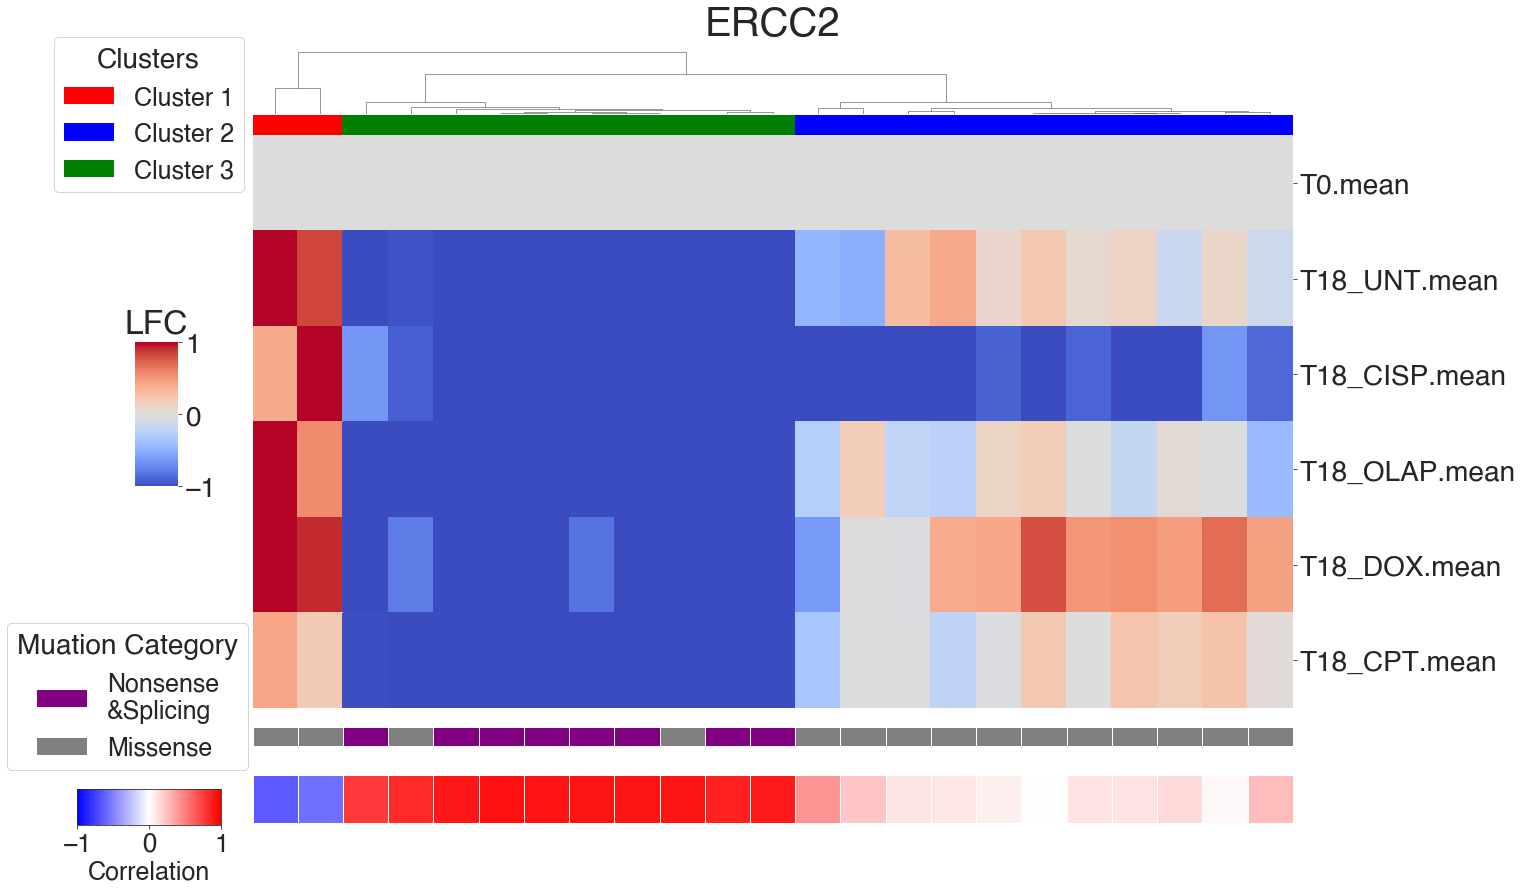

Dimensionality reduction plot saved to: /home/whe/Work_progress/BE_screen_pipeline/ProTiler-Mut/Test/ERCC2_DimReduction.png


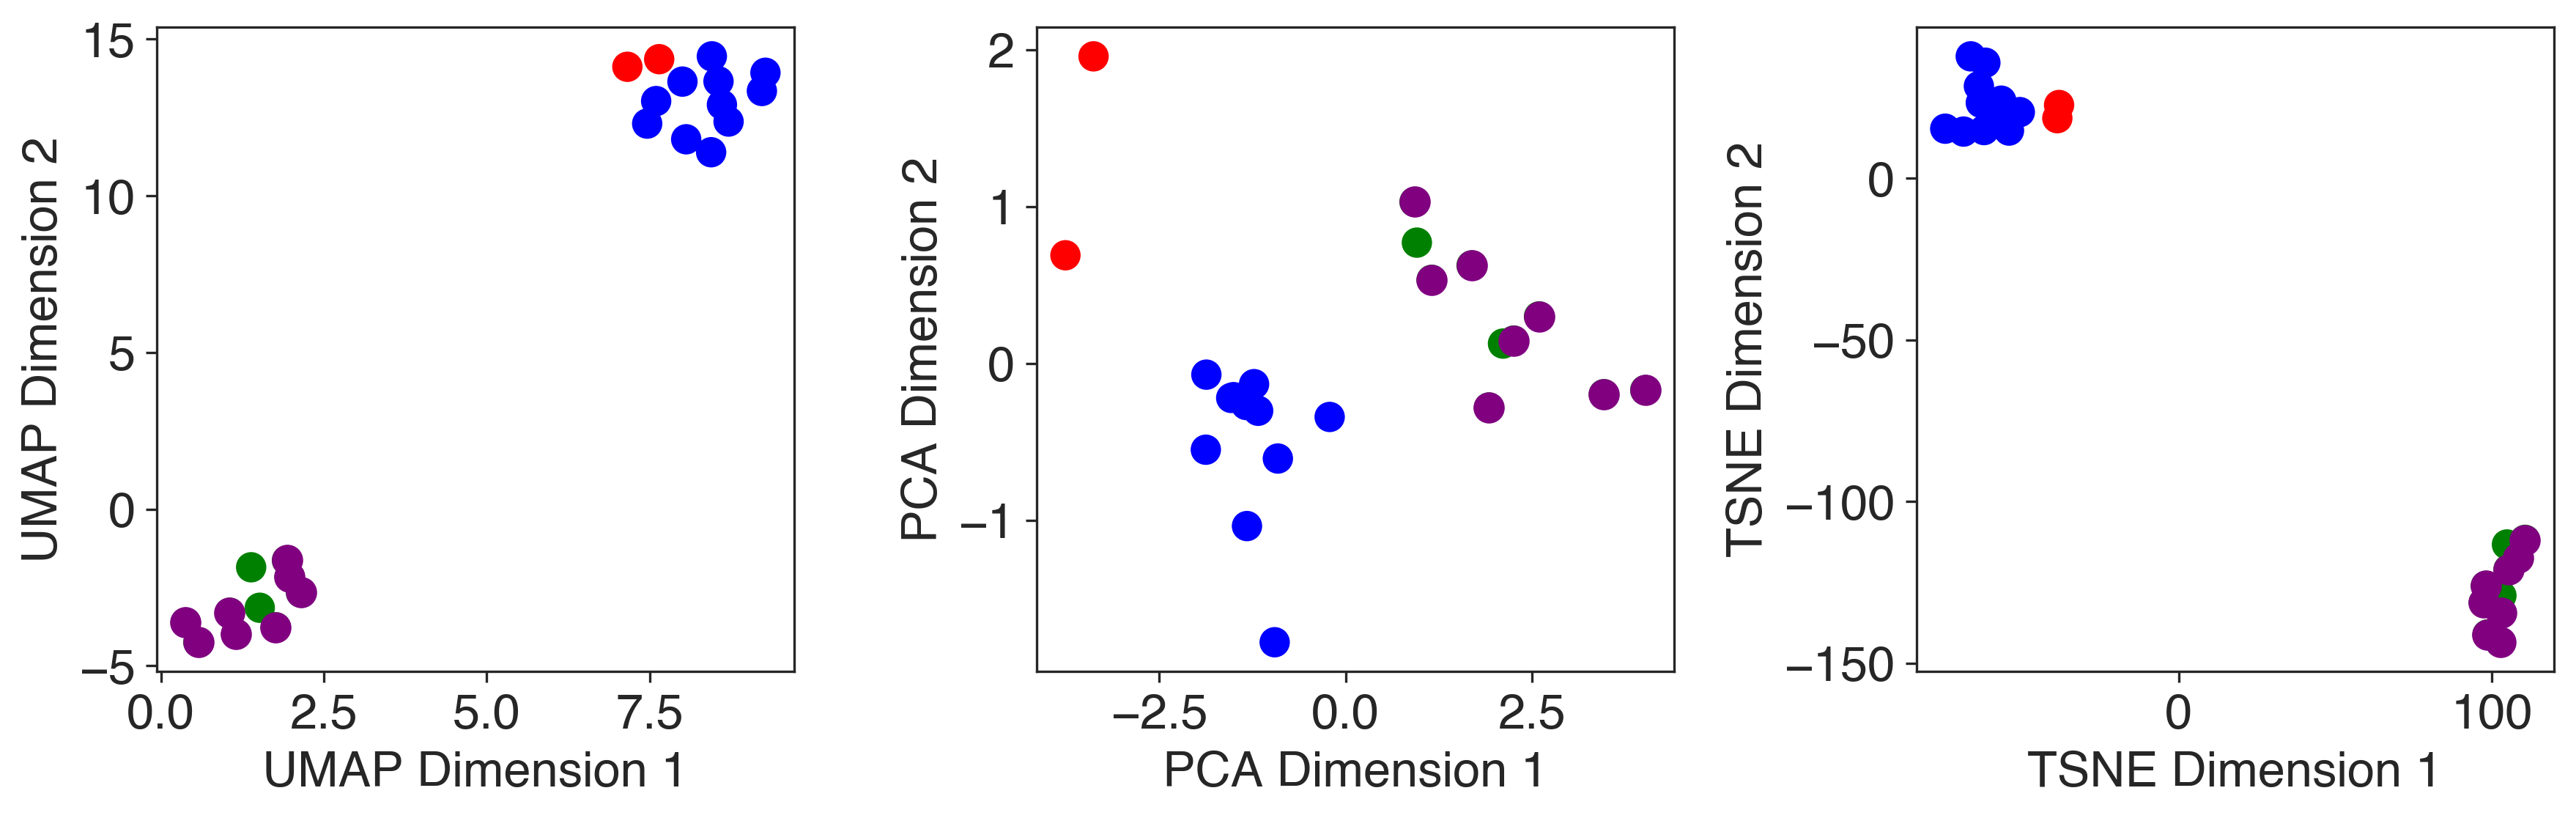

In [47]:
sample_ls = ['T0.mean', 'T18_UNT.mean','T18_CISP.mean', 'T18_OLAP.mean','T18_DOX.mean', 'T18_CPT.mean']

df_clust = clustering(df_gene,gene,sample_ls,'T0.mean',3,'average','correlation','Test')

In [48]:
df_clust

Unnamed: 0          Unnamed: 0.1     T0_R1     T0_R2  \
missense_V242              5739  ERCC2_Core-ERCC2.109 -0.044141 -0.494122   
splice-donor_S436          5797  ERCC2_Core-ERCC2.162  0.449399  0.580336   
splice-donor_S436          5798  ERCC2_Core-ERCC2.163  0.587963  0.436941   
splice-acceptor_NA         5842  ERCC2_Core-ERCC2.202 -0.200270 -0.245244   
splice-acceptor_NA         5849  ERCC2_Core-ERCC2.209 -0.471592 -0.709915   
splice-donor_Q555          5851  ERCC2_Core-ERCC2.210 -0.052770 -0.221036   
missense_G534              5858  ERCC2_Core-ERCC2.217 -0.183117 -0.231989   
missense_E606              5882  ERCC2_Core-ERCC2.239  0.141291  0.198333   
missense_E606              5884  ERCC2_Core-ERCC2.240  0.573458  0.801646   
splice-acceptor_A62        5905   ERCC2_Core-ERCC2.26 -0.453197  0.057897   
missense_R666              5908  ERCC2_Core-ERCC2.262 -0.127368  0.150214   
missense_G713              5922  ERCC2_Core-ERCC2.275 -0.086040 -0.054279   
missense_S51               5972  ERCC2_Core-ERCC2.320  0.274186  0.282331   
missense_T76               5974  ERCC2_Core-ERCC2.322  0.011552 -0.569921   
splice-acceptor_V83        5992   ERCC2_Core-ERCC2.34 -0.035563 -0.320408   
missense_S506              6112  ERCC2_Core-ERCC2.448  0.571213  0.163649   
missense_S506              6115  ERCC2_Core-ERCC2.450 -1.846129 -1.480865   
missense_V130              6125   ERCC2_Core-ERCC2.46  0.057177 -0.099703   
missense_S605              6152  ERCC2_Core-ERCC2.484 -0.880894 -0.831261   
splice-donor_NA            6214   ERCC2_Core-ERCC2.55  0.608905  0.571544   
missense_R196              6216   ERCC2_Core-ERCC2.57 -0.086040  0.119519   
missense_R186              6221   ERCC2_Core-ERCC2.61 -0.823655 -0.353517   
missense_E235              6235   ERCC2_Core-ERCC2.74  0.193302  0.297646   

                        T0_R3  T18_UNT_R1  T18_UNT_R2  T18_UNT_R3  \
missense_V242        0.078063   -0.372269   -0.783598   -0.676189   
splice-donor_S436    0.891267   -1.589438   -1.725994   -1.948695   
splice-donor_S436    0.465001   -2.717941   -2.238141   -2.087356   
splice-acceptor_NA   0.001815   -2.062622   -1.334834   -0.712207   
splice-acceptor_NA  -0.368441   -2.202528   -2.462555   -1.483715   
splice-donor_Q555    0.250311   -2.804485   -2.187097   -2.240775   
missense_G534       -0.058635   -2.003835   -2.432519   -2.146780   
missense_E606        0.466385    0.397052   -0.017358    0.721558   
missense_E606        0.943902    0.953290    0.254443    1.498971   
splice-acceptor_A62  0.240633   -1.812311   -1.311868   -1.409057   
missense_R666        0.473289   -0.395173    0.443121    0.767548   
missense_G713        0.224358   -0.619526   -1.046254   -1.143939   
missense_S51         0.527356   -0.617076   -0.101504    0.291646   
missense_T76        -0.434093   -0.008965   -0.186679   -0.120015   
splice-acceptor_V83 -0.275247   -1.978457   -1.927689   -1.178405   
missense_S506        0.355681    0.525670    0.582023    0.888104   
missense_S506       -1.661834   -0.450800   -0.965182   -0.180829   
missense_V130        0.052478   -0.262907   -0.388125    0.297231   
missense_S605       -0.436678   -0.299757   -1.005149   -0.635719   
splice-donor_NA      0.617357   -1.371443   -0.972367   -0.533038   
missense_R196        0.286818    0.474901    0.012064    1.083378   
missense_R186       -0.763500   -0.228844    0.049790    0.790500   
missense_E235        0.481529   -0.295833   -0.051190    0.919224   

                     T18_CISP_R1  T18_CISP_R2  ...  Range.max     p_max  \
missense_V242          -1.679223    -1.551410  ...   1.373239  0.002301   
splice-donor_S436      -1.589903    -1.654503  ...   2.395043  0.000140   
splice-donor_S436      -2.131597    -2.633287  ...   2.844448  0.000130   
splice-acceptor_NA     -0.460408    -0.742634  ...   1.389169  0.001496   
splice-acceptor_NA     -1.646685    -1.153890  ...   1.532950  0.007763   
splice-donor_Q555      -1.891559    -1.251539  ...   2.402954  0.

In [ ]:
def Annotation(df_clust,gene,output_folder,pdb_path=None):
    # Create output folder if provided
    if output_folder is not None and not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    ## Annotate alphafold score
    if gene in alpha_dic:
        alpha_ls = []
        for aa in df_clust['AA']:
            score = 'NA'
            if aa != 'NA' and str(aa) in alpha_dic[gene]:
                score = round(np.mean(alpha_dic[gene][str(aa)]),3)
            alpha_ls.append(score)
        df_clust['Alphafold.score'] = alpha_ls
    else:
        df_clust['Alphafold.score'] = ['NA'] * df_clust.shape[0]
             
    ## Domain annotation
    if gene in domain_dic:
        dom_ls = []   
        for aa in df_clust['AA']:
            domain = 'NA'
            if aa != 'NA':
                for dom in domain_dic[gene]:
                    name = dom[0]; start = dom[1]; end = dom[2]
                    if start <= aa <= end:
                        domain = name
                        break
            dom_ls.append(domain)
        df_clust['Pfam.domain'] = dom_ls
        
    else:
        df_clust['Pfam.domain'] = ['NA'] * df_clust.shape[0]
        
    ## Phosphorylation annotation
    if gene in po_dic:
        po_list = [s[0] for s in po_dic[gene] if s[1]>0]
        po_ls = []
        for aa in df_clust['AA']:
            po = 0
            if aa != 'NA':
                if aa in po_list:
                    po = 1
            po_ls.append(po)
        df_clust['Phospho.site'] = po_ls
    else:
        df_clust['Phospho.site'] = ['NA'] * df_clust.shape[0]
            
    ## Clivar annotation:
    if gene in clinvar_dic:
        cli_ls = []
        for aa in df_clust['AA']:
            cli = 'NA'
            if aa != 'NA':
                for mut in clinvar_dic[gene]:
                    mut_aa = int(mut[3:-3])
                    if abs(aa - mut_aa)<=5:
                        cli = mut
                        break
            cli_ls.append(cli)
        df_clust['ClinVar'] = cli_ls
            
    else:
        df_clust['ClinVar'] = ['NA'] * df_clust.shape[0]
    
    if pdb_path is None:
        print(f"No pdb path provided for gene {gene}. Skipping structure score calculation.")
        # Fill with 'NA' if you wish to maintain columns
        df_clust['ResidueDepth'] = ['NA'] * df_clust.shape[0]
        df_clust['ASA'] = ['NA'] * df_clust.shape[0]
    
    else:
        # Attempt to parse the PDB structure
        try:
            parser = PDBParser(PERMISSIVE=1, QUIET=True)
            structure = parser.get_structure('', pdb_path)
            model = structure[0]
        except Exception as e:
            print(f"Error parsing pdb file for gene {gene}: {e}")
            model = None
        
        if model is not None:
            
            try:
                surface = get_surface(model)
            except Exception as e:
                print(f"Error calculating surface for gene {gene}: {e}")
                surface = None
            
            try:
                chain = model['A']
            except Exception as e:
                print(f"Error accessing chain A for gene {gene}: {e}")
                chain = None
            
            try:
                dssp = DSSP(model, pdb_path, dssp='mkdssp')
            except Exception as e:
                print(f"Error calculating DSSP for gene {gene}: {e}")
                dssp = None

            rd_ls = []; asa_ls = []
            # Assuming df_clust['AA'] holds residue numbers (integers)
            for aa in df_clust['AA']:
                try:
                    if chain is not None and surface is not None and dssp is not None:
                        # Get the residue from chain using the residue number directly
                        residue = chain[aa]
                        rd = residue_depth(residue, surface)
                        # Construct the DSSP key; adjust based on your DSSP output format
                        key = ('A', (' ', aa, ' '))
                        asa = dssp[key][3]
                        rd_ls.append(rd)
                        asa_ls.append(asa)
                    else:
                        rd_ls.append('NA')
                        asa_ls.append('NA')
                except Exception as e:
                    rd_ls.append('NA')
                    asa_ls.append('NA')
            
            df_clust['ResidueDepth'] = rd_ls
            df_clust['ASA'] = asa_ls
        
        else:
            df_clust['ResidueDepth'] = ['NA'] * df_clust.shape[0]
            df_clust['ASA'] = ['NA'] * df_clust.shape[0]
    
    # Save the annotated table if an output folder is provided
    if output_folder is not None:
        table_path = os.path.join(os.getcwd(),output_folder, f"{gene}_Cluster_Annotation_Table.csv")
        df_clust.to_csv(table_path, index=False)
        print(f"Annotation table saved to: {table_path}")
    
    return df_clust



def kde_sklearn(x: np.ndarray, x_grid: np.ndarray, bandwidth: float) -> np.ndarray:
    """
    Compute Kernel Density Estimation using Scikit-learn.

    Parameters:
        x (np.ndarray): Input data points of shape (n_samples, 1).
        x_grid (np.ndarray): Points to evaluate the density on.
        bandwidth (float): Bandwidth for the kernel.

    Returns:
        np.ndarray: Density estimates evaluated on x_grid.
    """
    kde_model = KernelDensity(kernel="gaussian", bandwidth=bandwidth)
    kde_model.fit(x)
    log_pdf = np.exp(kde_model.score_samples(x_grid))
    return log_pdf


def get_sift_kde(con_list: list, aa_list: list, bw: float) -> np.ndarray:
    """
    Generate a kernel density estimate (KDE) for SIFT scores.

    Parameters:
        con_list (list): List of conservation scores.
        aa_list (list): List of amino acid positions.
        bw (float): Bandwidth for KDE.

    Returns:
        np.ndarray: KDE values evaluated on the amino acid grid.
    """
    binned = list(pd.cut(con_list, 100, labels=False))
    x_grid = np.array(aa_list).reshape(-1, 1)
    weight_list = []
    for i, count in enumerate(binned):
        weight_list += [(i + 1)] * int(count)
    x = np.array(weight_list).reshape(-1, 1)
    kde_values = kde_sklearn(x, x_grid, bw)
    return kde_values


def plot_exons(res_max: float, pos: float, exon_list: list) -> None:
    """
    Plot exon regions as bars.

    Parameters:
        res_max (float): Maximum residue value.
        pos (float): Vertical position for plotting.
        exon_list (list): List of exon boundaries.
    """
    plt.text(-(res_max / 7), pos + 0.2, "Exons list")
    for i in range(len(exon_list) - 1):
        exon_width = exon_list[i + 1] - exon_list[i]
        color = "silver" if (i + 1) % 2 == 0 else "black"
        plt.bar(
            exon_list[i] + exon_width / 2,
            0.6,
            width=exon_width,
            bottom=pos,
            facecolor=color,
            alpha=0.2,
        )


def plot_domain(res_max: float, pos: float, domains: list) -> None:
    """
    Plot Pfam domain annotations.

    Parameters:
        res_max (float): Maximum residue value.
        pos (float): Vertical position for plotting.
        domains (list): List of domains, each represented as (name, start, end).
    """
    plt.bar(res_max / 2, 0.6, width=res_max, bottom=pos, color="silver", alpha=0.2)
    plt.text(-(res_max / 7), pos + 0.2, "Pfam domain")
    for domain in domains:
        dom_name, dom_start, dom_end = domain
        loc = int((dom_start + dom_end) / 2)
        length = dom_end - dom_start
        plt.bar(loc, 0.6, width=length, bottom=pos, facecolor="lightcoral", alpha=0.8)
        label_y = pos + 0.2 if len(dom_name) <= 15 else pos + 0.1
        label_text = dom_name if len(dom_name) <= 15 else dom_name[:15]
        plt.text(loc, label_y, label_text, fontsize=8, horizontalalignment="center")


def plot_contlist(
    res_max: float, cont_list: list, pos: float, label: str, palette: str, reverse: bool
) -> None:
    """
    Plot a continuous data list as a bar plot.

    Parameters:
        res_max (float): Maximum residue value.
        cont_list (list): List of continuous values.
        pos (float): Vertical position for plotting.
        label (str): Label text to display.
        palette (str): Seaborn color palette to use.
        reverse (bool): If True, sort in descending order.
    """
    plt.text(-(res_max / 7), pos + 0.2, label)
    pair_list = [(i + 1, cont_list[i]) for i in range(len(cont_list))]
    pair_list.sort(key=lambda x: x[1], reverse=reverse)
    color_list = sns.color_palette(palette, len(cont_list))
    min_val = min(cont_list)
    zero_list = [pair for pair in pair_list if pair[1] == min_val]
    non_zero = [pair for pair in pair_list if pair[1] != min_val]
    plt.bar(
        [pair[0] for pair in zero_list],
        height=[0.6] * len(zero_list),
        width=1,
        bottom=pos,
        color=color_list[0],
    )
    plt.bar(
        [pair[0] for pair in non_zero],
        height=[0.6] * len(non_zero),
        width=1,
        bottom=pos,
        color=color_list[len(zero_list):],
    )


def plot_bilist(res_max: float, loc_list: list, pos: float, label: str, color: str) -> None:
    """
    Plot a binary list as a bar plot.

    Parameters:
        res_max (float): Maximum residue value.
        loc_list (list): List of locations to mark.
        pos (float): Vertical position for plotting.
        label (str): Label text to display.
        color (str): Color for the bars.
    """
    plt.text(-(res_max / 7), pos + 0.2, label)
    plt.bar(res_max / 2, 0.6, width=res_max, bottom=pos, color="silver", alpha=0.2)
    plt.bar(loc_list, [0.6] * len(loc_list), width=res_max / 1000, bottom=pos, color=color)


def visualization_1d(
     df_clust: pd.DataFrame, gene: str, output_folder: str
) -> None:
    """
    Generate a one-dimensional visualization of tiling mutagenesis screen data for missense mutations.

    Parameters:
        df_all (pd.DataFrame): DataFrame containing all sgRNA data.
        df_clust (pd.DataFrame): DataFrame with sgRNA clustering results.
        gene (str): Gene name.
        output_folder (str): Directory path to save the resulting figure.
        
    Note:
        This function expects global dictionaries 'exons_dic', 'alpha_dic', 'po_dic',
        'clinvar_dic', and 'domain_dic' to be defined.
    """
    # Retrieve exon information
    res_max = exons_dic[gene][0]["AA.num"]
    exon_list = exons_dic[gene][0]["AA.list"]

    # Compute Alphafold score list if available
    if gene in alpha_dic:
        score_list = [np.mean(alpha_dic[gene][str(n)]) for n in range(1, len(alpha_dic[gene]) + 1)]
    else:
        score_list = [0] * res_max

    kde_score_list = get_sift_kde(score_list, list(range(1, res_max)), 10)

    # Retrieve phosphosite and ClinVar data if available
    if gene in po_dic:
        po_list = [s[0] for s in po_dic[gene] if s[1] > 0]
    else:
        po_list = [0] * res_max

    if gene in clinvar_dic:
        clinvar_list = [int(s[3:-3]) for s in clinvar_dic[gene] if s[-3:] != "Ter"]
    else:
        clinvar_list = [0] * res_max

    # Retrieve domain data if available
    dom_list = domain_dic.get(gene, [])

    plt.figure(figsize=(8, 5), dpi=300)
    plt.rcParams["font.size"] = 10
    plt.rcParams["font.family"] = "Helvetica"
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    # Plot various tracks
    plot_contlist(res_max, kde_score_list, 6, "Alphafold", "Blues", reverse=False)
    plot_exons(res_max, 5, exon_list)
    plot_domain(res_max, 4, dom_list)
    plot_bilist(res_max, po_list, 3, "Phosphosite", "black")
    plot_bilist(res_max, clinvar_list, 2, "Pathogenicity", "red")

    # Plot all missense sgRNA locations
    df_gene_missense = df_all[(df_all["Gene"] == gene) & (df_all["Function"] == "missense")]
    aa_list_all = [aa for aa in list(df_gene_missense["AA"]) if aa != "NA"]
    plot_bilist(res_max, aa_list_all, 1, "sgRNAs all", "gray")

    # Plot significant sgRNAs per cluster for missense mutations
    df_clust_missense = df_clust[df_clust["Function"] == "missense"]
    color_list = ["red", "blue", "green", "orange", "purple", "yellow", "cyan", "pink", "teal", "brown"]
    for cluster in sorted(set(df_clust_missense["Cluster"])):
        df_cluster = df_clust_missense[df_clust_missense["Cluster"] == cluster]
        aa_list_res = []
        for aa in df_cluster["AA"]:
            if str(aa) != "NA":
                offset = random.randint(1, int(res_max / 100)) if aa not in aa_list_res else random.randint(2, int(res_max / 100))
                aa_list_res.append(aa + offset)
        plot_bilist(res_max, aa_list_res, -cluster, f"Cluster_{cluster+1}", color_list[cluster])

    plt.title(f"Tiling mutagenesis screen data of Missense sgRNAs targeting {gene}")
    plt.yticks([])
    plt.xticks([i - i % 10 for i in range(0, int(res_max), int(res_max / 100) * 10)])
    plt.xlabel("AA_Location")
    plt.xlim(0, res_max + 5)

    fig_save_path = os.path.join(os.getcwd(), output_folder, f"{gene}_ClusterDistribution_1D.png")
    plt.savefig(fig_save_path, dpi=300, facecolor="white", bbox_inches="tight")
    plt.show()
    

def Visualization_3D(gene, clust_ls, output_folder, pdb=None):
    
    if output_folder is not None and not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    if pdb_path is None:
        print(f"No pdb path provided for gene {gene}. Skip.")
        # Fill with 'NA' if you wish to maintain columns
        return None
    
    pymol.cmd.load(pdb_path)
    #pymol.cmd.hide('surface')
    pymol.cmd.hide('everything')
    pymol.cmd.color('gray')
    pymol.cmd.bg_color('white')
    
    pymol.cmd.show('cartoon')
    pymol.cmd.set('cartoon_transparency',0.7)
    #pymol.cmd.spectrum('b','blue_white_red',minimum=50,maximum=100)
    
    color_list = ["red", "blue", "green", "orange", "purple", 
                  "yellow", "cyan", "pink", "teal", "brown"]
    
    one_letter ={'VAL':'V', 'ILE':'I', 'LEU':'L', 'GLU':'E', 'GLN':'Q', \
                 'ASP':'D', 'ASN':'N', 'HIS':'H', 'TRP':'W', 'PHE':'F', 'TYR':'Y', \
                 'ARG':'R', 'LYS':'K', 'SER':'S', 'THR':'T', 'MET':'M', 'ALA':'A', \
                 'GLY':'G', 'PRO':'P', 'CYS':'C'}
    
    n = 0
    for ix_ls in cluster_ls:
        sel = '+'.join([str(num) for num in ix_ls])
        print(sel)
        
        color = color_list[n]

        pymol.cmd.select('Cluster'+str(n+1), "resi "+sel)
        pymol.cmd.show('sticks', 'Cluster'+str(n+1))
        pymol.cmd.color(color, 'Cluster'+str(n+1))
        

        pymol.cmd.label('n. CA and i. '+sel, 'resi')
        pymol.cmd.set('label_size',10)
        pymol.cmd.set('stick_radius',0.5)
        
        n += 1
    
    pymol.cmd.set('stick_transparency',0)  
    
    print('Save pymol session and images ...')
    
    #figsavepath = os.path.join(os.getcwd(),outputfolder,gene+'_BE_Cluster_3D.png')
    pymolsavepath = os.path.join(os.getcwd(),output_folder,gene+'_ClustersDistribution_3D.pse')
    pymol.cmd.save(pymolsavepath)
    pymol.cmd.reinitialize()
    #pymol.cmd.png(figsavepath,width=1200, height=1200, dpi=300, ray=0)
    print('Finished') 


def main():
    """
    Main function to demonstrate usage of the clustering module.
    Adjust parameters and file paths as needed.
    """
    # Example parameters (modify these as needed)
    gene = "MY_GENE"
    sample_list = ["T0.mean", "T18_UNT.mean", "T18_CISP.mean", "T18_OLAP.mean", "T18_DOX.mean", "T18_CPT.mean"]
    sample_control = ["T0.mean"]
    n_clusters = 4
    clustering_method = "average"
    clustering_metric = "euclidean"
    output_folder = "results"

    # Load your gene data (replace with actual file path)
    # The gene data CSV should include columns for the samples and an "sgID" column.
    df_gene = pd.read_csv("gene_data.csv")
    
    # Ensure the 'sgID' column exists (if not, create it)
    if "sgID" not in df_gene.columns and "Unnamed: 0.1" in df_gene.columns:
        df_gene["sgID"] = df_gene["Unnamed: 0.1"]

    # Perform clustering
    updated_df = clustering(
        df_gene,
        gene,
        sample_list,
        sample_control,
        n_clusters,
        clustering_method,
        clustering_metric,
        output_folder=output_folder,
    )

    # Optionally, call visualization_1d if global dictionaries (exons_dic, alpha_dic, etc.) are defined
    # visualization_1d(updated_df, updated_df, gene, output_folder)


if __name__ == "__main__":
    main()
